In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from skimage.feature import hog
plt.close()
debug_fig = True

In [12]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], nbins, bins_range)
    ghist = np.histogram(img[:,:,1], nbins, bins_range)
    bhist = np.histogram(img[:,:,2], nbins, bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def convert_color(img, conv='YCrCb'):
    # apply color conversion if other than 'RGB'
    if conv != 'RGB':
        if conv == 'HSV':
            cimage = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif conv == 'LUV':
            cimage = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif conv == 'HLS':
            cimage = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif conv == 'YUV':
            cimage = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif conv == 'YCrCb':
            cimage = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: cimage = np.copy(img)   
    return cimage

def plot_samples(image, spatial_features, rh, gh, bh, bincen, hog_image):
    # Plot the examples
    # Plot features
    plt.figure()
    plt.plot(spatial_features)
    plt.title('Spatially Binned Features')
    # Plot a figure with all three bar charts
    if rh is not None:
        plt.figure()
        plt.subplot(131)
        plt.bar(bincen, rh[0])
        plt.xlim(0, 256)
        plt.title('R Histogram')
        plt.subplot(132)
        plt.bar(bincen, gh[0])
        plt.xlim(0, 256)
        plt.title('G Histogram')
        plt.subplot(133)
        plt.bar(bincen, bh[0])
        plt.xlim(0, 256)
        plt.title('B Histogram')
    # Plot the examples
    plt.figure()
    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization')    
    plt.show()
            
            
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist() and get_hog_features()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, vis=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    print('training image count: ', len(imgs))
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, cspace)
        # Apply bin_spatial() to get spatial color features
        
        spatial_features = bin_spatial(feature_image, size=spatial_size)

        # Apply color_hist() also with a color space option now
        rh, gh, bh, bincen, hist_features = color_hist(image, nbins=hist_bins, bins_range=hist_range)

        # Call get_hog_features() with vis=False, feature_vec=True
        if vis:
            if hog_channel is not 'ALL':
                hog_feature, hog_image = get_hog_features(feature_image[:,:,hog_channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
#         print('spacial: ', spatial_features.shape)
#         print('hist: ', hist_features.shape)
#         print('hog:', hog_features.shape)
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        if vis:
            print("Plot image samples")
            plot_samples(image, spatial_features, rh, gh, bh, bincen, hog_image)
    # Return list of feature vectors
    return features

def fit_scale(data):
    # Create an array stack, NOTE: StandardScaler() expects np.float64
    X = np.vstack(data).astype(np.float64) 
    print(np.amin(X))
    print(np.amax(X))
#     print(X.shape)
    # Fit a per-column scaler
    return StandardScaler().fit(X)
    
## Data is a tuple of data
def scale_data(X_scaler, data):
    # Create an array stack, NOTE: StandardScaler() expects np.float64
    X = np.vstack(data).astype(np.float64) 
    # Apply the scaler to X
#     print(X.shape)
    return X_scaler.transform(X)


def testdata():
    cars = ['test_images/image0005.png']

    car_features = extract_features(cars, cspace=HYPERPARAMS['COLOR_SPACE'], spatial_size=HYPERPARAMS['SPATIAL_SIZE'],
                            hist_bins=HYPERPARAMS['HIST_BIN'], hist_range=HYPERPARAMS['HIST_RANGE'], orient=HYPERPARAMS['HOG_ORIENT'], 
                            pix_per_cell=HYPERPARAMS['HOG_PIX_PER_CELL'], cell_per_block=HYPERPARAMS['HOG_CELL_PER_BLOCK'], 
                            hog_channel=0, vis=True)

def load_files():
    # Read in car and non-car images
    cars = glob.glob('training/vehicles/*/*.png')
    notcars = glob.glob('training/non-vehicles/*/*.png')
    return cars, notcars
    
HYPERPARAMS = {
    'COLOR_SPACE': 'YCrCb', # Color space
    'SPATIAL_FEAT': True, # Using spacial features?
    'SPATIAL_SIZE': (32, 32), # How many spacial features
    'HOG_FEAT': True, # Using hog features?
    'HOG_ORIENT': 11, # Hog cell orientation
    'HOG_PIX_PER_CELL': 8, # Pixels per hog cell
    'HOG_CELL_PER_BLOCK': 2, # Hog cell overlap
    'HOG_CHANNEL': "ALL",  # Which hog channels to use
    'HIST_FEAT': True, # Using histogram features?
    'HIST_RANGE': (0.0, 256.0), # Histogram min / max
    'HIST_BIN': 32, # How many bins for histogram
    'HEAT_THRESHOLD': 2.0, # Threshold to reject false positives
    'HEAT_FRAMES': 5 # Over how many frames to collect heat
}


training image count:  1
Plot image samples


/home/suprnrdy/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


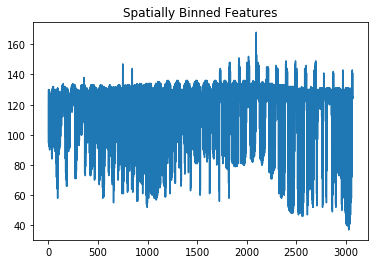

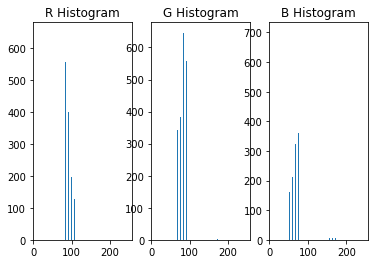

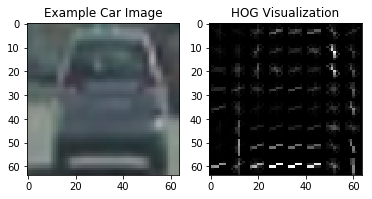

In [13]:
testdata()

In [14]:

def train_model():
    cars, notcars = load_files()

    # TODO play with these values to see how your classifier
    # performs under different binning scenarios

    car_features = extract_features(cars, cspace=HYPERPARAMS['COLOR_SPACE'], spatial_size=HYPERPARAMS['SPATIAL_SIZE'],
                            hist_bins=HYPERPARAMS['HIST_BIN'], hist_range=HYPERPARAMS['HIST_RANGE'], orient=HYPERPARAMS['HOG_ORIENT'], 
                            pix_per_cell=HYPERPARAMS['HOG_PIX_PER_CELL'], cell_per_block=HYPERPARAMS['HOG_CELL_PER_BLOCK'], 
                            hog_channel=HYPERPARAMS['HOG_CHANNEL'], vis=False)
    notcar_features = extract_features(notcars, cspace=HYPERPARAMS['COLOR_SPACE'], spatial_size=HYPERPARAMS['SPATIAL_SIZE'],
                            hist_bins=HYPERPARAMS['HIST_BIN'], hist_range=HYPERPARAMS['HIST_RANGE'], orient=HYPERPARAMS['HOG_ORIENT'], 
                            pix_per_cell=HYPERPARAMS['HOG_PIX_PER_CELL'], cell_per_block=HYPERPARAMS['HOG_CELL_PER_BLOCK'], 
                            hog_channel=HYPERPARAMS['HOG_CHANNEL'], vis=False)
#     print(np.vstack(car_features).astype(np.float64).shape )
    # Apply the scaler to X
    print(len(car_features))
    data = (car_features, notcar_features)
    x_scaler = fit_scale(data)
    scaled_X = scale_data(x_scaler, data)
    
    print(np.amin(scaled_X))
    print(np.amax(scaled_X))
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using spatial binning of:',HYPERPARAMS['SPATIAL_SIZE'],
        'and', HYPERPARAMS['HIST_BIN'],'histogram bins')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    joblib.dump(svc, 'vehicle-detection-model.pkl') 
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 30
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    return x_scaler, svc
    
    ## WE should save the model here somewhere so it can be reloaded once we've trained it.

In [15]:
## Train the model, and then return the classifier used for predictionx
x_scaler, svc = train_model()


training image count:  8792


/home/suprnrdy/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


training image count:  8968
8792
0.0
4096.0
-14.1559766717
52.7580425849
Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 9636
21.8 Seconds to train SVC...
Test Accuracy of SVC =  0.9913
My SVC predicts:  [ 0.  1.  0.  1.  0.  0.  1.  0.  1.  1.  0.  1.  1.  1.  1.  0.  0.  0.
  1.  0.  1.  1.  0.  1.  0.  1.  1.  0.  1.  1.]
For these 30 labels:  [ 0.  1.  0.  1.  0.  0.  1.  0.  1.  1.  0.  1.  1.  1.  1.  0.  0.  0.
  1.  0.  1.  1.  0.  1.  0.  1.  1.  0.  1.  1.]
0.02245 Seconds to predict 30 labels with SVC


In [16]:
def add_heat(heatmap, bbox_list, threshold):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    for box in bbox_list:
        if np.max(heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]]) > threshold:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += (threshold + 1)
    
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
      
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    
    #Only use the image within the ystart and ystop positions
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=colorspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    n_box = 0
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
#             print('hog_features: ', hog_features.shape)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            rh, gh, bh, bincen, hist_features = color_hist(subimg, nbins=hist_bins, bins_range=(0,256))

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                n_box+=1
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart))
                bbox_list.append(box)
#                 cv2.rectangle(draw_img,box[0],box[1],(0,0,255),6) 
                
    print('Number of boxes found: ', n_box)
    return draw_img, bbox_list

def heat_map(img, bbox_list, heat_thresh=1):
    print("iterations: ",iteration)
    global iteration, heatmaps
    if len(bbox_list) > 0:
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat,bbox_list, heat_thresh)

        heatmaps.append(heat)
        print('heatmap len: ', len(heatmaps))
        
        # average heats
        avg_heat = sum(heatmaps)/len(heatmaps)
        heat = avg_heat
        heat = apply_threshold(heat,heat_thresh)
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
    else:
        # pass the image itself if nothing was detected
        draw_img = np.copy(img)
    iteration += 1

    if debug_fig:
        fig = plt.figure()
        plt.figure()
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.figure()
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        plt.show()
    return draw_img


<ipython-input-16-a4a5e7e00988>:113: SyntaxWarning: name 'iteration' is used prior to global declaration
  global iteration, heatmaps


/home/suprnrdy/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of boxes found:  8
Number of boxes found:  8
Number of boxes found:  8
Number of boxes found:  3
iterations:  1
heatmap len:  1


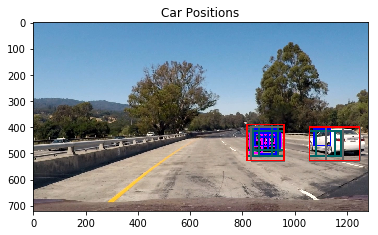

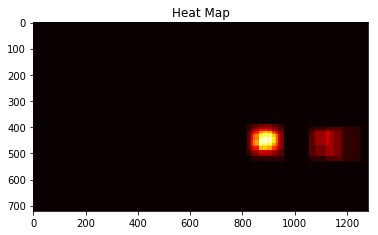

Number of boxes found:  4
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  0
iterations:  2
heatmap len:  1


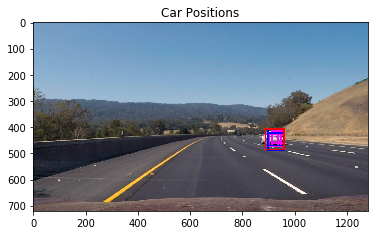

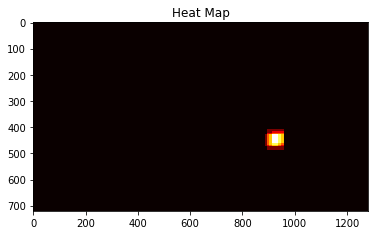

Number of boxes found:  7
Number of boxes found:  7
Number of boxes found:  5
Number of boxes found:  4
iterations:  3
heatmap len:  1


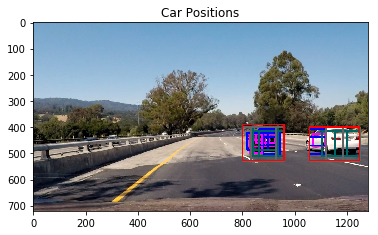

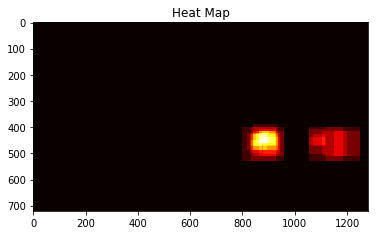

Number of boxes found:  11
Number of boxes found:  10
Number of boxes found:  7
Number of boxes found:  2
iterations:  4
heatmap len:  1


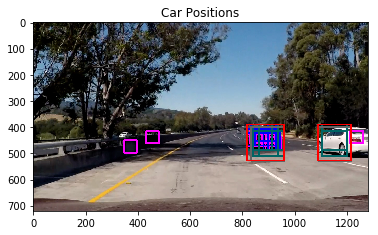

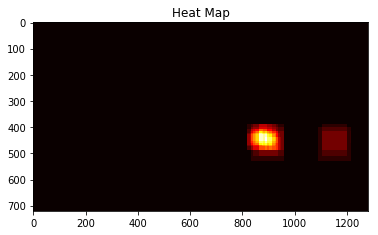

Number of boxes found:  7
Number of boxes found:  16
Number of boxes found:  8
Number of boxes found:  4
iterations:  5
heatmap len:  1


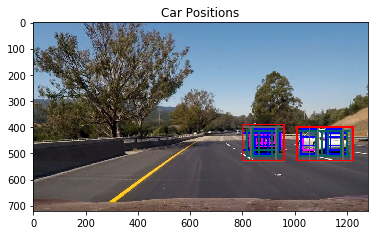

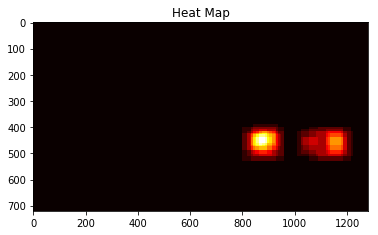

Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  0
iterations:  6
heatmap len:  1


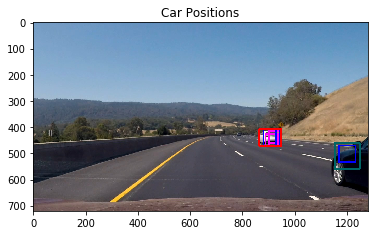

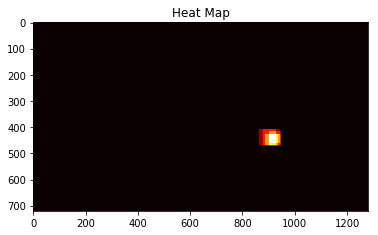

Number of boxes found:  11
Number of boxes found:  5
Number of boxes found:  2
Number of boxes found:  2
iterations:  7
heatmap len:  1


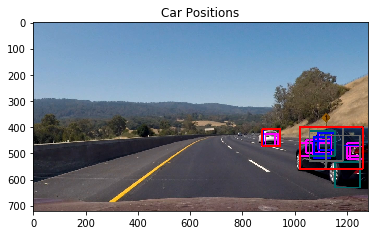

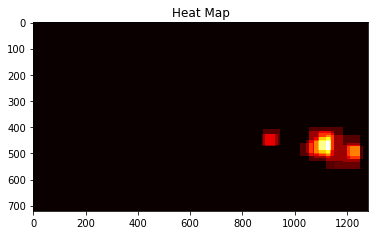

In [17]:
from collections import deque
svc = joblib.load('vehicle-detection-model.pkl') 
heatmaps = deque(maxlen=10)
iteration = 1

def process_image(img, figures=False):
    draw_image = np.copy(img)
    bbox = []
    bbox1 = []
    bbox2 = []
    bbox3 = []
    bbox4 = []
    
    ystart = 390
    ystop = 550
    scale = 0.75
    found_img, bbox0 = find_cars(img, HYPERPARAMS['COLOR_SPACE'], ystart, ystop, scale, svc, x_scaler, 
                                HYPERPARAMS['HOG_ORIENT'], HYPERPARAMS['HOG_PIX_PER_CELL'], 
                                HYPERPARAMS['HOG_CELL_PER_BLOCK'], HYPERPARAMS['SPATIAL_SIZE'], 
                                HYPERPARAMS['HIST_BIN'])
    
    ystart = 390
    ystop = 650
    scale = 1
    found_img, bbox1 = find_cars(img, HYPERPARAMS['COLOR_SPACE'], ystart, ystop, scale, svc, x_scaler, 
                                HYPERPARAMS['HOG_ORIENT'], HYPERPARAMS['HOG_PIX_PER_CELL'], 
                                HYPERPARAMS['HOG_CELL_PER_BLOCK'], HYPERPARAMS['SPATIAL_SIZE'], 
                                HYPERPARAMS['HIST_BIN'])
    
    ystart = 390
    ystop = img.shape[0]
    scale = 1.5
    found_img, bbox2 = find_cars(img, HYPERPARAMS['COLOR_SPACE'], ystart, ystop, scale, svc, x_scaler, 
                                HYPERPARAMS['HOG_ORIENT'], HYPERPARAMS['HOG_PIX_PER_CELL'], 
                                HYPERPARAMS['HOG_CELL_PER_BLOCK'], HYPERPARAMS['SPATIAL_SIZE'], 
                                HYPERPARAMS['HIST_BIN'])
    
    ystart = 400
    ystop = img.shape[0]
    scale = 2
    found_img, bbox3 = find_cars(img, HYPERPARAMS['COLOR_SPACE'], ystart, ystop, scale, svc, x_scaler, 
                                HYPERPARAMS['HOG_ORIENT'], HYPERPARAMS['HOG_PIX_PER_CELL'], 
                                HYPERPARAMS['HOG_CELL_PER_BLOCK'], HYPERPARAMS['SPATIAL_SIZE'], 
                                HYPERPARAMS['HIST_BIN'])

    
    bbox = bbox0 + bbox1 + bbox2 + bbox3
    
    if debug_fig:
        for box in bbox0:
            cv2.rectangle(found_img,box[0],box[1],(255,0,255),6) 

        for box in bbox1:
            cv2.rectangle(found_img,box[0],box[1],(0,0,255),6) 

        for box in bbox2:
            cv2.rectangle(found_img,box[0],box[1],(0,100,100),6) 

        for box in bbox3:
            cv2.rectangle(found_img,box[0],box[1],(100,100,100),6) 
    
    
    out_img = heat_map(found_img, bbox, 2)
    return out_img

bbox = []
heatmaps.clear()
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out_img = process_image(img)

# bbox = []
# heatmaps.clear()
# img = cv2.imread('test_images/test2.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# out_img = process_image(img)

bbox = []
heatmaps.clear()
img = cv2.imread('test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out_img = process_image(img)

bbox = []
heatmaps.clear()
img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out_img = process_image(img)

bbox = []
heatmaps.clear()
img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out_img = process_image(img)

bbox = []
heatmaps.clear()
img = cv2.imread('test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out_img = process_image(img)

bbox = []
heatmaps.clear()
img = cv2.imread('test_images/test7.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out_img = process_image(img)

bbox = []
heatmaps.clear()
img = cv2.imread('test_images/test8.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
out_img = process_image(img)

plt.close()
# plt.figure()
# plt.imshow(out_img)
# plt.show()


In [41]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'output_images/project_output.mp4'
heatmaps.clear()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0
iterations:  8
[MoviePy] >>>> Building video output_images/project_output.mp4
[MoviePy] Writing video output_images/project_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  0%|          | 1/1261 [00:02<57:09,  2.72s/it]

Number of boxes found:  0
iterations:  9
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  0


  0%|          | 2/1261 [00:05<57:02,  2.72s/it]

Number of boxes found:  0
iterations:  10
heatmap len:  1
Number of boxes found:  0
Number of boxes found:  1
Number of boxes found:  0


  0%|          | 3/1261 [00:08<56:52,  2.71s/it]

Number of boxes found:  0
iterations:  11
heatmap len:  2
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  0%|          | 4/1261 [00:10<56:38,  2.70s/it]

Number of boxes found:  0
iterations:  12
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  0%|          | 5/1261 [00:13<56:22,  2.69s/it]

Number of boxes found:  0
iterations:  13
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  0


  0%|          | 6/1261 [00:16<57:09,  2.73s/it]

Number of boxes found:  0
iterations:  14
heatmap len:  3
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  0


  1%|          | 7/1261 [00:18<56:45,  2.72s/it]

Number of boxes found:  0
iterations:  15
heatmap len:  4
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  1%|          | 8/1261 [00:21<56:45,  2.72s/it]

Number of boxes found:  0
iterations:  16
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  1%|          | 9/1261 [00:24<56:20,  2.70s/it]

Number of boxes found:  0
iterations:  17
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  1%|          | 10/1261 [00:26<55:47,  2.68s/it]

Number of boxes found:  0
iterations:  18
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  1%|          | 11/1261 [00:29<55:36,  2.67s/it]

Number of boxes found:  0
iterations:  19
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  1%|          | 12/1261 [00:32<55:37,  2.67s/it]

Number of boxes found:  0
iterations:  20
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  1%|          | 13/1261 [00:34<55:27,  2.67s/it]

Number of boxes found:  0
iterations:  21
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  1%|          | 14/1261 [00:37<55:27,  2.67s/it]

Number of boxes found:  0
iterations:  22
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  1%|          | 15/1261 [00:40<56:05,  2.70s/it]

Number of boxes found:  0
iterations:  23
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  1%|▏         | 16/1261 [00:43<55:33,  2.68s/it]

Number of boxes found:  0
iterations:  24
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  1%|▏         | 17/1261 [00:45<55:17,  2.67s/it]

Number of boxes found:  0
iterations:  25
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  1%|▏         | 18/1261 [00:48<55:37,  2.68s/it]

Number of boxes found:  0
iterations:  26
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  2%|▏         | 19/1261 [00:51<55:24,  2.68s/it]

Number of boxes found:  0
iterations:  27
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  2%|▏         | 20/1261 [00:53<55:33,  2.69s/it]

Number of boxes found:  0
iterations:  28
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  2%|▏         | 21/1261 [00:56<55:17,  2.68s/it]

Number of boxes found:  0
iterations:  29
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  2%|▏         | 22/1261 [00:59<55:12,  2.67s/it]

Number of boxes found:  0
iterations:  30
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  2%|▏         | 23/1261 [01:01<54:58,  2.66s/it]

Number of boxes found:  0
iterations:  31
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  2%|▏         | 24/1261 [01:04<54:55,  2.66s/it]

Number of boxes found:  0
iterations:  32
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  2%|▏         | 25/1261 [01:07<55:01,  2.67s/it]

Number of boxes found:  0
iterations:  33
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  2%|▏         | 26/1261 [01:09<55:29,  2.70s/it]

Number of boxes found:  0
iterations:  34
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  2%|▏         | 27/1261 [01:12<55:14,  2.69s/it]

Number of boxes found:  0
iterations:  35
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  2%|▏         | 28/1261 [01:15<55:09,  2.68s/it]

Number of boxes found:  0
iterations:  36
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  2%|▏         | 29/1261 [01:17<55:08,  2.69s/it]

Number of boxes found:  0
iterations:  37
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  2%|▏         | 30/1261 [01:20<54:44,  2.67s/it]

Number of boxes found:  0
iterations:  38
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  2%|▏         | 31/1261 [01:23<54:20,  2.65s/it]

Number of boxes found:  0
iterations:  39
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  3%|▎         | 32/1261 [01:25<54:13,  2.65s/it]

Number of boxes found:  0
iterations:  40
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  3%|▎         | 33/1261 [01:28<54:10,  2.65s/it]

Number of boxes found:  0
iterations:  41
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  3%|▎         | 34/1261 [01:31<54:12,  2.65s/it]

Number of boxes found:  0
iterations:  42
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  3%|▎         | 35/1261 [01:33<54:35,  2.67s/it]

Number of boxes found:  0
iterations:  43
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  3%|▎         | 36/1261 [01:36<54:27,  2.67s/it]

Number of boxes found:  0
iterations:  44
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  0


  3%|▎         | 37/1261 [01:39<54:21,  2.66s/it]

Number of boxes found:  0
iterations:  45
heatmap len:  5
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  3%|▎         | 38/1261 [01:41<54:13,  2.66s/it]

Number of boxes found:  0
iterations:  46
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  3%|▎         | 39/1261 [01:44<54:10,  2.66s/it]

Number of boxes found:  0
iterations:  47
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  3%|▎         | 40/1261 [01:46<53:39,  2.64s/it]

Number of boxes found:  0
iterations:  48
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  0


  3%|▎         | 41/1261 [01:49<54:17,  2.67s/it]

Number of boxes found:  0
iterations:  49
heatmap len:  6
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  0


  3%|▎         | 42/1261 [01:52<54:18,  2.67s/it]

Number of boxes found:  0
iterations:  50
heatmap len:  7
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  3%|▎         | 43/1261 [01:55<55:05,  2.71s/it]

Number of boxes found:  0
iterations:  51
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  3%|▎         | 44/1261 [01:57<54:53,  2.71s/it]

Number of boxes found:  0
iterations:  52
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  4%|▎         | 45/1261 [02:00<54:45,  2.70s/it]

Number of boxes found:  0
iterations:  53
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  4%|▎         | 46/1261 [02:03<54:27,  2.69s/it]

Number of boxes found:  0
iterations:  54
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  4%|▎         | 47/1261 [02:05<54:32,  2.70s/it]

Number of boxes found:  0
iterations:  55
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  4%|▍         | 48/1261 [02:08<54:14,  2.68s/it]

Number of boxes found:  0
iterations:  56
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  4%|▍         | 49/1261 [02:11<54:12,  2.68s/it]

Number of boxes found:  0
iterations:  57
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  4%|▍         | 50/1261 [02:14<54:10,  2.68s/it]

Number of boxes found:  0
iterations:  58
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  4%|▍         | 51/1261 [02:16<54:22,  2.70s/it]

Number of boxes found:  0
iterations:  59
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  4%|▍         | 52/1261 [02:19<54:07,  2.69s/it]

Number of boxes found:  0
iterations:  60
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  0


  4%|▍         | 53/1261 [02:22<53:48,  2.67s/it]

Number of boxes found:  0
iterations:  61
heatmap len:  8
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  4%|▍         | 54/1261 [02:24<53:28,  2.66s/it]

Number of boxes found:  0
iterations:  62
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  4%|▍         | 55/1261 [02:27<53:06,  2.64s/it]

Number of boxes found:  0
iterations:  63
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  4%|▍         | 56/1261 [02:29<52:58,  2.64s/it]

Number of boxes found:  0
iterations:  64
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  5%|▍         | 57/1261 [02:32<53:03,  2.64s/it]

Number of boxes found:  0
iterations:  65
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  5%|▍         | 58/1261 [02:35<52:43,  2.63s/it]

Number of boxes found:  0
iterations:  66
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  5%|▍         | 59/1261 [02:37<52:59,  2.64s/it]

Number of boxes found:  0
iterations:  67
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  5%|▍         | 60/1261 [02:40<53:27,  2.67s/it]

Number of boxes found:  0
iterations:  68
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  5%|▍         | 61/1261 [02:43<53:25,  2.67s/it]

Number of boxes found:  0
iterations:  69
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  5%|▍         | 62/1261 [02:45<53:37,  2.68s/it]

Number of boxes found:  0
iterations:  70
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  5%|▍         | 63/1261 [02:48<54:13,  2.72s/it]

Number of boxes found:  0
iterations:  71
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  5%|▌         | 64/1261 [02:51<54:12,  2.72s/it]

Number of boxes found:  0
iterations:  72
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  5%|▌         | 65/1261 [02:54<54:19,  2.73s/it]

Number of boxes found:  0
iterations:  73
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  5%|▌         | 66/1261 [02:56<53:59,  2.71s/it]

Number of boxes found:  0
iterations:  74
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  5%|▌         | 67/1261 [02:59<53:42,  2.70s/it]

Number of boxes found:  0
iterations:  75
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  5%|▌         | 68/1261 [03:02<53:44,  2.70s/it]

Number of boxes found:  0
iterations:  76
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  5%|▌         | 69/1261 [03:04<53:39,  2.70s/it]

Number of boxes found:  0
iterations:  77
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  6%|▌         | 70/1261 [03:07<53:49,  2.71s/it]

Number of boxes found:  0
iterations:  78
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  6%|▌         | 71/1261 [03:10<53:39,  2.71s/it]

Number of boxes found:  0
iterations:  79
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  6%|▌         | 72/1261 [03:13<53:26,  2.70s/it]

Number of boxes found:  0
iterations:  80
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  6%|▌         | 73/1261 [03:15<53:17,  2.69s/it]

Number of boxes found:  0
iterations:  81
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  6%|▌         | 74/1261 [03:18<53:10,  2.69s/it]

Number of boxes found:  0
iterations:  82
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  6%|▌         | 75/1261 [03:21<52:42,  2.67s/it]

Number of boxes found:  0
iterations:  83
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  6%|▌         | 76/1261 [03:23<52:40,  2.67s/it]

Number of boxes found:  0
iterations:  84
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  6%|▌         | 77/1261 [03:26<52:40,  2.67s/it]

Number of boxes found:  0
iterations:  85
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  6%|▌         | 78/1261 [03:29<52:44,  2.68s/it]

Number of boxes found:  0
iterations:  86
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  6%|▋         | 79/1261 [03:31<53:19,  2.71s/it]

Number of boxes found:  0
iterations:  87
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  6%|▋         | 80/1261 [03:34<53:45,  2.73s/it]

Number of boxes found:  0
iterations:  88
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  6%|▋         | 81/1261 [03:37<53:35,  2.72s/it]

Number of boxes found:  0
iterations:  89
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  7%|▋         | 82/1261 [03:40<53:28,  2.72s/it]

Number of boxes found:  0
iterations:  90
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  7%|▋         | 83/1261 [03:42<53:11,  2.71s/it]

Number of boxes found:  0
iterations:  91
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  7%|▋         | 84/1261 [03:45<53:08,  2.71s/it]

Number of boxes found:  0
iterations:  92
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  7%|▋         | 85/1261 [03:48<53:02,  2.71s/it]

Number of boxes found:  0
iterations:  93
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  7%|▋         | 86/1261 [03:50<53:18,  2.72s/it]

Number of boxes found:  0
iterations:  94
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  7%|▋         | 87/1261 [03:53<53:11,  2.72s/it]

Number of boxes found:  0
iterations:  95
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  7%|▋         | 88/1261 [03:56<52:57,  2.71s/it]

Number of boxes found:  0
iterations:  96
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  7%|▋         | 89/1261 [03:59<53:12,  2.72s/it]

Number of boxes found:  0
iterations:  97
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  7%|▋         | 90/1261 [04:01<53:05,  2.72s/it]

Number of boxes found:  0
iterations:  98
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  7%|▋         | 91/1261 [04:04<52:54,  2.71s/it]

Number of boxes found:  0
iterations:  99
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  7%|▋         | 92/1261 [04:07<52:40,  2.70s/it]

Number of boxes found:  0
iterations:  100
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  7%|▋         | 93/1261 [04:09<52:20,  2.69s/it]

Number of boxes found:  0
iterations:  101
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  7%|▋         | 94/1261 [04:12<51:43,  2.66s/it]

Number of boxes found:  0
iterations:  102
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  8%|▊         | 95/1261 [04:15<51:29,  2.65s/it]

Number of boxes found:  0
iterations:  103
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  8%|▊         | 96/1261 [04:17<51:52,  2.67s/it]

Number of boxes found:  0
iterations:  104
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  8%|▊         | 97/1261 [04:20<51:57,  2.68s/it]

Number of boxes found:  0
iterations:  105
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  8%|▊         | 98/1261 [04:23<51:48,  2.67s/it]

Number of boxes found:  0
iterations:  106
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  8%|▊         | 99/1261 [04:25<51:35,  2.66s/it]

Number of boxes found:  0
iterations:  107
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  8%|▊         | 100/1261 [04:28<51:15,  2.65s/it]

Number of boxes found:  0
iterations:  108
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  8%|▊         | 101/1261 [04:31<51:23,  2.66s/it]

Number of boxes found:  0
iterations:  109
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  8%|▊         | 102/1261 [04:33<51:44,  2.68s/it]

Number of boxes found:  0
iterations:  110
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  8%|▊         | 103/1261 [04:36<51:50,  2.69s/it]

Number of boxes found:  0
iterations:  111
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  8%|▊         | 104/1261 [04:39<51:45,  2.68s/it]

Number of boxes found:  0
iterations:  112
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  8%|▊         | 105/1261 [04:41<52:08,  2.71s/it]

Number of boxes found:  0
iterations:  113
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  8%|▊         | 106/1261 [04:44<52:03,  2.70s/it]

Number of boxes found:  0
iterations:  114
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  8%|▊         | 107/1261 [04:47<52:08,  2.71s/it]

Number of boxes found:  0
iterations:  115
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  9%|▊         | 108/1261 [04:50<52:31,  2.73s/it]

Number of boxes found:  0
iterations:  116
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  9%|▊         | 109/1261 [04:52<52:30,  2.73s/it]

Number of boxes found:  0
iterations:  117
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  9%|▊         | 110/1261 [04:55<52:08,  2.72s/it]

Number of boxes found:  0
iterations:  118
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  9%|▉         | 111/1261 [04:58<52:06,  2.72s/it]

Number of boxes found:  0
iterations:  119
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  9%|▉         | 112/1261 [05:00<52:01,  2.72s/it]

Number of boxes found:  0
iterations:  120
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  9%|▉         | 113/1261 [05:03<51:45,  2.71s/it]

Number of boxes found:  0
iterations:  121
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  9%|▉         | 114/1261 [05:06<51:12,  2.68s/it]

Number of boxes found:  0
iterations:  122
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  0


  9%|▉         | 115/1261 [05:08<51:11,  2.68s/it]

Number of boxes found:  0
iterations:  123
heatmap len:  9
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


  9%|▉         | 116/1261 [05:11<51:12,  2.68s/it]

Number of boxes found:  0
iterations:  124
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  0


  9%|▉         | 117/1261 [05:14<51:40,  2.71s/it]

Number of boxes found:  0
iterations:  125
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  0


  9%|▉         | 118/1261 [05:17<51:54,  2.73s/it]

Number of boxes found:  0
iterations:  126
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  0


  9%|▉         | 119/1261 [05:19<51:55,  2.73s/it]

Number of boxes found:  0
iterations:  127
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 10%|▉         | 120/1261 [05:22<51:42,  2.72s/it]

Number of boxes found:  0
iterations:  128
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 10%|▉         | 121/1261 [05:25<51:36,  2.72s/it]

Number of boxes found:  0
iterations:  129
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 10%|▉         | 122/1261 [05:28<51:43,  2.73s/it]

Number of boxes found:  0
iterations:  130
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 10%|▉         | 123/1261 [05:30<51:33,  2.72s/it]

Number of boxes found:  0
iterations:  131
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  0


 10%|▉         | 124/1261 [05:33<51:31,  2.72s/it]

Number of boxes found:  0
iterations:  132
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  0


 10%|▉         | 125/1261 [05:36<51:30,  2.72s/it]

Number of boxes found:  0
iterations:  133
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  0


 10%|▉         | 126/1261 [05:38<51:16,  2.71s/it]

Number of boxes found:  0
iterations:  134
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  0


 10%|█         | 127/1261 [05:41<51:19,  2.72s/it]

Number of boxes found:  0
iterations:  135
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  0


 10%|█         | 128/1261 [05:44<51:27,  2.72s/it]

Number of boxes found:  0
iterations:  136
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  0


 10%|█         | 129/1261 [05:47<51:26,  2.73s/it]

Number of boxes found:  0
iterations:  137
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  0


 10%|█         | 130/1261 [05:49<51:24,  2.73s/it]

Number of boxes found:  0
iterations:  138
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  0


 10%|█         | 131/1261 [05:52<51:24,  2.73s/it]

Number of boxes found:  0
iterations:  139
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  0


 10%|█         | 132/1261 [05:55<51:17,  2.73s/it]

Number of boxes found:  0
iterations:  140
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  0


 11%|█         | 133/1261 [05:57<51:11,  2.72s/it]

Number of boxes found:  0
iterations:  141
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  1
Number of boxes found:  0


 11%|█         | 134/1261 [06:00<51:14,  2.73s/it]

Number of boxes found:  0
iterations:  142
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  2
Number of boxes found:  0


 11%|█         | 135/1261 [06:03<51:05,  2.72s/it]

Number of boxes found:  0
iterations:  143
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  3
Number of boxes found:  1


 11%|█         | 136/1261 [06:06<51:12,  2.73s/it]

Number of boxes found:  0
iterations:  144
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  3
Number of boxes found:  1


 11%|█         | 137/1261 [06:08<51:35,  2.75s/it]

Number of boxes found:  0
iterations:  145
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  6
Number of boxes found:  1


 11%|█         | 138/1261 [06:11<51:29,  2.75s/it]

Number of boxes found:  0
iterations:  146
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  1


 11%|█         | 139/1261 [06:14<51:16,  2.74s/it]

Number of boxes found:  0
iterations:  147
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 11%|█         | 140/1261 [06:17<51:07,  2.74s/it]

Number of boxes found:  0
iterations:  148
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  1


 11%|█         | 141/1261 [06:19<51:18,  2.75s/it]

Number of boxes found:  0
iterations:  149
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  2


 11%|█▏        | 142/1261 [06:22<51:20,  2.75s/it]

Number of boxes found:  0
iterations:  150
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  1


 11%|█▏        | 143/1261 [06:25<51:22,  2.76s/it]

Number of boxes found:  0
iterations:  151
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  1


 11%|█▏        | 144/1261 [06:28<51:19,  2.76s/it]

Number of boxes found:  0
iterations:  152
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 11%|█▏        | 145/1261 [06:30<50:55,  2.74s/it]

Number of boxes found:  0
iterations:  153
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 12%|█▏        | 146/1261 [06:33<50:26,  2.71s/it]

Number of boxes found:  0
iterations:  154
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 12%|█▏        | 147/1261 [06:36<50:12,  2.70s/it]

Number of boxes found:  0
iterations:  155
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 12%|█▏        | 148/1261 [06:38<49:45,  2.68s/it]

Number of boxes found:  0
iterations:  156
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 12%|█▏        | 149/1261 [06:41<50:06,  2.70s/it]

Number of boxes found:  0
iterations:  157
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 12%|█▏        | 150/1261 [06:44<49:53,  2.69s/it]

Number of boxes found:  0
iterations:  158
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 12%|█▏        | 151/1261 [06:47<50:01,  2.70s/it]

Number of boxes found:  0
iterations:  159
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 12%|█▏        | 152/1261 [06:49<50:00,  2.71s/it]

Number of boxes found:  0
iterations:  160
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 12%|█▏        | 153/1261 [06:52<49:51,  2.70s/it]

Number of boxes found:  0
iterations:  161
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 12%|█▏        | 154/1261 [06:55<49:35,  2.69s/it]

Number of boxes found:  0
iterations:  162
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 12%|█▏        | 155/1261 [06:57<49:25,  2.68s/it]

Number of boxes found:  0
iterations:  163
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 12%|█▏        | 156/1261 [07:00<49:39,  2.70s/it]

Number of boxes found:  0
iterations:  164
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 12%|█▏        | 157/1261 [07:03<49:37,  2.70s/it]

Number of boxes found:  0
iterations:  165
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 13%|█▎        | 158/1261 [07:06<50:05,  2.73s/it]

Number of boxes found:  0
iterations:  166
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 13%|█▎        | 159/1261 [07:08<50:10,  2.73s/it]

Number of boxes found:  0
iterations:  167
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 13%|█▎        | 160/1261 [07:11<50:04,  2.73s/it]

Number of boxes found:  0
iterations:  168
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 13%|█▎        | 161/1261 [07:14<49:36,  2.71s/it]

Number of boxes found:  0
iterations:  169
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 13%|█▎        | 162/1261 [07:16<49:06,  2.68s/it]

Number of boxes found:  0
iterations:  170
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  0


 13%|█▎        | 163/1261 [07:19<48:54,  2.67s/it]

Number of boxes found:  0
iterations:  171
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  1


 13%|█▎        | 164/1261 [07:22<49:02,  2.68s/it]

Number of boxes found:  0
iterations:  172
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  2


 13%|█▎        | 165/1261 [07:24<49:00,  2.68s/it]

Number of boxes found:  1
iterations:  173
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  2


 13%|█▎        | 166/1261 [07:27<48:50,  2.68s/it]

Number of boxes found:  1
iterations:  174
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 13%|█▎        | 167/1261 [07:30<49:05,  2.69s/it]

Number of boxes found:  1
iterations:  175
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  2


 13%|█▎        | 168/1261 [07:32<49:04,  2.69s/it]

Number of boxes found:  1
iterations:  176
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  2


 13%|█▎        | 169/1261 [07:35<48:51,  2.68s/it]

Number of boxes found:  1
iterations:  177
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  1


 13%|█▎        | 170/1261 [07:38<48:44,  2.68s/it]

Number of boxes found:  1
iterations:  178
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  1


 14%|█▎        | 171/1261 [07:40<48:31,  2.67s/it]

Number of boxes found:  1
iterations:  179
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  2


 14%|█▎        | 172/1261 [07:43<48:44,  2.69s/it]

Number of boxes found:  1
iterations:  180
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  2


 14%|█▎        | 173/1261 [07:46<48:28,  2.67s/it]

Number of boxes found:  1
iterations:  181
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  4


 14%|█▍        | 174/1261 [07:48<48:20,  2.67s/it]

Number of boxes found:  1
iterations:  182
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  4


 14%|█▍        | 175/1261 [07:51<48:31,  2.68s/it]

Number of boxes found:  1
iterations:  183
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  3


 14%|█▍        | 176/1261 [07:54<49:02,  2.71s/it]

Number of boxes found:  2
iterations:  184
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  2


 14%|█▍        | 177/1261 [07:57<49:11,  2.72s/it]

Number of boxes found:  2
iterations:  185
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  1


 14%|█▍        | 178/1261 [07:59<49:06,  2.72s/it]

Number of boxes found:  2
iterations:  186
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  1


 14%|█▍        | 179/1261 [08:02<49:05,  2.72s/it]

Number of boxes found:  3
iterations:  187
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  2


 14%|█▍        | 180/1261 [08:05<49:26,  2.74s/it]

Number of boxes found:  2
iterations:  188
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  1


 14%|█▍        | 181/1261 [08:08<49:37,  2.76s/it]

Number of boxes found:  2
iterations:  189
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  1


 14%|█▍        | 182/1261 [08:10<49:37,  2.76s/it]

Number of boxes found:  2
iterations:  190
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  3


 15%|█▍        | 183/1261 [08:13<49:19,  2.74s/it]

Number of boxes found:  2
iterations:  191
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  3


 15%|█▍        | 184/1261 [08:16<49:25,  2.75s/it]

Number of boxes found:  2
iterations:  192
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  2


 15%|█▍        | 185/1261 [08:19<49:08,  2.74s/it]

Number of boxes found:  2
iterations:  193
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  4


 15%|█▍        | 186/1261 [08:21<48:49,  2.73s/it]

Number of boxes found:  2
iterations:  194
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  3


 15%|█▍        | 187/1261 [08:24<48:49,  2.73s/it]

Number of boxes found:  2
iterations:  195
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  2


 15%|█▍        | 188/1261 [08:27<48:51,  2.73s/it]

Number of boxes found:  2
iterations:  196
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  2


 15%|█▍        | 189/1261 [08:30<49:20,  2.76s/it]

Number of boxes found:  2
iterations:  197
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  0
Number of boxes found:  2


 15%|█▌        | 190/1261 [08:32<49:17,  2.76s/it]

Number of boxes found:  2
iterations:  198
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  2


 15%|█▌        | 191/1261 [08:35<49:00,  2.75s/it]

Number of boxes found:  2
iterations:  199
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  1


 15%|█▌        | 192/1261 [08:38<49:02,  2.75s/it]

Number of boxes found:  2
iterations:  200
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  1


 15%|█▌        | 193/1261 [08:41<49:22,  2.77s/it]

Number of boxes found:  2
iterations:  201
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  1


 15%|█▌        | 194/1261 [08:43<49:14,  2.77s/it]

Number of boxes found:  2
iterations:  202
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  1


 15%|█▌        | 195/1261 [08:46<49:04,  2.76s/it]

Number of boxes found:  2
iterations:  203
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  2


 16%|█▌        | 196/1261 [08:49<49:25,  2.78s/it]

Number of boxes found:  2
iterations:  204
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  0
Number of boxes found:  2


 16%|█▌        | 197/1261 [08:52<48:43,  2.75s/it]

Number of boxes found:  2
iterations:  205
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  0
Number of boxes found:  2


 16%|█▌        | 198/1261 [08:54<48:07,  2.72s/it]

Number of boxes found:  2
iterations:  206
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  2


 16%|█▌        | 199/1261 [08:57<47:36,  2.69s/it]

Number of boxes found:  1
iterations:  207
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  0
Number of boxes found:  2


 16%|█▌        | 200/1261 [09:00<47:20,  2.68s/it]

Number of boxes found:  1
iterations:  208
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  2


 16%|█▌        | 201/1261 [09:02<47:18,  2.68s/it]

Number of boxes found:  1
iterations:  209
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  0
Number of boxes found:  2


 16%|█▌        | 202/1261 [09:05<47:12,  2.67s/it]

Number of boxes found:  1
iterations:  210
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  0
Number of boxes found:  2


 16%|█▌        | 203/1261 [09:08<47:05,  2.67s/it]

Number of boxes found:  1
iterations:  211
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  2


 16%|█▌        | 204/1261 [09:10<47:36,  2.70s/it]

Number of boxes found:  1
iterations:  212
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  2


 16%|█▋        | 205/1261 [09:13<47:56,  2.72s/it]

Number of boxes found:  2
iterations:  213
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  3


 16%|█▋        | 206/1261 [09:16<48:00,  2.73s/it]

Number of boxes found:  1
iterations:  214
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  3


 16%|█▋        | 207/1261 [09:19<48:11,  2.74s/it]

Number of boxes found:  2
iterations:  215
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  0
Number of boxes found:  2


 16%|█▋        | 208/1261 [09:21<48:15,  2.75s/it]

Number of boxes found:  2
iterations:  216
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  1
Number of boxes found:  3


 17%|█▋        | 209/1261 [09:24<48:08,  2.75s/it]

Number of boxes found:  2
iterations:  217
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  0
Number of boxes found:  3


 17%|█▋        | 210/1261 [09:27<48:06,  2.75s/it]

Number of boxes found:  2
iterations:  218
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  1


 17%|█▋        | 211/1261 [09:30<48:04,  2.75s/it]

Number of boxes found:  2
iterations:  219
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  2


 17%|█▋        | 212/1261 [09:32<47:50,  2.74s/it]

Number of boxes found:  2
iterations:  220
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  2


 17%|█▋        | 213/1261 [09:35<47:27,  2.72s/it]

Number of boxes found:  2
iterations:  221
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  3


 17%|█▋        | 214/1261 [09:38<47:00,  2.69s/it]

Number of boxes found:  2
iterations:  222
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  1


 17%|█▋        | 215/1261 [09:40<47:21,  2.72s/it]

Number of boxes found:  3
iterations:  223
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  0
Number of boxes found:  1


 17%|█▋        | 216/1261 [09:43<47:32,  2.73s/it]

Number of boxes found:  2
iterations:  224
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  2


 17%|█▋        | 217/1261 [09:46<47:42,  2.74s/it]

Number of boxes found:  3
iterations:  225
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  1


 17%|█▋        | 218/1261 [09:49<47:58,  2.76s/it]

Number of boxes found:  3
iterations:  226
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  0
Number of boxes found:  2


 17%|█▋        | 219/1261 [09:52<47:49,  2.75s/it]

Number of boxes found:  3
iterations:  227
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  2


 17%|█▋        | 220/1261 [09:54<47:51,  2.76s/it]

Number of boxes found:  3
iterations:  228
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  1


 18%|█▊        | 221/1261 [09:57<47:45,  2.76s/it]

Number of boxes found:  3
iterations:  229
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  1
Number of boxes found:  1


 18%|█▊        | 222/1261 [10:00<47:50,  2.76s/it]

Number of boxes found:  3
iterations:  230
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  1


 18%|█▊        | 223/1261 [10:03<47:44,  2.76s/it]

Number of boxes found:  3
iterations:  231
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  0
Number of boxes found:  1


 18%|█▊        | 224/1261 [10:05<48:09,  2.79s/it]

Number of boxes found:  3
iterations:  232
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  2


 18%|█▊        | 225/1261 [10:08<47:45,  2.77s/it]

Number of boxes found:  3
iterations:  233
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  2


 18%|█▊        | 226/1261 [10:11<47:34,  2.76s/it]

Number of boxes found:  3
iterations:  234
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  3


 18%|█▊        | 227/1261 [10:14<47:22,  2.75s/it]

Number of boxes found:  3
iterations:  235
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  3


 18%|█▊        | 228/1261 [10:16<47:17,  2.75s/it]

Number of boxes found:  3
iterations:  236
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  0
Number of boxes found:  3


 18%|█▊        | 229/1261 [10:19<47:27,  2.76s/it]

Number of boxes found:  2
iterations:  237
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  2


 18%|█▊        | 230/1261 [10:22<47:53,  2.79s/it]

Number of boxes found:  2
iterations:  238
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  0
Number of boxes found:  3


 18%|█▊        | 231/1261 [10:25<48:01,  2.80s/it]

Number of boxes found:  2
iterations:  239
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  0
Number of boxes found:  3


 18%|█▊        | 232/1261 [10:28<47:43,  2.78s/it]

Number of boxes found:  2
iterations:  240
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  2


 18%|█▊        | 233/1261 [10:30<47:27,  2.77s/it]

Number of boxes found:  1
iterations:  241
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  3


 19%|█▊        | 234/1261 [10:33<47:27,  2.77s/it]

Number of boxes found:  1
iterations:  242
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  2


 19%|█▊        | 235/1261 [10:36<47:23,  2.77s/it]

Number of boxes found:  2
iterations:  243
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 19%|█▊        | 236/1261 [10:39<46:59,  2.75s/it]

Number of boxes found:  1
iterations:  244
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  2


 19%|█▉        | 237/1261 [10:41<46:42,  2.74s/it]

Number of boxes found:  3
iterations:  245
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  1


 19%|█▉        | 238/1261 [10:44<46:38,  2.74s/it]

Number of boxes found:  3
iterations:  246
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 19%|█▉        | 239/1261 [10:47<46:30,  2.73s/it]

Number of boxes found:  2
iterations:  247
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  1


 19%|█▉        | 240/1261 [10:50<47:07,  2.77s/it]

Number of boxes found:  2
iterations:  248
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  0
Number of boxes found:  1


 19%|█▉        | 241/1261 [10:52<46:29,  2.73s/it]

Number of boxes found:  2
iterations:  249
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  0
Number of boxes found:  2


 19%|█▉        | 242/1261 [10:55<46:32,  2.74s/it]

Number of boxes found:  2
iterations:  250
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  1
Number of boxes found:  2


 19%|█▉        | 243/1261 [10:58<46:32,  2.74s/it]

Number of boxes found:  2
iterations:  251
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  3


 19%|█▉        | 244/1261 [11:01<46:43,  2.76s/it]

Number of boxes found:  2
iterations:  252
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  2


 19%|█▉        | 245/1261 [11:03<46:21,  2.74s/it]

Number of boxes found:  3
iterations:  253
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  2


 20%|█▉        | 246/1261 [11:06<46:12,  2.73s/it]

Number of boxes found:  3
iterations:  254
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  1


 20%|█▉        | 247/1261 [11:09<46:03,  2.73s/it]

Number of boxes found:  2
iterations:  255
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  2


 20%|█▉        | 248/1261 [11:11<46:05,  2.73s/it]

Number of boxes found:  3
iterations:  256
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  3


 20%|█▉        | 249/1261 [11:14<45:51,  2.72s/it]

Number of boxes found:  3
iterations:  257
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  0
Number of boxes found:  3


 20%|█▉        | 250/1261 [11:17<46:08,  2.74s/it]

Number of boxes found:  3
iterations:  258
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  2


 20%|█▉        | 251/1261 [11:20<46:27,  2.76s/it]

Number of boxes found:  4
iterations:  259
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  2


 20%|█▉        | 252/1261 [11:22<46:14,  2.75s/it]

Number of boxes found:  3
iterations:  260
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  3


 20%|██        | 253/1261 [11:25<46:09,  2.75s/it]

Number of boxes found:  4
iterations:  261
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  2


 20%|██        | 254/1261 [11:28<46:09,  2.75s/it]

Number of boxes found:  4
iterations:  262
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  4


 20%|██        | 255/1261 [11:31<45:41,  2.73s/it]

Number of boxes found:  3
iterations:  263
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  4


 20%|██        | 256/1261 [11:33<45:19,  2.71s/it]

Number of boxes found:  3
iterations:  264
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  2


 20%|██        | 257/1261 [11:36<45:06,  2.70s/it]

Number of boxes found:  2
iterations:  265
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  2


 20%|██        | 258/1261 [11:39<45:03,  2.70s/it]

Number of boxes found:  3
iterations:  266
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  3


 21%|██        | 259/1261 [11:41<44:55,  2.69s/it]

Number of boxes found:  3
iterations:  267
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  1
Number of boxes found:  2


 21%|██        | 260/1261 [11:44<44:44,  2.68s/it]

Number of boxes found:  2
iterations:  268
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  4


 21%|██        | 261/1261 [11:47<44:45,  2.69s/it]

Number of boxes found:  2
iterations:  269
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  2


 21%|██        | 262/1261 [11:49<45:07,  2.71s/it]

Number of boxes found:  2
iterations:  270
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  2


 21%|██        | 263/1261 [11:52<45:02,  2.71s/it]

Number of boxes found:  2
iterations:  271
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  1


 21%|██        | 264/1261 [11:55<45:03,  2.71s/it]

Number of boxes found:  2
iterations:  272
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  3


 21%|██        | 265/1261 [11:58<45:04,  2.72s/it]

Number of boxes found:  2
iterations:  273
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  3


 21%|██        | 266/1261 [12:00<45:12,  2.73s/it]

Number of boxes found:  2
iterations:  274
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  1
Number of boxes found:  3


 21%|██        | 267/1261 [12:03<45:06,  2.72s/it]

Number of boxes found:  2
iterations:  275
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  0
Number of boxes found:  3


 21%|██▏       | 268/1261 [12:06<45:03,  2.72s/it]

Number of boxes found:  2
iterations:  276
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  3


 21%|██▏       | 269/1261 [12:08<45:02,  2.72s/it]

Number of boxes found:  2
iterations:  277
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  2
Number of boxes found:  3


 21%|██▏       | 270/1261 [12:11<45:12,  2.74s/it]

Number of boxes found:  2
iterations:  278
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  2


 21%|██▏       | 271/1261 [12:14<45:06,  2.73s/it]

Number of boxes found:  2
iterations:  279
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  1
Number of boxes found:  2


 22%|██▏       | 272/1261 [12:17<44:53,  2.72s/it]

Number of boxes found:  3
iterations:  280
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  3


 22%|██▏       | 273/1261 [12:19<44:48,  2.72s/it]

Number of boxes found:  2
iterations:  281
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  2
Number of boxes found:  5


 22%|██▏       | 274/1261 [12:22<44:47,  2.72s/it]

Number of boxes found:  2
iterations:  282
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  3


 22%|██▏       | 275/1261 [12:25<44:47,  2.73s/it]

Number of boxes found:  3
iterations:  283
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  4


 22%|██▏       | 276/1261 [12:28<44:46,  2.73s/it]

Number of boxes found:  3
iterations:  284
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  4


 22%|██▏       | 277/1261 [12:30<44:50,  2.73s/it]

Number of boxes found:  4
iterations:  285
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  4


 22%|██▏       | 278/1261 [12:33<44:55,  2.74s/it]

Number of boxes found:  4
iterations:  286
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  4


 22%|██▏       | 279/1261 [12:36<44:34,  2.72s/it]

Number of boxes found:  4
iterations:  287
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  3


 22%|██▏       | 280/1261 [12:39<44:51,  2.74s/it]

Number of boxes found:  4
iterations:  288
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  3


 22%|██▏       | 281/1261 [12:41<44:33,  2.73s/it]

Number of boxes found:  3
iterations:  289
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  3


 22%|██▏       | 282/1261 [12:44<44:24,  2.72s/it]

Number of boxes found:  4
iterations:  290
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  3
Number of boxes found:  5


 22%|██▏       | 283/1261 [12:47<44:43,  2.74s/it]

Number of boxes found:  4
iterations:  291
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  1
Number of boxes found:  5


 23%|██▎       | 284/1261 [12:50<45:07,  2.77s/it]

Number of boxes found:  4
iterations:  292
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  2
Number of boxes found:  5


 23%|██▎       | 285/1261 [12:52<45:06,  2.77s/it]

Number of boxes found:  4
iterations:  293
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  4


 23%|██▎       | 286/1261 [12:55<45:07,  2.78s/it]

Number of boxes found:  4
iterations:  294
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  6


 23%|██▎       | 287/1261 [12:58<44:50,  2.76s/it]

Number of boxes found:  4
iterations:  295
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  4
Number of boxes found:  5


 23%|██▎       | 288/1261 [13:01<44:36,  2.75s/it]

Number of boxes found:  4
iterations:  296
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  3
Number of boxes found:  5


 23%|██▎       | 289/1261 [13:03<44:19,  2.74s/it]

Number of boxes found:  4
iterations:  297
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  5


 23%|██▎       | 290/1261 [13:06<44:19,  2.74s/it]

Number of boxes found:  4
iterations:  298
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  4


 23%|██▎       | 291/1261 [13:09<44:11,  2.73s/it]

Number of boxes found:  4
iterations:  299
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  5
Number of boxes found:  6


 23%|██▎       | 292/1261 [13:12<44:32,  2.76s/it]

Number of boxes found:  4
iterations:  300
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  2
Number of boxes found:  6


 23%|██▎       | 293/1261 [13:14<44:39,  2.77s/it]

Number of boxes found:  4
iterations:  301
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  6


 23%|██▎       | 294/1261 [13:17<44:24,  2.76s/it]

Number of boxes found:  4
iterations:  302
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  4
Number of boxes found:  5


 23%|██▎       | 295/1261 [13:20<44:24,  2.76s/it]

Number of boxes found:  4
iterations:  303
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  4
Number of boxes found:  5


 23%|██▎       | 296/1261 [13:23<44:15,  2.75s/it]

Number of boxes found:  4
iterations:  304
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  5


 24%|██▎       | 297/1261 [13:25<43:47,  2.73s/it]

Number of boxes found:  4
iterations:  305
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  4


 24%|██▎       | 298/1261 [13:28<43:43,  2.72s/it]

Number of boxes found:  4
iterations:  306
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  5


 24%|██▎       | 299/1261 [13:31<43:49,  2.73s/it]

Number of boxes found:  4
iterations:  307
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  4


 24%|██▍       | 300/1261 [13:33<43:47,  2.73s/it]

Number of boxes found:  4
iterations:  308
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  3


 24%|██▍       | 301/1261 [13:36<43:24,  2.71s/it]

Number of boxes found:  2
iterations:  309
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  2


 24%|██▍       | 302/1261 [13:39<43:26,  2.72s/it]

Number of boxes found:  3
iterations:  310
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  3


 24%|██▍       | 303/1261 [13:42<43:23,  2.72s/it]

Number of boxes found:  2
iterations:  311
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  5


 24%|██▍       | 304/1261 [13:44<43:14,  2.71s/it]

Number of boxes found:  2
iterations:  312
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  4


 24%|██▍       | 305/1261 [13:47<43:10,  2.71s/it]

Number of boxes found:  3
iterations:  313
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  4


 24%|██▍       | 306/1261 [13:50<43:05,  2.71s/it]

Number of boxes found:  2
iterations:  314
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  1
Number of boxes found:  4


 24%|██▍       | 307/1261 [13:52<42:56,  2.70s/it]

Number of boxes found:  2
iterations:  315
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  4


 24%|██▍       | 308/1261 [13:55<42:47,  2.69s/it]

Number of boxes found:  2
iterations:  316
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  4


 25%|██▍       | 309/1261 [13:58<42:46,  2.70s/it]

Number of boxes found:  2
iterations:  317
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  4


 25%|██▍       | 310/1261 [14:00<42:59,  2.71s/it]

Number of boxes found:  2
iterations:  318
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  4


 25%|██▍       | 311/1261 [14:03<42:45,  2.70s/it]

Number of boxes found:  2
iterations:  319
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  4


 25%|██▍       | 312/1261 [14:06<43:15,  2.73s/it]

Number of boxes found:  3
iterations:  320
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  3


 25%|██▍       | 313/1261 [14:09<43:15,  2.74s/it]

Number of boxes found:  3
iterations:  321
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  3


 25%|██▍       | 314/1261 [14:11<42:58,  2.72s/it]

Number of boxes found:  2
iterations:  322
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  4


 25%|██▍       | 315/1261 [14:14<43:10,  2.74s/it]

Number of boxes found:  3
iterations:  323
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  4


 25%|██▌       | 316/1261 [14:17<43:08,  2.74s/it]

Number of boxes found:  3
iterations:  324
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  3


 25%|██▌       | 317/1261 [14:20<43:17,  2.75s/it]

Number of boxes found:  3
iterations:  325
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  4
Number of boxes found:  5


 25%|██▌       | 318/1261 [14:22<43:09,  2.75s/it]

Number of boxes found:  3
iterations:  326
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  4
Number of boxes found:  4


 25%|██▌       | 319/1261 [14:25<43:34,  2.77s/it]

Number of boxes found:  3
iterations:  327
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  4
Number of boxes found:  3


 25%|██▌       | 320/1261 [14:28<43:57,  2.80s/it]

Number of boxes found:  3
iterations:  328
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  4


 25%|██▌       | 321/1261 [14:31<43:25,  2.77s/it]

Number of boxes found:  3
iterations:  329
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  5


 26%|██▌       | 322/1261 [14:34<43:18,  2.77s/it]

Number of boxes found:  3
iterations:  330
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  4


 26%|██▌       | 323/1261 [14:36<43:07,  2.76s/it]

Number of boxes found:  3
iterations:  331
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  3
Number of boxes found:  6


 26%|██▌       | 324/1261 [14:39<42:50,  2.74s/it]

Number of boxes found:  3
iterations:  332
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  5


 26%|██▌       | 325/1261 [14:42<42:58,  2.75s/it]

Number of boxes found:  3
iterations:  333
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  6


 26%|██▌       | 326/1261 [14:45<43:01,  2.76s/it]

Number of boxes found:  3
iterations:  334
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  6


 26%|██▌       | 327/1261 [14:47<43:13,  2.78s/it]

Number of boxes found:  3
iterations:  335
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  5


 26%|██▌       | 328/1261 [14:50<43:24,  2.79s/it]

Number of boxes found:  3
iterations:  336
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  6
Number of boxes found:  5


 26%|██▌       | 329/1261 [14:53<43:18,  2.79s/it]

Number of boxes found:  4
iterations:  337
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  5


 26%|██▌       | 330/1261 [14:56<43:01,  2.77s/it]

Number of boxes found:  4
iterations:  338
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  5


 26%|██▌       | 331/1261 [14:58<42:46,  2.76s/it]

Number of boxes found:  3
iterations:  339
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  5


 26%|██▋       | 332/1261 [15:01<42:43,  2.76s/it]

Number of boxes found:  2
iterations:  340
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  5


 26%|██▋       | 333/1261 [15:04<43:09,  2.79s/it]

Number of boxes found:  2
iterations:  341
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  5
Number of boxes found:  5


 26%|██▋       | 334/1261 [15:07<42:50,  2.77s/it]

Number of boxes found:  2
iterations:  342
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  4
Number of boxes found:  5


 27%|██▋       | 335/1261 [15:10<42:35,  2.76s/it]

Number of boxes found:  3
iterations:  343
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  3
Number of boxes found:  5


 27%|██▋       | 336/1261 [15:12<42:36,  2.76s/it]

Number of boxes found:  4
iterations:  344
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  4


 27%|██▋       | 337/1261 [15:15<42:21,  2.75s/it]

Number of boxes found:  4
iterations:  345
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  3
Number of boxes found:  3


 27%|██▋       | 338/1261 [15:18<42:07,  2.74s/it]

Number of boxes found:  3
iterations:  346
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  1
Number of boxes found:  2


 27%|██▋       | 339/1261 [15:20<41:44,  2.72s/it]

Number of boxes found:  3
iterations:  347
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  2


 27%|██▋       | 340/1261 [15:23<41:29,  2.70s/it]

Number of boxes found:  3
iterations:  348
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  4
Number of boxes found:  3


 27%|██▋       | 341/1261 [15:26<41:13,  2.69s/it]

Number of boxes found:  3
iterations:  349
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  5
Number of boxes found:  4


 27%|██▋       | 342/1261 [15:28<41:02,  2.68s/it]

Number of boxes found:  2
iterations:  350
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  5
Number of boxes found:  4


 27%|██▋       | 343/1261 [15:31<41:11,  2.69s/it]

Number of boxes found:  2
iterations:  351
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  3
Number of boxes found:  3


 27%|██▋       | 344/1261 [15:34<41:13,  2.70s/it]

Number of boxes found:  2
iterations:  352
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  3


 27%|██▋       | 345/1261 [15:37<40:56,  2.68s/it]

Number of boxes found:  3
iterations:  353
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  4
Number of boxes found:  4


 27%|██▋       | 346/1261 [15:39<41:27,  2.72s/it]

Number of boxes found:  1
iterations:  354
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  3
Number of boxes found:  3


 28%|██▊       | 347/1261 [15:42<41:29,  2.72s/it]

Number of boxes found:  2
iterations:  355
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  4


 28%|██▊       | 348/1261 [15:45<42:01,  2.76s/it]

Number of boxes found:  2
iterations:  356
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  4
Number of boxes found:  3


 28%|██▊       | 349/1261 [15:48<41:54,  2.76s/it]

Number of boxes found:  3
iterations:  357
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  3


 28%|██▊       | 350/1261 [15:50<42:05,  2.77s/it]

Number of boxes found:  2
iterations:  358
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  2
Number of boxes found:  3


 28%|██▊       | 351/1261 [15:53<41:29,  2.74s/it]

Number of boxes found:  2
iterations:  359
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  3


 28%|██▊       | 352/1261 [15:56<41:46,  2.76s/it]

Number of boxes found:  3
iterations:  360
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  4
Number of boxes found:  3


 28%|██▊       | 353/1261 [15:59<41:24,  2.74s/it]

Number of boxes found:  2
iterations:  361
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  4


 28%|██▊       | 354/1261 [16:01<41:25,  2.74s/it]

Number of boxes found:  3
iterations:  362
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  4


 28%|██▊       | 355/1261 [16:04<41:26,  2.74s/it]

Number of boxes found:  4
iterations:  363
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  2


 28%|██▊       | 356/1261 [16:07<41:27,  2.75s/it]

Number of boxes found:  4
iterations:  364
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  2


 28%|██▊       | 357/1261 [16:09<40:53,  2.71s/it]

Number of boxes found:  3
iterations:  365
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  2


 28%|██▊       | 358/1261 [16:12<40:32,  2.69s/it]

Number of boxes found:  3
iterations:  366
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  4
Number of boxes found:  3


 28%|██▊       | 359/1261 [16:15<40:32,  2.70s/it]

Number of boxes found:  2
iterations:  367
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  3


 29%|██▊       | 360/1261 [16:18<40:31,  2.70s/it]

Number of boxes found:  1
iterations:  368
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  1
Number of boxes found:  1


 29%|██▊       | 361/1261 [16:20<40:35,  2.71s/it]

Number of boxes found:  1
iterations:  369
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  1
Number of boxes found:  3


 29%|██▊       | 362/1261 [16:23<40:30,  2.70s/it]

Number of boxes found:  2
iterations:  370
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  3


 29%|██▉       | 363/1261 [16:26<41:32,  2.78s/it]

Number of boxes found:  1
iterations:  371
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  3


 29%|██▉       | 364/1261 [16:29<41:18,  2.76s/it]

Number of boxes found:  2
iterations:  372
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  3


 29%|██▉       | 365/1261 [16:31<41:32,  2.78s/it]

Number of boxes found:  2
iterations:  373
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  3


 29%|██▉       | 366/1261 [16:34<41:24,  2.78s/it]

Number of boxes found:  2
iterations:  374
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  2
Number of boxes found:  3


 29%|██▉       | 367/1261 [16:37<40:47,  2.74s/it]

Number of boxes found:  1
iterations:  375
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  3


 29%|██▉       | 368/1261 [16:40<41:09,  2.77s/it]

Number of boxes found:  1
iterations:  376
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  5
Number of boxes found:  3


 29%|██▉       | 369/1261 [16:43<41:13,  2.77s/it]

Number of boxes found:  2
iterations:  377
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  4
Number of boxes found:  4


 29%|██▉       | 370/1261 [16:45<41:22,  2.79s/it]

Number of boxes found:  1
iterations:  378
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  3


 29%|██▉       | 371/1261 [16:48<40:58,  2.76s/it]

Number of boxes found:  1
iterations:  379
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  2
Number of boxes found:  3


 30%|██▉       | 372/1261 [16:51<40:34,  2.74s/it]

Number of boxes found:  1
iterations:  380
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  3
Number of boxes found:  4


 30%|██▉       | 373/1261 [16:53<40:37,  2.74s/it]

Number of boxes found:  2
iterations:  381
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  3


 30%|██▉       | 374/1261 [16:56<41:00,  2.77s/it]

Number of boxes found:  2
iterations:  382
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  4
Number of boxes found:  5


 30%|██▉       | 375/1261 [16:59<40:52,  2.77s/it]

Number of boxes found:  3
iterations:  383
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  7
Number of boxes found:  3


 30%|██▉       | 376/1261 [17:02<40:49,  2.77s/it]

Number of boxes found:  2
iterations:  384
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  8
Number of boxes found:  5


 30%|██▉       | 377/1261 [17:05<40:43,  2.76s/it]

Number of boxes found:  2
iterations:  385
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  6
Number of boxes found:  4


 30%|██▉       | 378/1261 [17:07<40:28,  2.75s/it]

Number of boxes found:  3
iterations:  386
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  6
Number of boxes found:  5


 30%|███       | 379/1261 [17:10<40:24,  2.75s/it]

Number of boxes found:  3
iterations:  387
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  4
Number of boxes found:  4


 30%|███       | 380/1261 [17:13<40:47,  2.78s/it]

Number of boxes found:  4
iterations:  388
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  2


 30%|███       | 381/1261 [17:16<41:08,  2.81s/it]

Number of boxes found:  3
iterations:  389
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  3
Number of boxes found:  2


 30%|███       | 382/1261 [17:19<41:04,  2.80s/it]

Number of boxes found:  2
iterations:  390
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  2
Number of boxes found:  4


 30%|███       | 383/1261 [17:21<41:11,  2.82s/it]

Number of boxes found:  1
iterations:  391
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  2
Number of boxes found:  4


 30%|███       | 384/1261 [17:24<40:59,  2.80s/it]

Number of boxes found:  1
iterations:  392
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  3


 31%|███       | 385/1261 [17:27<40:46,  2.79s/it]

Number of boxes found:  1
iterations:  393
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  4
Number of boxes found:  5


 31%|███       | 386/1261 [17:30<40:31,  2.78s/it]

Number of boxes found:  2
iterations:  394
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  4


 31%|███       | 387/1261 [17:33<40:47,  2.80s/it]

Number of boxes found:  3
iterations:  395
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  4
Number of boxes found:  3


 31%|███       | 388/1261 [17:35<40:52,  2.81s/it]

Number of boxes found:  1
iterations:  396
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  3


 31%|███       | 389/1261 [17:38<40:36,  2.79s/it]

Number of boxes found:  0
iterations:  397
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  5


 31%|███       | 390/1261 [17:41<40:21,  2.78s/it]

Number of boxes found:  0
iterations:  398
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  0
Number of boxes found:  4


 31%|███       | 391/1261 [17:44<39:56,  2.75s/it]

Number of boxes found:  1
iterations:  399
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  0
Number of boxes found:  3


 31%|███       | 392/1261 [17:46<39:20,  2.72s/it]

Number of boxes found:  1
iterations:  400
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  4


 31%|███       | 393/1261 [17:49<38:55,  2.69s/it]

Number of boxes found:  1
iterations:  401
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  3


 31%|███       | 394/1261 [17:52<39:04,  2.70s/it]

Number of boxes found:  1
iterations:  402
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  3
Number of boxes found:  4


 31%|███▏      | 395/1261 [17:54<39:11,  2.72s/it]

Number of boxes found:  0
iterations:  403
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  2
Number of boxes found:  4


 31%|███▏      | 396/1261 [17:57<39:46,  2.76s/it]

Number of boxes found:  0
iterations:  404
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  4


 31%|███▏      | 397/1261 [18:00<39:50,  2.77s/it]

Number of boxes found:  1
iterations:  405
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  3


 32%|███▏      | 398/1261 [18:03<39:28,  2.74s/it]

Number of boxes found:  1
iterations:  406
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  5


 32%|███▏      | 399/1261 [18:05<39:36,  2.76s/it]

Number of boxes found:  1
iterations:  407
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  5


 32%|███▏      | 400/1261 [18:08<39:38,  2.76s/it]

Number of boxes found:  1
iterations:  408
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  3


 32%|███▏      | 401/1261 [18:11<39:14,  2.74s/it]

Number of boxes found:  1
iterations:  409
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  3


 32%|███▏      | 402/1261 [18:14<39:12,  2.74s/it]

Number of boxes found:  1
iterations:  410
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  3


 32%|███▏      | 403/1261 [18:16<39:02,  2.73s/it]

Number of boxes found:  1
iterations:  411
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  4


 32%|███▏      | 404/1261 [18:19<38:58,  2.73s/it]

Number of boxes found:  1
iterations:  412
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  5


 32%|███▏      | 405/1261 [18:22<39:21,  2.76s/it]

Number of boxes found:  1
iterations:  413
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  4


 32%|███▏      | 406/1261 [18:25<39:41,  2.78s/it]

Number of boxes found:  1
iterations:  414
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  4
Number of boxes found:  3


 32%|███▏      | 407/1261 [18:28<39:39,  2.79s/it]

Number of boxes found:  0
iterations:  415
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  4


 32%|███▏      | 408/1261 [18:30<39:24,  2.77s/it]

Number of boxes found:  0
iterations:  416
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  4


 32%|███▏      | 409/1261 [18:33<39:21,  2.77s/it]

Number of boxes found:  0
iterations:  417
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  2
Number of boxes found:  3


 33%|███▎      | 410/1261 [18:36<39:11,  2.76s/it]

Number of boxes found:  0
iterations:  418
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  3
Number of boxes found:  3


 33%|███▎      | 411/1261 [18:39<39:01,  2.76s/it]

Number of boxes found:  1
iterations:  419
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  3
Number of boxes found:  4


 33%|███▎      | 412/1261 [18:41<38:41,  2.73s/it]

Number of boxes found:  2
iterations:  420
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  3
Number of boxes found:  4


 33%|███▎      | 413/1261 [18:44<38:32,  2.73s/it]

Number of boxes found:  1
iterations:  421
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  3
Number of boxes found:  4


 33%|███▎      | 414/1261 [18:47<39:09,  2.77s/it]

Number of boxes found:  2
iterations:  422
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  4
Number of boxes found:  3


 33%|███▎      | 415/1261 [18:50<39:06,  2.77s/it]

Number of boxes found:  1
iterations:  423
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  3
Number of boxes found:  3


 33%|███▎      | 416/1261 [18:52<38:47,  2.75s/it]

Number of boxes found:  0
iterations:  424
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  3
Number of boxes found:  4


 33%|███▎      | 417/1261 [18:55<38:33,  2.74s/it]

Number of boxes found:  0
iterations:  425
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  3
Number of boxes found:  4


 33%|███▎      | 418/1261 [18:58<38:37,  2.75s/it]

Number of boxes found:  0
iterations:  426
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  3
Number of boxes found:  2


 33%|███▎      | 419/1261 [19:01<38:43,  2.76s/it]

Number of boxes found:  1
iterations:  427
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  4
Number of boxes found:  3


 33%|███▎      | 420/1261 [19:03<38:32,  2.75s/it]

Number of boxes found:  2
iterations:  428
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 33%|███▎      | 421/1261 [19:06<38:24,  2.74s/it]

Number of boxes found:  0
iterations:  429
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  3
Number of boxes found:  3


 33%|███▎      | 422/1261 [19:09<38:14,  2.74s/it]

Number of boxes found:  0
iterations:  430
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  3
Number of boxes found:  4


 34%|███▎      | 423/1261 [19:11<38:14,  2.74s/it]

Number of boxes found:  0
iterations:  431
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  3


 34%|███▎      | 424/1261 [19:14<37:56,  2.72s/it]

Number of boxes found:  0
iterations:  432
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  3
Number of boxes found:  3


 34%|███▎      | 425/1261 [19:17<37:41,  2.71s/it]

Number of boxes found:  0
iterations:  433
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  1


 34%|███▍      | 426/1261 [19:20<37:38,  2.70s/it]

Number of boxes found:  0
iterations:  434
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  3
Number of boxes found:  2


 34%|███▍      | 427/1261 [19:22<37:46,  2.72s/it]

Number of boxes found:  0
iterations:  435
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  3
Number of boxes found:  3


 34%|███▍      | 428/1261 [19:25<37:40,  2.71s/it]

Number of boxes found:  0
iterations:  436
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  4
Number of boxes found:  3


 34%|███▍      | 429/1261 [19:28<37:45,  2.72s/it]

Number of boxes found:  0
iterations:  437
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  3
Number of boxes found:  2


 34%|███▍      | 430/1261 [19:30<37:54,  2.74s/it]

Number of boxes found:  1
iterations:  438
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  3
Number of boxes found:  1


 34%|███▍      | 431/1261 [19:33<37:46,  2.73s/it]

Number of boxes found:  2
iterations:  439
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  3
Number of boxes found:  3


 34%|███▍      | 432/1261 [19:36<37:41,  2.73s/it]

Number of boxes found:  3
iterations:  440
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  4


 34%|███▍      | 433/1261 [19:39<37:51,  2.74s/it]

Number of boxes found:  1
iterations:  441
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  3
Number of boxes found:  3


 34%|███▍      | 434/1261 [19:42<38:14,  2.78s/it]

Number of boxes found:  1
iterations:  442
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  3
Number of boxes found:  4


 34%|███▍      | 435/1261 [19:44<38:37,  2.81s/it]

Number of boxes found:  1
iterations:  443
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  3
Number of boxes found:  4


 35%|███▍      | 436/1261 [19:47<38:32,  2.80s/it]

Number of boxes found:  1
iterations:  444
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  3
Number of boxes found:  4


 35%|███▍      | 437/1261 [19:50<38:50,  2.83s/it]

Number of boxes found:  1
iterations:  445
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  2
Number of boxes found:  3


 35%|███▍      | 438/1261 [19:53<38:48,  2.83s/it]

Number of boxes found:  0
iterations:  446
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  2
Number of boxes found:  3


 35%|███▍      | 439/1261 [19:56<38:25,  2.80s/it]

Number of boxes found:  0
iterations:  447
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  3
Number of boxes found:  3


 35%|███▍      | 440/1261 [19:58<38:21,  2.80s/it]

Number of boxes found:  0
iterations:  448
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  3
Number of boxes found:  3


 35%|███▍      | 441/1261 [20:01<38:30,  2.82s/it]

Number of boxes found:  1
iterations:  449
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  3
Number of boxes found:  3


 35%|███▌      | 442/1261 [20:04<38:21,  2.81s/it]

Number of boxes found:  2
iterations:  450
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  4
Number of boxes found:  3


 35%|███▌      | 443/1261 [20:07<38:53,  2.85s/it]

Number of boxes found:  2
iterations:  451
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  4
Number of boxes found:  3


 35%|███▌      | 444/1261 [20:10<38:35,  2.83s/it]

Number of boxes found:  1
iterations:  452
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  4
Number of boxes found:  3


 35%|███▌      | 445/1261 [20:13<38:46,  2.85s/it]

Number of boxes found:  1
iterations:  453
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  4
Number of boxes found:  3


 35%|███▌      | 446/1261 [20:16<38:48,  2.86s/it]

Number of boxes found:  2
iterations:  454
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  3
Number of boxes found:  3


 35%|███▌      | 447/1261 [20:18<38:41,  2.85s/it]

Number of boxes found:  1
iterations:  455
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  2
Number of boxes found:  3


 36%|███▌      | 448/1261 [20:21<38:49,  2.87s/it]

Number of boxes found:  1
iterations:  456
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  4
Number of boxes found:  3


 36%|███▌      | 449/1261 [20:25<40:39,  3.00s/it]

Number of boxes found:  0
iterations:  457
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  3


 36%|███▌      | 450/1261 [20:27<39:34,  2.93s/it]

Number of boxes found:  1
iterations:  458
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  3


 36%|███▌      | 451/1261 [20:30<38:45,  2.87s/it]

Number of boxes found:  0
iterations:  459
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  3


 36%|███▌      | 452/1261 [20:33<38:03,  2.82s/it]

Number of boxes found:  0
iterations:  460
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  2


 36%|███▌      | 453/1261 [20:36<37:29,  2.78s/it]

Number of boxes found:  0
iterations:  461
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  2


 36%|███▌      | 454/1261 [20:38<37:14,  2.77s/it]

Number of boxes found:  0
iterations:  462
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  2


 36%|███▌      | 455/1261 [20:41<37:09,  2.77s/it]

Number of boxes found:  0
iterations:  463
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  3


 36%|███▌      | 456/1261 [20:44<36:56,  2.75s/it]

Number of boxes found:  0
iterations:  464
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  3


 36%|███▌      | 457/1261 [20:47<36:47,  2.75s/it]

Number of boxes found:  0
iterations:  465
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  3


 36%|███▋      | 458/1261 [20:49<36:46,  2.75s/it]

Number of boxes found:  0
iterations:  466
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  3


 36%|███▋      | 459/1261 [20:52<36:34,  2.74s/it]

Number of boxes found:  1
iterations:  467
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  3


 36%|███▋      | 460/1261 [20:55<36:43,  2.75s/it]

Number of boxes found:  0
iterations:  468
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  3


 37%|███▋      | 461/1261 [20:58<36:41,  2.75s/it]

Number of boxes found:  0
iterations:  469
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  3
Number of boxes found:  3


 37%|███▋      | 462/1261 [21:00<36:38,  2.75s/it]

Number of boxes found:  0
iterations:  470
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  4
Number of boxes found:  3


 37%|███▋      | 463/1261 [21:03<36:37,  2.75s/it]

Number of boxes found:  0
iterations:  471
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  3


 37%|███▋      | 464/1261 [21:06<37:10,  2.80s/it]

Number of boxes found:  0
iterations:  472
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  4
Number of boxes found:  3


 37%|███▋      | 465/1261 [21:09<37:38,  2.84s/it]

Number of boxes found:  0
iterations:  473
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  2
Number of boxes found:  3


 37%|███▋      | 466/1261 [21:12<37:33,  2.83s/it]

Number of boxes found:  1
iterations:  474
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  2
Number of boxes found:  3


 37%|███▋      | 467/1261 [21:14<37:06,  2.80s/it]

Number of boxes found:  2
iterations:  475
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  3


 37%|███▋      | 468/1261 [21:17<37:31,  2.84s/it]

Number of boxes found:  1
iterations:  476
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  3


 37%|███▋      | 469/1261 [21:20<37:33,  2.85s/it]

Number of boxes found:  2
iterations:  477
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  4
Number of boxes found:  4


 37%|███▋      | 470/1261 [21:23<38:27,  2.92s/it]

Number of boxes found:  2
iterations:  478
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  4


 37%|███▋      | 471/1261 [21:26<37:59,  2.89s/it]

Number of boxes found:  2
iterations:  479
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  4
Number of boxes found:  4


 37%|███▋      | 472/1261 [21:29<37:55,  2.88s/it]

Number of boxes found:  2
iterations:  480
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  4
Number of boxes found:  4


 38%|███▊      | 473/1261 [21:32<37:30,  2.86s/it]

Number of boxes found:  1
iterations:  481
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  4
Number of boxes found:  4


 38%|███▊      | 474/1261 [21:35<37:08,  2.83s/it]

Number of boxes found:  1
iterations:  482
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  4
Number of boxes found:  5


 38%|███▊      | 475/1261 [21:37<36:42,  2.80s/it]

Number of boxes found:  1
iterations:  483
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  4
Number of boxes found:  4


 38%|███▊      | 476/1261 [21:40<36:33,  2.79s/it]

Number of boxes found:  0
iterations:  484
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  2


 38%|███▊      | 477/1261 [21:43<36:29,  2.79s/it]

Number of boxes found:  0
iterations:  485
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  4
Number of boxes found:  3


 38%|███▊      | 478/1261 [21:46<36:15,  2.78s/it]

Number of boxes found:  0
iterations:  486
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  4
Number of boxes found:  2


 38%|███▊      | 479/1261 [21:48<36:28,  2.80s/it]

Number of boxes found:  0
iterations:  487
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  4
Number of boxes found:  3


 38%|███▊      | 480/1261 [21:51<36:29,  2.80s/it]

Number of boxes found:  1
iterations:  488
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  3
Number of boxes found:  1


 38%|███▊      | 481/1261 [21:54<36:17,  2.79s/it]

Number of boxes found:  0
iterations:  489
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 38%|███▊      | 482/1261 [21:57<36:06,  2.78s/it]

Number of boxes found:  0
iterations:  490
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  1


 38%|███▊      | 483/1261 [21:59<35:43,  2.76s/it]

Number of boxes found:  1
iterations:  491
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  2


 38%|███▊      | 484/1261 [22:02<35:30,  2.74s/it]

Number of boxes found:  0
iterations:  492
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  2


 38%|███▊      | 485/1261 [22:05<35:27,  2.74s/it]

Number of boxes found:  0
iterations:  493
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  2


 39%|███▊      | 486/1261 [22:08<35:19,  2.73s/it]

Number of boxes found:  0
iterations:  494
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  3
Number of boxes found:  2


 39%|███▊      | 487/1261 [22:10<35:00,  2.71s/it]

Number of boxes found:  0
iterations:  495
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  2


 39%|███▊      | 488/1261 [22:13<34:49,  2.70s/it]

Number of boxes found:  0
iterations:  496
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  3


 39%|███▉      | 489/1261 [22:16<34:35,  2.69s/it]

Number of boxes found:  0
iterations:  497
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  2


 39%|███▉      | 490/1261 [22:18<34:23,  2.68s/it]

Number of boxes found:  0
iterations:  498
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  4
Number of boxes found:  2


 39%|███▉      | 491/1261 [22:21<34:21,  2.68s/it]

Number of boxes found:  1
iterations:  499
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  1
Number of boxes found:  3


 39%|███▉      | 492/1261 [22:24<35:04,  2.74s/it]

Number of boxes found:  1
iterations:  500
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  1
Number of boxes found:  3


 39%|███▉      | 493/1261 [22:27<34:48,  2.72s/it]

Number of boxes found:  1
iterations:  501
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  2


 39%|███▉      | 494/1261 [22:29<34:41,  2.71s/it]

Number of boxes found:  0
iterations:  502
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  1
Number of boxes found:  2


 39%|███▉      | 495/1261 [22:32<34:42,  2.72s/it]

Number of boxes found:  0
iterations:  503
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  2
Number of boxes found:  1


 39%|███▉      | 496/1261 [22:35<34:48,  2.73s/it]

Number of boxes found:  0
iterations:  504
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  2
Number of boxes found:  2


 39%|███▉      | 497/1261 [22:37<34:45,  2.73s/it]

Number of boxes found:  0
iterations:  505
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  3


 39%|███▉      | 498/1261 [22:40<34:37,  2.72s/it]

Number of boxes found:  0
iterations:  506
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  3
Number of boxes found:  3


 40%|███▉      | 499/1261 [22:43<34:40,  2.73s/it]

Number of boxes found:  0
iterations:  507
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  4
Number of boxes found:  1


 40%|███▉      | 500/1261 [22:46<34:34,  2.73s/it]

Number of boxes found:  0
iterations:  508
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  4
Number of boxes found:  2


 40%|███▉      | 501/1261 [22:48<34:48,  2.75s/it]

Number of boxes found:  1
iterations:  509
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  4
Number of boxes found:  1


 40%|███▉      | 502/1261 [22:51<34:41,  2.74s/it]

Number of boxes found:  0
iterations:  510
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  5
Number of boxes found:  1


 40%|███▉      | 503/1261 [22:54<34:37,  2.74s/it]

Number of boxes found:  0
iterations:  511
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  4
Number of boxes found:  1


 40%|███▉      | 504/1261 [22:57<34:33,  2.74s/it]

Number of boxes found:  0
iterations:  512
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  2


 40%|████      | 505/1261 [22:59<34:33,  2.74s/it]

Number of boxes found:  0
iterations:  513
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  4
Number of boxes found:  1


 40%|████      | 506/1261 [23:02<34:11,  2.72s/it]

Number of boxes found:  0
iterations:  514
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  5
Number of boxes found:  1


 40%|████      | 507/1261 [23:05<34:13,  2.72s/it]

Number of boxes found:  0
iterations:  515
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  4
Number of boxes found:  1


 40%|████      | 508/1261 [23:08<34:23,  2.74s/it]

Number of boxes found:  0
iterations:  516
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  4
Number of boxes found:  1


 40%|████      | 509/1261 [23:10<34:21,  2.74s/it]

Number of boxes found:  0
iterations:  517
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  1


 40%|████      | 510/1261 [23:13<33:57,  2.71s/it]

Number of boxes found:  0
iterations:  518
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  1


 41%|████      | 511/1261 [23:16<33:52,  2.71s/it]

Number of boxes found:  0
iterations:  519
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  1


 41%|████      | 512/1261 [23:18<33:36,  2.69s/it]

Number of boxes found:  0
iterations:  520
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  2
Number of boxes found:  1


 41%|████      | 513/1261 [23:21<33:52,  2.72s/it]

Number of boxes found:  1
iterations:  521
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  1


 41%|████      | 514/1261 [23:24<34:01,  2.73s/it]

Number of boxes found:  0
iterations:  522
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 41%|████      | 515/1261 [23:27<33:57,  2.73s/it]

Number of boxes found:  0
iterations:  523
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 41%|████      | 516/1261 [23:29<33:53,  2.73s/it]

Number of boxes found:  0
iterations:  524
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 41%|████      | 517/1261 [23:32<33:47,  2.72s/it]

Number of boxes found:  0
iterations:  525
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  1


 41%|████      | 518/1261 [23:35<33:23,  2.70s/it]

Number of boxes found:  0
iterations:  526
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 41%|████      | 519/1261 [23:37<33:33,  2.71s/it]

Number of boxes found:  0
iterations:  527
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  2


 41%|████      | 520/1261 [23:40<33:16,  2.69s/it]

Number of boxes found:  0
iterations:  528
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  2


 41%|████▏     | 521/1261 [23:43<33:13,  2.69s/it]

Number of boxes found:  0
iterations:  529
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  2


 41%|████▏     | 522/1261 [23:45<32:59,  2.68s/it]

Number of boxes found:  0
iterations:  530
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  2


 41%|████▏     | 523/1261 [23:48<33:00,  2.68s/it]

Number of boxes found:  0
iterations:  531
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  2
Number of boxes found:  2


 42%|████▏     | 524/1261 [23:51<33:07,  2.70s/it]

Number of boxes found:  0
iterations:  532
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  2


 42%|████▏     | 525/1261 [23:53<32:50,  2.68s/it]

Number of boxes found:  0
iterations:  533
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  2
Number of boxes found:  1


 42%|████▏     | 526/1261 [23:56<32:47,  2.68s/it]

Number of boxes found:  0
iterations:  534
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  3
Number of boxes found:  1


 42%|████▏     | 527/1261 [23:59<32:37,  2.67s/it]

Number of boxes found:  0
iterations:  535
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  3
Number of boxes found:  2


 42%|████▏     | 528/1261 [24:01<32:29,  2.66s/it]

Number of boxes found:  0
iterations:  536
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  5
Number of boxes found:  2


 42%|████▏     | 529/1261 [24:04<32:17,  2.65s/it]

Number of boxes found:  0
iterations:  537
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  2
Number of boxes found:  1


 42%|████▏     | 530/1261 [24:07<32:24,  2.66s/it]

Number of boxes found:  0
iterations:  538
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  2
Number of boxes found:  1


 42%|████▏     | 531/1261 [24:09<32:39,  2.68s/it]

Number of boxes found:  0
iterations:  539
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  4


 42%|████▏     | 532/1261 [24:12<32:38,  2.69s/it]

Number of boxes found:  0
iterations:  540
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  2


 42%|████▏     | 533/1261 [24:15<32:46,  2.70s/it]

Number of boxes found:  0
iterations:  541
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  3


 42%|████▏     | 534/1261 [24:18<32:35,  2.69s/it]

Number of boxes found:  0
iterations:  542
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  1


 42%|████▏     | 535/1261 [24:20<32:28,  2.68s/it]

Number of boxes found:  1
iterations:  543
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  3
Number of boxes found:  2


 43%|████▎     | 536/1261 [24:23<32:53,  2.72s/it]

Number of boxes found:  1
iterations:  544
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  3
Number of boxes found:  1


 43%|████▎     | 537/1261 [24:26<33:06,  2.74s/it]

Number of boxes found:  1
iterations:  545
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  4
Number of boxes found:  2


 43%|████▎     | 538/1261 [24:29<33:00,  2.74s/it]

Number of boxes found:  1
iterations:  546
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  2


 43%|████▎     | 539/1261 [24:31<32:49,  2.73s/it]

Number of boxes found:  0
iterations:  547
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 43%|████▎     | 540/1261 [24:34<32:55,  2.74s/it]

Number of boxes found:  0
iterations:  548
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 43%|████▎     | 541/1261 [24:37<32:51,  2.74s/it]

Number of boxes found:  0
iterations:  549
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  1
Number of boxes found:  1


 43%|████▎     | 542/1261 [24:40<33:15,  2.77s/it]

Number of boxes found:  0
iterations:  550
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  2
Number of boxes found:  1


 43%|████▎     | 543/1261 [24:42<33:28,  2.80s/it]

Number of boxes found:  0
iterations:  551
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  1
Number of boxes found:  1


 43%|████▎     | 544/1261 [24:45<33:20,  2.79s/it]

Number of boxes found:  1
iterations:  552
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  2
Number of boxes found:  1


 43%|████▎     | 545/1261 [24:48<34:18,  2.87s/it]

Number of boxes found:  0
iterations:  553
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  1


 43%|████▎     | 546/1261 [24:51<34:12,  2.87s/it]

Number of boxes found:  0
iterations:  554
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  1
Number of boxes found:  1


 43%|████▎     | 547/1261 [24:54<33:50,  2.84s/it]

Number of boxes found:  0
iterations:  555
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  2
Number of boxes found:  1


 43%|████▎     | 548/1261 [24:57<33:31,  2.82s/it]

Number of boxes found:  0
iterations:  556
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  4
Number of boxes found:  1


 44%|████▎     | 549/1261 [25:00<33:44,  2.84s/it]

Number of boxes found:  0
iterations:  557
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  3
Number of boxes found:  1


 44%|████▎     | 550/1261 [25:02<33:37,  2.84s/it]

Number of boxes found:  0
iterations:  558
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  1


 44%|████▎     | 551/1261 [25:05<33:35,  2.84s/it]

Number of boxes found:  0
iterations:  559
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  3
Number of boxes found:  1


 44%|████▍     | 552/1261 [25:08<33:23,  2.83s/it]

Number of boxes found:  0
iterations:  560
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  3
Number of boxes found:  1


 44%|████▍     | 553/1261 [25:11<34:06,  2.89s/it]

Number of boxes found:  0
iterations:  561
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  3
Number of boxes found:  1


 44%|████▍     | 554/1261 [25:14<34:27,  2.92s/it]

Number of boxes found:  0
iterations:  562
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  4
Number of boxes found:  1


 44%|████▍     | 555/1261 [25:17<33:57,  2.89s/it]

Number of boxes found:  0
iterations:  563
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  4
Number of boxes found:  1


 44%|████▍     | 556/1261 [25:20<34:04,  2.90s/it]

Number of boxes found:  0
iterations:  564
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  1


 44%|████▍     | 557/1261 [25:23<33:45,  2.88s/it]

Number of boxes found:  0
iterations:  565
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  4
Number of boxes found:  1


 44%|████▍     | 558/1261 [25:26<34:14,  2.92s/it]

Number of boxes found:  0
iterations:  566
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  3
Number of boxes found:  1


 44%|████▍     | 559/1261 [25:29<34:09,  2.92s/it]

Number of boxes found:  0
iterations:  567
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  2
Number of boxes found:  1


 44%|████▍     | 560/1261 [25:31<33:38,  2.88s/it]

Number of boxes found:  0
iterations:  568
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  2
Number of boxes found:  1


 44%|████▍     | 561/1261 [25:34<33:32,  2.88s/it]

Number of boxes found:  0
iterations:  569
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  3
Number of boxes found:  0


 45%|████▍     | 562/1261 [25:37<33:41,  2.89s/it]

Number of boxes found:  0
iterations:  570
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  2
Number of boxes found:  1


 45%|████▍     | 563/1261 [25:40<33:15,  2.86s/it]

Number of boxes found:  0
iterations:  571
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  3
Number of boxes found:  2


 45%|████▍     | 564/1261 [25:43<33:08,  2.85s/it]

Number of boxes found:  0
iterations:  572
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  2
Number of boxes found:  1


 45%|████▍     | 565/1261 [25:46<32:54,  2.84s/it]

Number of boxes found:  0
iterations:  573
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  2
Number of boxes found:  1


 45%|████▍     | 566/1261 [25:48<32:39,  2.82s/it]

Number of boxes found:  0
iterations:  574
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  1
Number of boxes found:  1


 45%|████▍     | 567/1261 [25:51<32:40,  2.83s/it]

Number of boxes found:  0
iterations:  575
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  2
Number of boxes found:  1


 45%|████▌     | 568/1261 [25:54<32:35,  2.82s/it]

Number of boxes found:  0
iterations:  576
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  1
Number of boxes found:  1


 45%|████▌     | 569/1261 [25:57<32:21,  2.81s/it]

Number of boxes found:  0
iterations:  577
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  1


 45%|████▌     | 570/1261 [26:00<32:27,  2.82s/it]

Number of boxes found:  0
iterations:  578
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  2
Number of boxes found:  1


 45%|████▌     | 571/1261 [26:02<32:27,  2.82s/it]

Number of boxes found:  0
iterations:  579
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  2
Number of boxes found:  1


 45%|████▌     | 572/1261 [26:05<31:51,  2.77s/it]

Number of boxes found:  0
iterations:  580
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  1
Number of boxes found:  1


 45%|████▌     | 573/1261 [26:08<31:38,  2.76s/it]

Number of boxes found:  0
iterations:  581
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  1
Number of boxes found:  1


 46%|████▌     | 574/1261 [26:11<31:29,  2.75s/it]

Number of boxes found:  0
iterations:  582
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  1
Number of boxes found:  1


 46%|████▌     | 575/1261 [26:13<31:13,  2.73s/it]

Number of boxes found:  0
iterations:  583
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  1


 46%|████▌     | 576/1261 [26:16<31:06,  2.73s/it]

Number of boxes found:  0
iterations:  584
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  0


 46%|████▌     | 577/1261 [26:19<30:56,  2.71s/it]

Number of boxes found:  0
iterations:  585
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  1


 46%|████▌     | 578/1261 [26:21<30:54,  2.71s/it]

Number of boxes found:  0
iterations:  586
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 46%|████▌     | 579/1261 [26:24<31:08,  2.74s/it]

Number of boxes found:  0
iterations:  587
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  1


 46%|████▌     | 580/1261 [26:27<30:56,  2.73s/it]

Number of boxes found:  0
iterations:  588
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  1


 46%|████▌     | 581/1261 [26:30<31:04,  2.74s/it]

Number of boxes found:  0
iterations:  589
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  1


 46%|████▌     | 582/1261 [26:32<31:05,  2.75s/it]

Number of boxes found:  0
iterations:  590
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  0


 46%|████▌     | 583/1261 [26:35<31:05,  2.75s/it]

Number of boxes found:  0
iterations:  591
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  2
Number of boxes found:  0


 46%|████▋     | 584/1261 [26:38<31:06,  2.76s/it]

Number of boxes found:  1
iterations:  592
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  2
Number of boxes found:  0


 46%|████▋     | 585/1261 [26:41<31:01,  2.75s/it]

Number of boxes found:  1
iterations:  593
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  0


 46%|████▋     | 586/1261 [26:43<31:05,  2.76s/it]

Number of boxes found:  1
iterations:  594
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  0


 47%|████▋     | 587/1261 [26:46<31:00,  2.76s/it]

Number of boxes found:  0
iterations:  595
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  0


 47%|████▋     | 588/1261 [26:49<31:23,  2.80s/it]

Number of boxes found:  1
iterations:  596
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  0


 47%|████▋     | 589/1261 [26:52<31:30,  2.81s/it]

Number of boxes found:  1
iterations:  597
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  1


 47%|████▋     | 590/1261 [26:55<31:33,  2.82s/it]

Number of boxes found:  1
iterations:  598
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  2
Number of boxes found:  0


 47%|████▋     | 591/1261 [26:58<31:09,  2.79s/it]

Number of boxes found:  0
iterations:  599
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  0


 47%|████▋     | 592/1261 [27:00<30:49,  2.76s/it]

Number of boxes found:  0
iterations:  600
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 47%|████▋     | 593/1261 [27:03<30:34,  2.75s/it]

Number of boxes found:  0
iterations:  601
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  0


 47%|████▋     | 594/1261 [27:06<30:20,  2.73s/it]

Number of boxes found:  0
iterations:  602
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  2
Number of boxes found:  2


 47%|████▋     | 595/1261 [27:08<30:04,  2.71s/it]

Number of boxes found:  0
iterations:  603
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  2


 47%|████▋     | 596/1261 [27:11<30:04,  2.71s/it]

Number of boxes found:  0
iterations:  604
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  2


 47%|████▋     | 597/1261 [27:14<29:57,  2.71s/it]

Number of boxes found:  0
iterations:  605
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  2


 47%|████▋     | 598/1261 [27:16<30:01,  2.72s/it]

Number of boxes found:  0
iterations:  606
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  2


 48%|████▊     | 599/1261 [27:19<30:07,  2.73s/it]

Number of boxes found:  0
iterations:  607
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  2


 48%|████▊     | 600/1261 [27:22<30:27,  2.76s/it]

Number of boxes found:  0
iterations:  608
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  1
Number of boxes found:  1


 48%|████▊     | 601/1261 [27:25<30:04,  2.73s/it]

Number of boxes found:  0
iterations:  609
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  1
Number of boxes found:  1


 48%|████▊     | 602/1261 [27:27<29:49,  2.72s/it]

Number of boxes found:  0
iterations:  610
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  1
Number of boxes found:  2


 48%|████▊     | 603/1261 [27:30<29:41,  2.71s/it]

Number of boxes found:  0
iterations:  611
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  1
Number of boxes found:  2


 48%|████▊     | 604/1261 [27:33<29:30,  2.69s/it]

Number of boxes found:  0
iterations:  612
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  1
Number of boxes found:  1


 48%|████▊     | 605/1261 [27:35<29:30,  2.70s/it]

Number of boxes found:  0
iterations:  613
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  1


 48%|████▊     | 606/1261 [27:38<29:30,  2.70s/it]

Number of boxes found:  0
iterations:  614
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  2
Number of boxes found:  0


 48%|████▊     | 607/1261 [27:41<29:23,  2.70s/it]

Number of boxes found:  0
iterations:  615
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  2
Number of boxes found:  0


 48%|████▊     | 608/1261 [27:44<29:41,  2.73s/it]

Number of boxes found:  1
iterations:  616
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  0


 48%|████▊     | 609/1261 [27:46<29:51,  2.75s/it]

Number of boxes found:  1
iterations:  617
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  0


 48%|████▊     | 610/1261 [27:49<29:41,  2.74s/it]

Number of boxes found:  0
iterations:  618
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  0
Number of boxes found:  0


 48%|████▊     | 611/1261 [27:52<29:42,  2.74s/it]

Number of boxes found:  0
iterations:  619
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  0


 49%|████▊     | 612/1261 [27:55<29:50,  2.76s/it]

Number of boxes found:  0
iterations:  620
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  0


 49%|████▊     | 613/1261 [27:57<29:35,  2.74s/it]

Number of boxes found:  0
iterations:  621
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  0


 49%|████▊     | 614/1261 [28:00<29:24,  2.73s/it]

Number of boxes found:  0
iterations:  622
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  2


 49%|████▉     | 615/1261 [28:03<29:15,  2.72s/it]

Number of boxes found:  0
iterations:  623
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  2


 49%|████▉     | 616/1261 [28:06<29:18,  2.73s/it]

Number of boxes found:  0
iterations:  624
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  2


 49%|████▉     | 617/1261 [28:08<29:13,  2.72s/it]

Number of boxes found:  0
iterations:  625
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  2


 49%|████▉     | 618/1261 [28:11<29:21,  2.74s/it]

Number of boxes found:  0
iterations:  626
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  2


 49%|████▉     | 619/1261 [28:14<29:38,  2.77s/it]

Number of boxes found:  0
iterations:  627
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  2


 49%|████▉     | 620/1261 [28:17<29:21,  2.75s/it]

Number of boxes found:  0
iterations:  628
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  2


 49%|████▉     | 621/1261 [28:19<29:17,  2.75s/it]

Number of boxes found:  0
iterations:  629
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  1
Number of boxes found:  2


 49%|████▉     | 622/1261 [28:22<29:02,  2.73s/it]

Number of boxes found:  0
iterations:  630
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  2
Number of boxes found:  1


 49%|████▉     | 623/1261 [28:25<29:08,  2.74s/it]

Number of boxes found:  0
iterations:  631
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  3
Number of boxes found:  1


 49%|████▉     | 624/1261 [28:28<29:05,  2.74s/it]

Number of boxes found:  0
iterations:  632
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  4
Number of boxes found:  2


 50%|████▉     | 625/1261 [28:30<29:01,  2.74s/it]

Number of boxes found:  0
iterations:  633
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  1


 50%|████▉     | 626/1261 [28:33<28:48,  2.72s/it]

Number of boxes found:  0
iterations:  634
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  2


 50%|████▉     | 627/1261 [28:36<28:40,  2.71s/it]

Number of boxes found:  0
iterations:  635
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  2


 50%|████▉     | 628/1261 [28:38<28:40,  2.72s/it]

Number of boxes found:  0
iterations:  636
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  2


 50%|████▉     | 629/1261 [28:41<28:32,  2.71s/it]

Number of boxes found:  0
iterations:  637
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  1


 50%|████▉     | 630/1261 [28:44<28:37,  2.72s/it]

Number of boxes found:  0
iterations:  638
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  1


 50%|█████     | 631/1261 [28:46<28:29,  2.71s/it]

Number of boxes found:  0
iterations:  639
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  1


 50%|█████     | 632/1261 [28:49<28:35,  2.73s/it]

Number of boxes found:  0
iterations:  640
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  1


 50%|█████     | 633/1261 [28:52<28:47,  2.75s/it]

Number of boxes found:  0
iterations:  641
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  0


 50%|█████     | 634/1261 [28:55<28:34,  2.73s/it]

Number of boxes found:  0
iterations:  642
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  0


 50%|█████     | 635/1261 [28:58<28:37,  2.74s/it]

Number of boxes found:  0
iterations:  643
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  0


 50%|█████     | 636/1261 [29:00<28:54,  2.77s/it]

Number of boxes found:  0
iterations:  644
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  0


 51%|█████     | 637/1261 [29:03<28:30,  2.74s/it]

Number of boxes found:  0
iterations:  645
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  0


 51%|█████     | 638/1261 [29:06<28:13,  2.72s/it]

Number of boxes found:  0
iterations:  646
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  0


 51%|█████     | 639/1261 [29:09<28:47,  2.78s/it]

Number of boxes found:  0
iterations:  647
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  2


 51%|█████     | 640/1261 [29:11<28:52,  2.79s/it]

Number of boxes found:  0
iterations:  648
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  2


 51%|█████     | 641/1261 [29:14<28:41,  2.78s/it]

Number of boxes found:  0
iterations:  649
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 51%|█████     | 642/1261 [29:17<29:02,  2.81s/it]

Number of boxes found:  0
iterations:  650
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 51%|█████     | 643/1261 [29:20<29:00,  2.82s/it]

Number of boxes found:  0
iterations:  651
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  1


 51%|█████     | 644/1261 [29:23<28:55,  2.81s/it]

Number of boxes found:  0
iterations:  652
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  0


 51%|█████     | 645/1261 [29:25<28:47,  2.80s/it]

Number of boxes found:  0
iterations:  653
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  0


 51%|█████     | 646/1261 [29:29<29:32,  2.88s/it]

Number of boxes found:  0
iterations:  654
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  0


 51%|█████▏    | 647/1261 [29:31<29:19,  2.87s/it]

Number of boxes found:  0
iterations:  655
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  0


 51%|█████▏    | 648/1261 [29:34<29:16,  2.86s/it]

Number of boxes found:  0
iterations:  656
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  0


 51%|█████▏    | 649/1261 [29:37<29:12,  2.86s/it]

Number of boxes found:  0
iterations:  657
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  0


 52%|█████▏    | 650/1261 [29:40<28:57,  2.84s/it]

Number of boxes found:  0
iterations:  658
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  0


 52%|█████▏    | 651/1261 [29:43<28:30,  2.80s/it]

Number of boxes found:  0
iterations:  659
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  0


 52%|█████▏    | 652/1261 [29:45<28:20,  2.79s/it]

Number of boxes found:  0
iterations:  660
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 52%|█████▏    | 653/1261 [29:48<28:27,  2.81s/it]

Number of boxes found:  0
iterations:  661
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  3
Number of boxes found:  1


 52%|█████▏    | 654/1261 [29:51<28:18,  2.80s/it]

Number of boxes found:  0
iterations:  662
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  3
Number of boxes found:  1


 52%|█████▏    | 655/1261 [29:54<28:28,  2.82s/it]

Number of boxes found:  0
iterations:  663
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  2
Number of boxes found:  1


 52%|█████▏    | 656/1261 [29:57<28:15,  2.80s/it]

Number of boxes found:  0
iterations:  664
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  3
Number of boxes found:  1


 52%|█████▏    | 657/1261 [30:00<28:55,  2.87s/it]

Number of boxes found:  0
iterations:  665
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  1


 52%|█████▏    | 658/1261 [30:03<28:52,  2.87s/it]

Number of boxes found:  0
iterations:  666
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 52%|█████▏    | 659/1261 [30:05<29:04,  2.90s/it]

Number of boxes found:  0
iterations:  667
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  0


 52%|█████▏    | 660/1261 [30:08<29:11,  2.91s/it]

Number of boxes found:  0
iterations:  668
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  0


 52%|█████▏    | 661/1261 [30:11<29:29,  2.95s/it]

Number of boxes found:  0
iterations:  669
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  0


 52%|█████▏    | 662/1261 [30:14<28:48,  2.89s/it]

Number of boxes found:  0
iterations:  670
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  3
Number of boxes found:  0


 53%|█████▎    | 663/1261 [30:17<28:21,  2.85s/it]

Number of boxes found:  0
iterations:  671
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 53%|█████▎    | 664/1261 [30:20<27:56,  2.81s/it]

Number of boxes found:  0
iterations:  672
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  1


 53%|█████▎    | 665/1261 [30:22<27:45,  2.79s/it]

Number of boxes found:  0
iterations:  673
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  1


 53%|█████▎    | 666/1261 [30:25<28:18,  2.86s/it]

Number of boxes found:  0
iterations:  674
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  0


 53%|█████▎    | 667/1261 [30:28<27:55,  2.82s/it]

Number of boxes found:  0
iterations:  675
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  1


 53%|█████▎    | 668/1261 [30:31<28:00,  2.83s/it]

Number of boxes found:  0
iterations:  676
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  1


 53%|█████▎    | 669/1261 [30:34<28:08,  2.85s/it]

Number of boxes found:  0
iterations:  677
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  1


 53%|█████▎    | 670/1261 [30:37<28:02,  2.85s/it]

Number of boxes found:  0
iterations:  678
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  1


 53%|█████▎    | 671/1261 [30:39<27:38,  2.81s/it]

Number of boxes found:  0
iterations:  679
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  0


 53%|█████▎    | 672/1261 [30:42<27:18,  2.78s/it]

Number of boxes found:  0
iterations:  680
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  1


 53%|█████▎    | 673/1261 [30:45<27:08,  2.77s/it]

Number of boxes found:  0
iterations:  681
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  1


 53%|█████▎    | 674/1261 [30:48<27:02,  2.76s/it]

Number of boxes found:  0
iterations:  682
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  1


 54%|█████▎    | 675/1261 [30:51<27:17,  2.79s/it]

Number of boxes found:  0
iterations:  683
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  0


 54%|█████▎    | 676/1261 [30:53<27:09,  2.79s/it]

Number of boxes found:  0
iterations:  684
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  0


 54%|█████▎    | 677/1261 [30:56<27:16,  2.80s/it]

Number of boxes found:  0
iterations:  685
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  0


 54%|█████▍    | 678/1261 [30:59<27:11,  2.80s/it]

Number of boxes found:  0
iterations:  686
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  1


 54%|█████▍    | 679/1261 [31:02<27:18,  2.82s/it]

Number of boxes found:  0
iterations:  687
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  0


 54%|█████▍    | 680/1261 [31:05<27:07,  2.80s/it]

Number of boxes found:  0
iterations:  688
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  0


 54%|█████▍    | 681/1261 [31:07<27:05,  2.80s/it]

Number of boxes found:  0
iterations:  689
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  0


 54%|█████▍    | 682/1261 [31:10<27:08,  2.81s/it]

Number of boxes found:  0
iterations:  690
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  1
Number of boxes found:  0


 54%|█████▍    | 683/1261 [31:13<27:04,  2.81s/it]

Number of boxes found:  0
iterations:  691
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  0


 54%|█████▍    | 684/1261 [31:16<26:41,  2.78s/it]

Number of boxes found:  0
iterations:  692
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  0


 54%|█████▍    | 685/1261 [31:18<26:36,  2.77s/it]

Number of boxes found:  0
iterations:  693
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  0


 54%|█████▍    | 686/1261 [31:21<26:35,  2.78s/it]

Number of boxes found:  0
iterations:  694
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  0


 54%|█████▍    | 687/1261 [31:24<26:39,  2.79s/it]

Number of boxes found:  0
iterations:  695
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  1


 55%|█████▍    | 688/1261 [31:27<26:40,  2.79s/it]

Number of boxes found:  0
iterations:  696
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  1
Number of boxes found:  0


 55%|█████▍    | 689/1261 [31:30<26:36,  2.79s/it]

Number of boxes found:  0
iterations:  697
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  1


 55%|█████▍    | 690/1261 [31:32<26:27,  2.78s/it]

Number of boxes found:  0
iterations:  698
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  1
Number of boxes found:  1


 55%|█████▍    | 691/1261 [31:35<26:29,  2.79s/it]

Number of boxes found:  0
iterations:  699
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  2
Number of boxes found:  2


 55%|█████▍    | 692/1261 [31:38<26:31,  2.80s/it]

Number of boxes found:  0
iterations:  700
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  4
Number of boxes found:  2


 55%|█████▍    | 693/1261 [31:41<26:41,  2.82s/it]

Number of boxes found:  0
iterations:  701
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  5
Number of boxes found:  1


 55%|█████▌    | 694/1261 [31:44<26:39,  2.82s/it]

Number of boxes found:  0
iterations:  702
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  6
Number of boxes found:  3


 55%|█████▌    | 695/1261 [31:47<26:37,  2.82s/it]

Number of boxes found:  0
iterations:  703
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  7
Number of boxes found:  3


 55%|█████▌    | 696/1261 [31:50<26:55,  2.86s/it]

Number of boxes found:  0
iterations:  704
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  3
Number of boxes found:  1


 55%|█████▌    | 697/1261 [31:52<26:28,  2.82s/it]

Number of boxes found:  0
iterations:  705
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  5
Number of boxes found:  2


 55%|█████▌    | 698/1261 [31:55<26:04,  2.78s/it]

Number of boxes found:  0
iterations:  706
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  4
Number of boxes found:  2


 55%|█████▌    | 699/1261 [31:58<25:51,  2.76s/it]

Number of boxes found:  0
iterations:  707
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  3
Number of boxes found:  3


 56%|█████▌    | 700/1261 [32:00<25:52,  2.77s/it]

Number of boxes found:  0
iterations:  708
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  5
Number of boxes found:  4


 56%|█████▌    | 701/1261 [32:03<26:10,  2.81s/it]

Number of boxes found:  1
iterations:  709
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  5
Number of boxes found:  1


 56%|█████▌    | 702/1261 [32:06<25:58,  2.79s/it]

Number of boxes found:  1
iterations:  710
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  9
Number of boxes found:  5


 56%|█████▌    | 703/1261 [32:09<25:34,  2.75s/it]

Number of boxes found:  1
iterations:  711
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  7
Number of boxes found:  3


 56%|█████▌    | 704/1261 [32:11<25:28,  2.74s/it]

Number of boxes found:  1
iterations:  712
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  4
Number of boxes found:  3


 56%|█████▌    | 705/1261 [32:14<25:32,  2.76s/it]

Number of boxes found:  1
iterations:  713
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  7
Number of boxes found:  4


 56%|█████▌    | 706/1261 [32:17<25:18,  2.74s/it]

Number of boxes found:  2
iterations:  714
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  7
Number of boxes found:  5


 56%|█████▌    | 707/1261 [32:20<25:01,  2.71s/it]

Number of boxes found:  3
iterations:  715
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  10
Number of boxes found:  5


 56%|█████▌    | 708/1261 [32:22<24:50,  2.70s/it]

Number of boxes found:  3
iterations:  716
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  7
Number of boxes found:  6


 56%|█████▌    | 709/1261 [32:25<25:10,  2.74s/it]

Number of boxes found:  4
iterations:  717
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  14
Number of boxes found:  7


 56%|█████▋    | 710/1261 [32:28<24:58,  2.72s/it]

Number of boxes found:  1
iterations:  718
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  9
Number of boxes found:  6


 56%|█████▋    | 711/1261 [32:30<24:46,  2.70s/it]

Number of boxes found:  2
iterations:  719
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  11
Number of boxes found:  5


 56%|█████▋    | 712/1261 [32:33<24:34,  2.69s/it]

Number of boxes found:  2
iterations:  720
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  9
Number of boxes found:  5


 57%|█████▋    | 713/1261 [32:36<24:25,  2.67s/it]

Number of boxes found:  4
iterations:  721
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  10
Number of boxes found:  4


 57%|█████▋    | 714/1261 [32:38<24:21,  2.67s/it]

Number of boxes found:  2
iterations:  722
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  9
Number of boxes found:  7


 57%|█████▋    | 715/1261 [32:41<24:10,  2.66s/it]

Number of boxes found:  2
iterations:  723
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  7
Number of boxes found:  6


 57%|█████▋    | 716/1261 [32:44<24:04,  2.65s/it]

Number of boxes found:  4
iterations:  724
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  6
Number of boxes found:  6


 57%|█████▋    | 717/1261 [32:46<24:04,  2.66s/it]

Number of boxes found:  4
iterations:  725
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  7
Number of boxes found:  5


 57%|█████▋    | 718/1261 [32:49<24:08,  2.67s/it]

Number of boxes found:  6
iterations:  726
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  9
Number of boxes found:  5


 57%|█████▋    | 719/1261 [32:52<24:18,  2.69s/it]

Number of boxes found:  6
iterations:  727
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  5
Number of boxes found:  5


 57%|█████▋    | 720/1261 [32:54<24:24,  2.71s/it]

Number of boxes found:  6
iterations:  728
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  3


 57%|█████▋    | 721/1261 [32:57<24:29,  2.72s/it]

Number of boxes found:  3
iterations:  729
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  2
Number of boxes found:  3


 57%|█████▋    | 722/1261 [33:00<24:29,  2.73s/it]

Number of boxes found:  3
iterations:  730
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  2
Number of boxes found:  4


 57%|█████▋    | 723/1261 [33:03<24:09,  2.69s/it]

Number of boxes found:  5
iterations:  731
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  5
Number of boxes found:  7


 57%|█████▋    | 724/1261 [33:05<23:58,  2.68s/it]

Number of boxes found:  6
iterations:  732
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  8
Number of boxes found:  7


 57%|█████▋    | 725/1261 [33:08<24:00,  2.69s/it]

Number of boxes found:  8
iterations:  733
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  6
Number of boxes found:  5


 58%|█████▊    | 726/1261 [33:11<24:09,  2.71s/it]

Number of boxes found:  6
iterations:  734
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  8
Number of boxes found:  7


 58%|█████▊    | 727/1261 [33:13<24:11,  2.72s/it]

Number of boxes found:  4
iterations:  735
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  9
Number of boxes found:  9


 58%|█████▊    | 728/1261 [33:16<24:10,  2.72s/it]

Number of boxes found:  6
iterations:  736
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  6
Number of boxes found:  8


 58%|█████▊    | 729/1261 [33:19<24:03,  2.71s/it]

Number of boxes found:  3
iterations:  737
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  9
Number of boxes found:  8


 58%|█████▊    | 730/1261 [33:22<24:12,  2.74s/it]

Number of boxes found:  6
iterations:  738
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  7
Number of boxes found:  9


 58%|█████▊    | 731/1261 [33:24<24:14,  2.75s/it]

Number of boxes found:  5
iterations:  739
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  6
Number of boxes found:  10


 58%|█████▊    | 732/1261 [33:27<24:11,  2.74s/it]

Number of boxes found:  4
iterations:  740
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  11
Number of boxes found:  10


 58%|█████▊    | 733/1261 [33:30<24:02,  2.73s/it]

Number of boxes found:  3
iterations:  741
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  8
Number of boxes found:  9


 58%|█████▊    | 734/1261 [33:33<24:00,  2.73s/it]

Number of boxes found:  5
iterations:  742
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  11
Number of boxes found:  10


 58%|█████▊    | 735/1261 [33:35<23:52,  2.72s/it]

Number of boxes found:  3
iterations:  743
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  11
Number of boxes found:  14


 58%|█████▊    | 736/1261 [33:38<23:48,  2.72s/it]

Number of boxes found:  7
iterations:  744
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  5
Number of boxes found:  13


 58%|█████▊    | 737/1261 [33:41<23:50,  2.73s/it]

Number of boxes found:  6
iterations:  745
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  6
Number of boxes found:  8


 59%|█████▊    | 738/1261 [33:44<23:50,  2.74s/it]

Number of boxes found:  5
iterations:  746
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  11
Number of boxes found:  8


 59%|█████▊    | 739/1261 [33:46<23:40,  2.72s/it]

Number of boxes found:  5
iterations:  747
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  9
Number of boxes found:  11


 59%|█████▊    | 740/1261 [33:49<23:32,  2.71s/it]

Number of boxes found:  6
iterations:  748
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  6
Number of boxes found:  11


 59%|█████▉    | 741/1261 [33:52<23:48,  2.75s/it]

Number of boxes found:  7
iterations:  749
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  9
Number of boxes found:  13


 59%|█████▉    | 742/1261 [33:55<23:52,  2.76s/it]

Number of boxes found:  9
iterations:  750
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  9
Number of boxes found:  12


 59%|█████▉    | 743/1261 [33:57<23:58,  2.78s/it]

Number of boxes found:  8
iterations:  751
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  11
Number of boxes found:  11


 59%|█████▉    | 744/1261 [34:00<24:03,  2.79s/it]

Number of boxes found:  9
iterations:  752
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  12
Number of boxes found:  10


 59%|█████▉    | 745/1261 [34:03<24:21,  2.83s/it]

Number of boxes found:  9
iterations:  753
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  15
Number of boxes found:  8


 59%|█████▉    | 746/1261 [34:06<24:18,  2.83s/it]

Number of boxes found:  8
iterations:  754
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  9
Number of boxes found:  12


 59%|█████▉    | 747/1261 [34:09<24:09,  2.82s/it]

Number of boxes found:  6
iterations:  755
heatmap len:  10
Number of boxes found:  13
Number of boxes found:  13
Number of boxes found:  9


 59%|█████▉    | 748/1261 [34:11<23:52,  2.79s/it]

Number of boxes found:  9
iterations:  756
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  9
Number of boxes found:  12


 59%|█████▉    | 749/1261 [34:14<24:08,  2.83s/it]

Number of boxes found:  6
iterations:  757
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  14
Number of boxes found:  12


 59%|█████▉    | 750/1261 [34:17<23:56,  2.81s/it]

Number of boxes found:  8
iterations:  758
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  5
Number of boxes found:  9


 60%|█████▉    | 751/1261 [34:20<23:28,  2.76s/it]

Number of boxes found:  4
iterations:  759
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  7
Number of boxes found:  9


 60%|█████▉    | 752/1261 [34:23<23:28,  2.77s/it]

Number of boxes found:  6
iterations:  760
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  7
Number of boxes found:  10


 60%|█████▉    | 753/1261 [34:26<24:28,  2.89s/it]

Number of boxes found:  5
iterations:  761
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  5
Number of boxes found:  10


 60%|█████▉    | 754/1261 [34:29<24:22,  2.89s/it]

Number of boxes found:  6
iterations:  762
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  8
Number of boxes found:  13


 60%|█████▉    | 755/1261 [34:31<23:59,  2.85s/it]

Number of boxes found:  8
iterations:  763
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  9
Number of boxes found:  12


 60%|█████▉    | 756/1261 [34:34<23:39,  2.81s/it]

Number of boxes found:  8
iterations:  764
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  12
Number of boxes found:  12


 60%|██████    | 757/1261 [34:37<23:26,  2.79s/it]

Number of boxes found:  8
iterations:  765
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  14
Number of boxes found:  12


 60%|██████    | 758/1261 [34:40<23:17,  2.78s/it]

Number of boxes found:  9
iterations:  766
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  10
Number of boxes found:  13


 60%|██████    | 759/1261 [34:42<22:59,  2.75s/it]

Number of boxes found:  8
iterations:  767
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  12
Number of boxes found:  14


 60%|██████    | 760/1261 [34:45<22:45,  2.73s/it]

Number of boxes found:  12
iterations:  768
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  11
Number of boxes found:  15


 60%|██████    | 761/1261 [34:48<22:45,  2.73s/it]

Number of boxes found:  11
iterations:  769
heatmap len:  10
Number of boxes found:  18
Number of boxes found:  12
Number of boxes found:  11


 60%|██████    | 762/1261 [34:50<22:48,  2.74s/it]

Number of boxes found:  10
iterations:  770
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  15
Number of boxes found:  14


 61%|██████    | 763/1261 [34:53<22:50,  2.75s/it]

Number of boxes found:  10
iterations:  771
heatmap len:  10
Number of boxes found:  21
Number of boxes found:  14
Number of boxes found:  13


 61%|██████    | 764/1261 [34:56<22:40,  2.74s/it]

Number of boxes found:  11
iterations:  772
heatmap len:  10
Number of boxes found:  20
Number of boxes found:  15
Number of boxes found:  14


 61%|██████    | 765/1261 [34:59<22:36,  2.74s/it]

Number of boxes found:  10
iterations:  773
heatmap len:  10
Number of boxes found:  20
Number of boxes found:  16
Number of boxes found:  16


 61%|██████    | 766/1261 [35:01<22:35,  2.74s/it]

Number of boxes found:  10
iterations:  774
heatmap len:  10
Number of boxes found:  15
Number of boxes found:  16
Number of boxes found:  14


 61%|██████    | 767/1261 [35:04<22:30,  2.73s/it]

Number of boxes found:  10
iterations:  775
heatmap len:  10
Number of boxes found:  19
Number of boxes found:  15
Number of boxes found:  14


 61%|██████    | 768/1261 [35:07<22:22,  2.72s/it]

Number of boxes found:  9
iterations:  776
heatmap len:  10
Number of boxes found:  19
Number of boxes found:  13
Number of boxes found:  11


 61%|██████    | 769/1261 [35:10<22:19,  2.72s/it]

Number of boxes found:  10
iterations:  777
heatmap len:  10
Number of boxes found:  19
Number of boxes found:  12
Number of boxes found:  13


 61%|██████    | 770/1261 [35:12<22:20,  2.73s/it]

Number of boxes found:  10
iterations:  778
heatmap len:  10
Number of boxes found:  20
Number of boxes found:  15
Number of boxes found:  11


 61%|██████    | 771/1261 [35:15<22:18,  2.73s/it]

Number of boxes found:  10
iterations:  779
heatmap len:  10
Number of boxes found:  15
Number of boxes found:  12
Number of boxes found:  13


 61%|██████    | 772/1261 [35:18<22:25,  2.75s/it]

Number of boxes found:  9
iterations:  780
heatmap len:  10
Number of boxes found:  18
Number of boxes found:  13
Number of boxes found:  12


 61%|██████▏   | 773/1261 [35:21<22:32,  2.77s/it]

Number of boxes found:  9
iterations:  781
heatmap len:  10
Number of boxes found:  16
Number of boxes found:  11
Number of boxes found:  13


 61%|██████▏   | 774/1261 [35:24<22:50,  2.81s/it]

Number of boxes found:  8
iterations:  782
heatmap len:  10
Number of boxes found:  15
Number of boxes found:  14
Number of boxes found:  11


 61%|██████▏   | 775/1261 [35:26<22:55,  2.83s/it]

Number of boxes found:  8
iterations:  783
heatmap len:  10
Number of boxes found:  15
Number of boxes found:  12
Number of boxes found:  11


 62%|██████▏   | 776/1261 [35:29<22:52,  2.83s/it]

Number of boxes found:  10
iterations:  784
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  11
Number of boxes found:  9


 62%|██████▏   | 777/1261 [35:32<23:04,  2.86s/it]

Number of boxes found:  8
iterations:  785
heatmap len:  10
Number of boxes found:  15
Number of boxes found:  9
Number of boxes found:  11


 62%|██████▏   | 778/1261 [35:35<22:53,  2.84s/it]

Number of boxes found:  7
iterations:  786
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  10
Number of boxes found:  11


 62%|██████▏   | 779/1261 [35:38<22:28,  2.80s/it]

Number of boxes found:  7
iterations:  787
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  12
Number of boxes found:  10


 62%|██████▏   | 780/1261 [35:40<22:25,  2.80s/it]

Number of boxes found:  9
iterations:  788
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  9
Number of boxes found:  8


 62%|██████▏   | 781/1261 [35:43<22:20,  2.79s/it]

Number of boxes found:  9
iterations:  789
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  10
Number of boxes found:  9


 62%|██████▏   | 782/1261 [35:46<22:26,  2.81s/it]

Number of boxes found:  9
iterations:  790
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  9
Number of boxes found:  13


 62%|██████▏   | 783/1261 [35:49<22:17,  2.80s/it]

Number of boxes found:  7
iterations:  791
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  8
Number of boxes found:  9


 62%|██████▏   | 784/1261 [35:52<22:18,  2.81s/it]

Number of boxes found:  6
iterations:  792
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  7
Number of boxes found:  11


 62%|██████▏   | 785/1261 [35:54<22:01,  2.78s/it]

Number of boxes found:  7
iterations:  793
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  9
Number of boxes found:  12


 62%|██████▏   | 786/1261 [35:57<21:49,  2.76s/it]

Number of boxes found:  6
iterations:  794
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  10
Number of boxes found:  12


 62%|██████▏   | 787/1261 [36:00<21:41,  2.74s/it]

Number of boxes found:  7
iterations:  795
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  11
Number of boxes found:  11


 62%|██████▏   | 788/1261 [36:03<21:38,  2.74s/it]

Number of boxes found:  7
iterations:  796
heatmap len:  10
Number of boxes found:  13
Number of boxes found:  12
Number of boxes found:  12


 63%|██████▎   | 789/1261 [36:05<21:31,  2.74s/it]

Number of boxes found:  6
iterations:  797
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  16
Number of boxes found:  12


 63%|██████▎   | 790/1261 [36:08<21:43,  2.77s/it]

Number of boxes found:  6
iterations:  798
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  14
Number of boxes found:  12


 63%|██████▎   | 791/1261 [36:11<21:50,  2.79s/it]

Number of boxes found:  7
iterations:  799
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  11
Number of boxes found:  10


 63%|██████▎   | 792/1261 [36:14<21:59,  2.81s/it]

Number of boxes found:  6
iterations:  800
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  10
Number of boxes found:  12


 63%|██████▎   | 793/1261 [36:17<22:21,  2.87s/it]

Number of boxes found:  5
iterations:  801
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  9
Number of boxes found:  12


 63%|██████▎   | 794/1261 [36:20<22:10,  2.85s/it]

Number of boxes found:  5
iterations:  802
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  6
Number of boxes found:  10


 63%|██████▎   | 795/1261 [36:22<21:48,  2.81s/it]

Number of boxes found:  6
iterations:  803
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  13
Number of boxes found:  9


 63%|██████▎   | 796/1261 [36:25<21:45,  2.81s/it]

Number of boxes found:  6
iterations:  804
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  9
Number of boxes found:  11


 63%|██████▎   | 797/1261 [36:28<21:42,  2.81s/it]

Number of boxes found:  6
iterations:  805
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  9
Number of boxes found:  12


 63%|██████▎   | 798/1261 [36:31<21:35,  2.80s/it]

Number of boxes found:  6
iterations:  806
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  10
Number of boxes found:  13


 63%|██████▎   | 799/1261 [36:33<21:21,  2.77s/it]

Number of boxes found:  7
iterations:  807
heatmap len:  10
Number of boxes found:  16
Number of boxes found:  9
Number of boxes found:  10


 63%|██████▎   | 800/1261 [36:36<21:15,  2.77s/it]

Number of boxes found:  6
iterations:  808
heatmap len:  10
Number of boxes found:  20
Number of boxes found:  13
Number of boxes found:  10


 64%|██████▎   | 801/1261 [36:39<21:15,  2.77s/it]

Number of boxes found:  7
iterations:  809
heatmap len:  10
Number of boxes found:  15
Number of boxes found:  7
Number of boxes found:  11


 64%|██████▎   | 802/1261 [36:42<21:32,  2.82s/it]

Number of boxes found:  6
iterations:  810
heatmap len:  10
Number of boxes found:  15
Number of boxes found:  12
Number of boxes found:  12


 64%|██████▎   | 803/1261 [36:45<21:20,  2.80s/it]

Number of boxes found:  6
iterations:  811
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  13
Number of boxes found:  13


 64%|██████▍   | 804/1261 [36:47<21:09,  2.78s/it]

Number of boxes found:  6
iterations:  812
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  14
Number of boxes found:  12


 64%|██████▍   | 805/1261 [36:50<21:09,  2.78s/it]

Number of boxes found:  6
iterations:  813
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  12
Number of boxes found:  14


 64%|██████▍   | 806/1261 [36:53<21:06,  2.78s/it]

Number of boxes found:  5
iterations:  814
heatmap len:  10
Number of boxes found:  15
Number of boxes found:  11
Number of boxes found:  13


 64%|██████▍   | 807/1261 [36:56<21:01,  2.78s/it]

Number of boxes found:  6
iterations:  815
heatmap len:  10
Number of boxes found:  18
Number of boxes found:  10
Number of boxes found:  13


 64%|██████▍   | 808/1261 [36:58<20:47,  2.75s/it]

Number of boxes found:  5
iterations:  816
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  16
Number of boxes found:  12


 64%|██████▍   | 809/1261 [37:01<20:43,  2.75s/it]

Number of boxes found:  4
iterations:  817
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  13
Number of boxes found:  10


 64%|██████▍   | 810/1261 [37:04<20:38,  2.75s/it]

Number of boxes found:  4
iterations:  818
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  5
Number of boxes found:  8


 64%|██████▍   | 811/1261 [37:07<20:36,  2.75s/it]

Number of boxes found:  4
iterations:  819
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  8
Number of boxes found:  11


 64%|██████▍   | 812/1261 [37:09<20:30,  2.74s/it]

Number of boxes found:  4
iterations:  820
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  7
Number of boxes found:  12


 64%|██████▍   | 813/1261 [37:12<20:21,  2.73s/it]

Number of boxes found:  4
iterations:  821
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  10
Number of boxes found:  10


 65%|██████▍   | 814/1261 [37:15<20:18,  2.73s/it]

Number of boxes found:  6
iterations:  822
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  8
Number of boxes found:  10


 65%|██████▍   | 815/1261 [37:18<20:26,  2.75s/it]

Number of boxes found:  5
iterations:  823
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  11
Number of boxes found:  8


 65%|██████▍   | 816/1261 [37:20<20:18,  2.74s/it]

Number of boxes found:  6
iterations:  824
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  10
Number of boxes found:  8


 65%|██████▍   | 817/1261 [37:23<20:27,  2.76s/it]

Number of boxes found:  6
iterations:  825
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  8
Number of boxes found:  9


 65%|██████▍   | 818/1261 [37:26<20:29,  2.77s/it]

Number of boxes found:  6
iterations:  826
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  9
Number of boxes found:  11


 65%|██████▍   | 819/1261 [37:29<20:29,  2.78s/it]

Number of boxes found:  6
iterations:  827
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  10
Number of boxes found:  8


 65%|██████▌   | 820/1261 [37:31<20:18,  2.76s/it]

Number of boxes found:  6
iterations:  828
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  10
Number of boxes found:  7


 65%|██████▌   | 821/1261 [37:34<20:20,  2.77s/it]

Number of boxes found:  4
iterations:  829
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  9
Number of boxes found:  8


 65%|██████▌   | 822/1261 [37:37<20:31,  2.81s/it]

Number of boxes found:  4
iterations:  830
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  13
Number of boxes found:  9


 65%|██████▌   | 823/1261 [37:40<20:35,  2.82s/it]

Number of boxes found:  4
iterations:  831
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  8
Number of boxes found:  9


 65%|██████▌   | 824/1261 [37:43<20:29,  2.81s/it]

Number of boxes found:  4
iterations:  832
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  10
Number of boxes found:  7


 65%|██████▌   | 825/1261 [37:46<20:31,  2.83s/it]

Number of boxes found:  4
iterations:  833
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  8
Number of boxes found:  8


 66%|██████▌   | 826/1261 [37:49<20:48,  2.87s/it]

Number of boxes found:  4
iterations:  834
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  11
Number of boxes found:  10


 66%|██████▌   | 827/1261 [37:51<20:21,  2.81s/it]

Number of boxes found:  4
iterations:  835
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  10
Number of boxes found:  9


 66%|██████▌   | 828/1261 [37:54<20:10,  2.80s/it]

Number of boxes found:  4
iterations:  836
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  6
Number of boxes found:  7


 66%|██████▌   | 829/1261 [37:57<20:02,  2.78s/it]

Number of boxes found:  5
iterations:  837
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  7
Number of boxes found:  8


 66%|██████▌   | 830/1261 [38:00<19:54,  2.77s/it]

Number of boxes found:  3
iterations:  838
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  11
Number of boxes found:  8


 66%|██████▌   | 831/1261 [38:02<20:00,  2.79s/it]

Number of boxes found:  3
iterations:  839
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  7
Number of boxes found:  8


 66%|██████▌   | 832/1261 [38:05<19:55,  2.79s/it]

Number of boxes found:  4
iterations:  840
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  9
Number of boxes found:  8


 66%|██████▌   | 833/1261 [38:08<19:59,  2.80s/it]

Number of boxes found:  3
iterations:  841
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  10
Number of boxes found:  7


 66%|██████▌   | 834/1261 [38:11<20:02,  2.82s/it]

Number of boxes found:  4
iterations:  842
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  9
Number of boxes found:  7


 66%|██████▌   | 835/1261 [38:14<20:15,  2.85s/it]

Number of boxes found:  3
iterations:  843
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  8
Number of boxes found:  7


 66%|██████▋   | 836/1261 [38:17<20:17,  2.86s/it]

Number of boxes found:  3
iterations:  844
heatmap len:  10
Number of boxes found:  13
Number of boxes found:  8
Number of boxes found:  7


 66%|██████▋   | 837/1261 [38:19<19:58,  2.83s/it]

Number of boxes found:  3
iterations:  845
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  8
Number of boxes found:  6


 66%|██████▋   | 838/1261 [38:22<20:05,  2.85s/it]

Number of boxes found:  3
iterations:  846
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  9
Number of boxes found:  6


 67%|██████▋   | 839/1261 [38:25<20:21,  2.89s/it]

Number of boxes found:  3
iterations:  847
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  9
Number of boxes found:  5


 67%|██████▋   | 840/1261 [38:28<20:37,  2.94s/it]

Number of boxes found:  3
iterations:  848
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  7
Number of boxes found:  6


 67%|██████▋   | 841/1261 [38:31<20:22,  2.91s/it]

Number of boxes found:  3
iterations:  849
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  7
Number of boxes found:  6


 67%|██████▋   | 842/1261 [38:34<20:13,  2.90s/it]

Number of boxes found:  3
iterations:  850
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  6
Number of boxes found:  6


 67%|██████▋   | 843/1261 [38:37<20:32,  2.95s/it]

Number of boxes found:  4
iterations:  851
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  8
Number of boxes found:  7


 67%|██████▋   | 844/1261 [38:40<20:10,  2.90s/it]

Number of boxes found:  4
iterations:  852
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  8
Number of boxes found:  7


 67%|██████▋   | 845/1261 [38:43<20:00,  2.89s/it]

Number of boxes found:  4
iterations:  853
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  9
Number of boxes found:  8


 67%|██████▋   | 846/1261 [38:45<19:31,  2.82s/it]

Number of boxes found:  4
iterations:  854
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  7
Number of boxes found:  9


 67%|██████▋   | 847/1261 [38:48<19:25,  2.81s/it]

Number of boxes found:  4
iterations:  855
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  4
Number of boxes found:  8


 67%|██████▋   | 848/1261 [38:51<19:18,  2.81s/it]

Number of boxes found:  4
iterations:  856
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  4
Number of boxes found:  9


 67%|██████▋   | 849/1261 [38:54<19:35,  2.85s/it]

Number of boxes found:  4
iterations:  857
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  6
Number of boxes found:  6


 67%|██████▋   | 850/1261 [38:57<19:18,  2.82s/it]

Number of boxes found:  4
iterations:  858
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  7
Number of boxes found:  6


 67%|██████▋   | 851/1261 [39:00<19:09,  2.80s/it]

Number of boxes found:  4
iterations:  859
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  4
Number of boxes found:  7


 68%|██████▊   | 852/1261 [39:03<19:29,  2.86s/it]

Number of boxes found:  4
iterations:  860
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  5
Number of boxes found:  8


 68%|██████▊   | 853/1261 [39:05<19:23,  2.85s/it]

Number of boxes found:  5
iterations:  861
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  5
Number of boxes found:  7


 68%|██████▊   | 854/1261 [39:08<19:17,  2.84s/it]

Number of boxes found:  5
iterations:  862
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  4
Number of boxes found:  6


 68%|██████▊   | 855/1261 [39:11<19:04,  2.82s/it]

Number of boxes found:  4
iterations:  863
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  3
Number of boxes found:  7


 68%|██████▊   | 856/1261 [39:14<18:56,  2.81s/it]

Number of boxes found:  4
iterations:  864
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  5
Number of boxes found:  6


 68%|██████▊   | 857/1261 [39:16<18:33,  2.76s/it]

Number of boxes found:  4
iterations:  865
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  3
Number of boxes found:  3


 68%|██████▊   | 858/1261 [39:19<18:31,  2.76s/it]

Number of boxes found:  3
iterations:  866
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  4
Number of boxes found:  5


 68%|██████▊   | 859/1261 [39:22<18:39,  2.78s/it]

Number of boxes found:  3
iterations:  867
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  5
Number of boxes found:  6


 68%|██████▊   | 860/1261 [39:25<18:44,  2.81s/it]

Number of boxes found:  3
iterations:  868
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  4
Number of boxes found:  7


 68%|██████▊   | 861/1261 [39:28<18:37,  2.79s/it]

Number of boxes found:  4
iterations:  869
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  6
Number of boxes found:  8


 68%|██████▊   | 862/1261 [39:31<18:51,  2.84s/it]

Number of boxes found:  3
iterations:  870
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  6
Number of boxes found:  7


 68%|██████▊   | 863/1261 [39:33<18:36,  2.80s/it]

Number of boxes found:  3
iterations:  871
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  9
Number of boxes found:  7


 69%|██████▊   | 864/1261 [39:36<18:17,  2.77s/it]

Number of boxes found:  4
iterations:  872
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  8
Number of boxes found:  9


 69%|██████▊   | 865/1261 [39:39<18:05,  2.74s/it]

Number of boxes found:  3
iterations:  873
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  7
Number of boxes found:  7


 69%|██████▊   | 866/1261 [39:41<18:07,  2.75s/it]

Number of boxes found:  4
iterations:  874
heatmap len:  10
Number of boxes found:  13
Number of boxes found:  10
Number of boxes found:  7


 69%|██████▉   | 867/1261 [39:44<18:01,  2.74s/it]

Number of boxes found:  4
iterations:  875
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  6
Number of boxes found:  6


 69%|██████▉   | 868/1261 [39:47<18:03,  2.76s/it]

Number of boxes found:  3
iterations:  876
heatmap len:  10
Number of boxes found:  13
Number of boxes found:  6
Number of boxes found:  8


 69%|██████▉   | 869/1261 [39:50<17:46,  2.72s/it]

Number of boxes found:  3
iterations:  877
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  7
Number of boxes found:  8


 69%|██████▉   | 870/1261 [39:52<17:39,  2.71s/it]

Number of boxes found:  4
iterations:  878
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  5
Number of boxes found:  4


 69%|██████▉   | 871/1261 [39:55<17:39,  2.72s/it]

Number of boxes found:  3
iterations:  879
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  8
Number of boxes found:  6


 69%|██████▉   | 872/1261 [39:58<17:38,  2.72s/it]

Number of boxes found:  3
iterations:  880
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  6
Number of boxes found:  7


 69%|██████▉   | 873/1261 [40:00<17:25,  2.69s/it]

Number of boxes found:  3
iterations:  881
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  7
Number of boxes found:  6


 69%|██████▉   | 874/1261 [40:03<17:24,  2.70s/it]

Number of boxes found:  3
iterations:  882
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  6
Number of boxes found:  7


 69%|██████▉   | 875/1261 [40:06<17:11,  2.67s/it]

Number of boxes found:  4
iterations:  883
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  8
Number of boxes found:  9


 69%|██████▉   | 876/1261 [40:08<17:02,  2.66s/it]

Number of boxes found:  4
iterations:  884
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  9
Number of boxes found:  5


 70%|██████▉   | 877/1261 [40:11<17:02,  2.66s/it]

Number of boxes found:  3
iterations:  885
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  8
Number of boxes found:  7


 70%|██████▉   | 878/1261 [40:14<16:59,  2.66s/it]

Number of boxes found:  3
iterations:  886
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  11
Number of boxes found:  7


 70%|██████▉   | 879/1261 [40:16<17:02,  2.68s/it]

Number of boxes found:  2
iterations:  887
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  12
Number of boxes found:  7


 70%|██████▉   | 880/1261 [40:19<17:00,  2.68s/it]

Number of boxes found:  2
iterations:  888
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  12
Number of boxes found:  8


 70%|██████▉   | 881/1261 [40:22<17:04,  2.69s/it]

Number of boxes found:  2
iterations:  889
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  11
Number of boxes found:  7


 70%|██████▉   | 882/1261 [40:25<17:28,  2.77s/it]

Number of boxes found:  2
iterations:  890
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  9
Number of boxes found:  6


 70%|███████   | 883/1261 [40:27<17:24,  2.76s/it]

Number of boxes found:  2
iterations:  891
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  11
Number of boxes found:  5


 70%|███████   | 884/1261 [40:30<17:33,  2.79s/it]

Number of boxes found:  3
iterations:  892
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  13
Number of boxes found:  7


 70%|███████   | 885/1261 [40:33<17:40,  2.82s/it]

Number of boxes found:  3
iterations:  893
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  11
Number of boxes found:  9


 70%|███████   | 886/1261 [40:36<17:26,  2.79s/it]

Number of boxes found:  3
iterations:  894
heatmap len:  10
Number of boxes found:  15
Number of boxes found:  13
Number of boxes found:  10


 70%|███████   | 887/1261 [40:39<17:25,  2.80s/it]

Number of boxes found:  3
iterations:  895
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  9
Number of boxes found:  8


 70%|███████   | 888/1261 [40:41<17:17,  2.78s/it]

Number of boxes found:  3
iterations:  896
heatmap len:  10
Number of boxes found:  17
Number of boxes found:  11
Number of boxes found:  10


 70%|███████   | 889/1261 [40:44<17:31,  2.83s/it]

Number of boxes found:  3
iterations:  897
heatmap len:  10
Number of boxes found:  16
Number of boxes found:  13
Number of boxes found:  8


 71%|███████   | 890/1261 [40:47<17:33,  2.84s/it]

Number of boxes found:  3
iterations:  898
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  14
Number of boxes found:  11


 71%|███████   | 891/1261 [40:50<17:18,  2.81s/it]

Number of boxes found:  4
iterations:  899
heatmap len:  10
Number of boxes found:  13
Number of boxes found:  16
Number of boxes found:  12


 71%|███████   | 892/1261 [40:53<17:20,  2.82s/it]

Number of boxes found:  4
iterations:  900
heatmap len:  10
Number of boxes found:  13
Number of boxes found:  12
Number of boxes found:  11


 71%|███████   | 893/1261 [40:56<17:16,  2.82s/it]

Number of boxes found:  3
iterations:  901
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  12
Number of boxes found:  11


 71%|███████   | 894/1261 [40:59<17:28,  2.86s/it]

Number of boxes found:  2
iterations:  902
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  10
Number of boxes found:  10


 71%|███████   | 895/1261 [41:02<17:42,  2.90s/it]

Number of boxes found:  2
iterations:  903
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  11
Number of boxes found:  10


 71%|███████   | 896/1261 [41:04<17:35,  2.89s/it]

Number of boxes found:  2
iterations:  904
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  12
Number of boxes found:  9


 71%|███████   | 897/1261 [41:07<17:28,  2.88s/it]

Number of boxes found:  2
iterations:  905
heatmap len:  10
Number of boxes found:  13
Number of boxes found:  12
Number of boxes found:  9


 71%|███████   | 898/1261 [41:10<17:22,  2.87s/it]

Number of boxes found:  2
iterations:  906
heatmap len:  10
Number of boxes found:  13
Number of boxes found:  16
Number of boxes found:  9


 71%|███████▏  | 899/1261 [41:13<17:10,  2.85s/it]

Number of boxes found:  2
iterations:  907
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  14
Number of boxes found:  8


 71%|███████▏  | 900/1261 [41:16<17:03,  2.83s/it]

Number of boxes found:  2
iterations:  908
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  6
Number of boxes found:  6


 71%|███████▏  | 901/1261 [41:19<17:16,  2.88s/it]

Number of boxes found:  2
iterations:  909
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  9
Number of boxes found:  7


 72%|███████▏  | 902/1261 [41:22<17:25,  2.91s/it]

Number of boxes found:  2
iterations:  910
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  13
Number of boxes found:  7


 72%|███████▏  | 903/1261 [41:25<17:07,  2.87s/it]

Number of boxes found:  1
iterations:  911
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  12
Number of boxes found:  10


 72%|███████▏  | 904/1261 [41:27<16:54,  2.84s/it]

Number of boxes found:  2
iterations:  912
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  12
Number of boxes found:  11


 72%|███████▏  | 905/1261 [41:30<16:52,  2.84s/it]

Number of boxes found:  2
iterations:  913
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  15
Number of boxes found:  9


 72%|███████▏  | 906/1261 [41:33<16:57,  2.87s/it]

Number of boxes found:  2
iterations:  914
heatmap len:  10
Number of boxes found:  13
Number of boxes found:  16
Number of boxes found:  8


 72%|███████▏  | 907/1261 [41:36<16:54,  2.87s/it]

Number of boxes found:  1
iterations:  915
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  10
Number of boxes found:  9


 72%|███████▏  | 908/1261 [41:39<16:40,  2.84s/it]

Number of boxes found:  1
iterations:  916
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  7
Number of boxes found:  8


 72%|███████▏  | 909/1261 [41:41<16:34,  2.83s/it]

Number of boxes found:  1
iterations:  917
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  4
Number of boxes found:  8


 72%|███████▏  | 910/1261 [41:44<16:26,  2.81s/it]

Number of boxes found:  3
iterations:  918
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  6
Number of boxes found:  7


 72%|███████▏  | 911/1261 [41:47<16:23,  2.81s/it]

Number of boxes found:  2
iterations:  919
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  6
Number of boxes found:  7


 72%|███████▏  | 912/1261 [41:50<16:07,  2.77s/it]

Number of boxes found:  3
iterations:  920
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  8
Number of boxes found:  7


 72%|███████▏  | 913/1261 [41:53<16:18,  2.81s/it]

Number of boxes found:  2
iterations:  921
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  5
Number of boxes found:  8


 72%|███████▏  | 914/1261 [41:56<16:24,  2.84s/it]

Number of boxes found:  4
iterations:  922
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  12
Number of boxes found:  9


 73%|███████▎  | 915/1261 [41:59<16:33,  2.87s/it]

Number of boxes found:  4
iterations:  923
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  8
Number of boxes found:  7


 73%|███████▎  | 916/1261 [42:01<16:30,  2.87s/it]

Number of boxes found:  2
iterations:  924
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  12
Number of boxes found:  8


 73%|███████▎  | 917/1261 [42:04<16:32,  2.89s/it]

Number of boxes found:  2
iterations:  925
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  12
Number of boxes found:  9


 73%|███████▎  | 918/1261 [42:07<16:35,  2.90s/it]

Number of boxes found:  3
iterations:  926
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  10
Number of boxes found:  8


 73%|███████▎  | 919/1261 [42:10<16:35,  2.91s/it]

Number of boxes found:  4
iterations:  927
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  9
Number of boxes found:  8


 73%|███████▎  | 920/1261 [42:13<16:36,  2.92s/it]

Number of boxes found:  3
iterations:  928
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  8
Number of boxes found:  9


 73%|███████▎  | 921/1261 [42:16<16:23,  2.89s/it]

Number of boxes found:  3
iterations:  929
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  10
Number of boxes found:  8


 73%|███████▎  | 922/1261 [42:19<16:08,  2.86s/it]

Number of boxes found:  4
iterations:  930
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  8
Number of boxes found:  8


 73%|███████▎  | 923/1261 [42:22<16:01,  2.85s/it]

Number of boxes found:  5
iterations:  931
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  8
Number of boxes found:  6


 73%|███████▎  | 924/1261 [42:25<16:29,  2.94s/it]

Number of boxes found:  4
iterations:  932
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  7
Number of boxes found:  7


 73%|███████▎  | 925/1261 [42:27<16:01,  2.86s/it]

Number of boxes found:  1
iterations:  933
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  7
Number of boxes found:  8


 73%|███████▎  | 926/1261 [42:30<15:55,  2.85s/it]

Number of boxes found:  2
iterations:  934
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  11
Number of boxes found:  7


 74%|███████▎  | 927/1261 [42:33<15:49,  2.84s/it]

Number of boxes found:  2
iterations:  935
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  12
Number of boxes found:  9


 74%|███████▎  | 928/1261 [42:36<15:39,  2.82s/it]

Number of boxes found:  2
iterations:  936
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  12
Number of boxes found:  7


 74%|███████▎  | 929/1261 [42:39<15:31,  2.80s/it]

Number of boxes found:  3
iterations:  937
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  12
Number of boxes found:  7


 74%|███████▍  | 930/1261 [42:41<15:27,  2.80s/it]

Number of boxes found:  3
iterations:  938
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  7
Number of boxes found:  6


 74%|███████▍  | 931/1261 [42:44<15:24,  2.80s/it]

Number of boxes found:  2
iterations:  939
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  9
Number of boxes found:  6


 74%|███████▍  | 932/1261 [42:47<15:26,  2.82s/it]

Number of boxes found:  3
iterations:  940
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  7
Number of boxes found:  7


 74%|███████▍  | 933/1261 [42:50<15:20,  2.81s/it]

Number of boxes found:  3
iterations:  941
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  10
Number of boxes found:  6


 74%|███████▍  | 934/1261 [42:53<15:16,  2.80s/it]

Number of boxes found:  2
iterations:  942
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  11
Number of boxes found:  7


 74%|███████▍  | 935/1261 [42:55<15:09,  2.79s/it]

Number of boxes found:  3
iterations:  943
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  11
Number of boxes found:  7


 74%|███████▍  | 936/1261 [42:58<14:59,  2.77s/it]

Number of boxes found:  2
iterations:  944
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  9
Number of boxes found:  7


 74%|███████▍  | 937/1261 [43:01<14:54,  2.76s/it]

Number of boxes found:  4
iterations:  945
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  10
Number of boxes found:  7


 74%|███████▍  | 938/1261 [43:04<14:51,  2.76s/it]

Number of boxes found:  4
iterations:  946
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  10
Number of boxes found:  8


 74%|███████▍  | 939/1261 [43:06<14:51,  2.77s/it]

Number of boxes found:  4
iterations:  947
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  13
Number of boxes found:  8


 75%|███████▍  | 940/1261 [43:09<14:51,  2.78s/it]

Number of boxes found:  4
iterations:  948
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  11
Number of boxes found:  9


 75%|███████▍  | 941/1261 [43:12<14:55,  2.80s/it]

Number of boxes found:  4
iterations:  949
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  14
Number of boxes found:  8


 75%|███████▍  | 942/1261 [43:15<15:09,  2.85s/it]

Number of boxes found:  3
iterations:  950
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  12
Number of boxes found:  10


 75%|███████▍  | 943/1261 [43:18<15:04,  2.84s/it]

Number of boxes found:  4
iterations:  951
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  10
Number of boxes found:  10


 75%|███████▍  | 944/1261 [43:21<14:52,  2.82s/it]

Number of boxes found:  4
iterations:  952
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  10
Number of boxes found:  9


 75%|███████▍  | 945/1261 [43:23<14:46,  2.80s/it]

Number of boxes found:  4
iterations:  953
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  10
Number of boxes found:  10


 75%|███████▌  | 946/1261 [43:26<14:37,  2.78s/it]

Number of boxes found:  5
iterations:  954
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  9
Number of boxes found:  9


 75%|███████▌  | 947/1261 [43:29<14:37,  2.79s/it]

Number of boxes found:  3
iterations:  955
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  11
Number of boxes found:  8


 75%|███████▌  | 948/1261 [43:32<14:40,  2.81s/it]

Number of boxes found:  4
iterations:  956
heatmap len:  10
Number of boxes found:  13
Number of boxes found:  11
Number of boxes found:  9


 75%|███████▌  | 949/1261 [43:35<14:38,  2.82s/it]

Number of boxes found:  3
iterations:  957
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  10
Number of boxes found:  9


 75%|███████▌  | 950/1261 [43:37<14:40,  2.83s/it]

Number of boxes found:  4
iterations:  958
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  10
Number of boxes found:  7


 75%|███████▌  | 951/1261 [43:40<14:32,  2.81s/it]

Number of boxes found:  3
iterations:  959
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  10
Number of boxes found:  9


 75%|███████▌  | 952/1261 [43:43<14:26,  2.80s/it]

Number of boxes found:  4
iterations:  960
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  13
Number of boxes found:  10


 76%|███████▌  | 953/1261 [43:46<14:22,  2.80s/it]

Number of boxes found:  3
iterations:  961
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  12
Number of boxes found:  10


 76%|███████▌  | 954/1261 [43:49<14:21,  2.81s/it]

Number of boxes found:  3
iterations:  962
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  12
Number of boxes found:  6


 76%|███████▌  | 955/1261 [43:51<14:21,  2.82s/it]

Number of boxes found:  4
iterations:  963
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  13
Number of boxes found:  9


 76%|███████▌  | 956/1261 [43:54<14:36,  2.87s/it]

Number of boxes found:  3
iterations:  964
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  13
Number of boxes found:  7


 76%|███████▌  | 957/1261 [43:57<14:28,  2.86s/it]

Number of boxes found:  4
iterations:  965
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  13
Number of boxes found:  9


 76%|███████▌  | 958/1261 [44:00<14:19,  2.84s/it]

Number of boxes found:  3
iterations:  966
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  16
Number of boxes found:  9


 76%|███████▌  | 959/1261 [44:03<14:23,  2.86s/it]

Number of boxes found:  3
iterations:  967
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  10
Number of boxes found:  9


 76%|███████▌  | 960/1261 [44:06<14:13,  2.84s/it]

Number of boxes found:  4
iterations:  968
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  4
Number of boxes found:  8


 76%|███████▌  | 961/1261 [44:08<14:01,  2.80s/it]

Number of boxes found:  3
iterations:  969
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  6
Number of boxes found:  8


 76%|███████▋  | 962/1261 [44:11<13:51,  2.78s/it]

Number of boxes found:  4
iterations:  970
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  6
Number of boxes found:  8


 76%|███████▋  | 963/1261 [44:14<13:48,  2.78s/it]

Number of boxes found:  4
iterations:  971
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  6
Number of boxes found:  8


 76%|███████▋  | 964/1261 [44:17<13:49,  2.79s/it]

Number of boxes found:  4
iterations:  972
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  6
Number of boxes found:  8


 77%|███████▋  | 965/1261 [44:20<13:53,  2.81s/it]

Number of boxes found:  5
iterations:  973
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  9
Number of boxes found:  9


 77%|███████▋  | 966/1261 [44:23<13:52,  2.82s/it]

Number of boxes found:  3
iterations:  974
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  8
Number of boxes found:  9


 77%|███████▋  | 967/1261 [44:26<14:28,  2.96s/it]

Number of boxes found:  2
iterations:  975
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  5
Number of boxes found:  7


 77%|███████▋  | 968/1261 [44:29<14:29,  2.97s/it]

Number of boxes found:  2
iterations:  976
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  3
Number of boxes found:  7


 77%|███████▋  | 969/1261 [44:31<14:05,  2.89s/it]

Number of boxes found:  2
iterations:  977
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  4
Number of boxes found:  7


 77%|███████▋  | 970/1261 [44:34<14:02,  2.89s/it]

Number of boxes found:  3
iterations:  978
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  7
Number of boxes found:  8


 77%|███████▋  | 971/1261 [44:37<13:53,  2.88s/it]

Number of boxes found:  5
iterations:  979
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  5
Number of boxes found:  10


 77%|███████▋  | 972/1261 [44:40<13:36,  2.82s/it]

Number of boxes found:  5
iterations:  980
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  6
Number of boxes found:  8


 77%|███████▋  | 973/1261 [44:43<13:23,  2.79s/it]

Number of boxes found:  4
iterations:  981
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  10
Number of boxes found:  7


 77%|███████▋  | 974/1261 [44:45<13:26,  2.81s/it]

Number of boxes found:  4
iterations:  982
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  7
Number of boxes found:  7


 77%|███████▋  | 975/1261 [44:48<13:19,  2.79s/it]

Number of boxes found:  5
iterations:  983
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  6
Number of boxes found:  10


 77%|███████▋  | 976/1261 [44:51<13:13,  2.78s/it]

Number of boxes found:  5
iterations:  984
heatmap len:  10
Number of boxes found:  1
Number of boxes found:  6
Number of boxes found:  7


 77%|███████▋  | 977/1261 [44:54<13:01,  2.75s/it]

Number of boxes found:  5
iterations:  985
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  9
Number of boxes found:  6


 78%|███████▊  | 978/1261 [44:56<13:01,  2.76s/it]

Number of boxes found:  3
iterations:  986
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  8
Number of boxes found:  7


 78%|███████▊  | 979/1261 [44:59<12:57,  2.76s/it]

Number of boxes found:  4
iterations:  987
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  9
Number of boxes found:  7


 78%|███████▊  | 980/1261 [45:02<12:55,  2.76s/it]

Number of boxes found:  3
iterations:  988
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  7
Number of boxes found:  6


 78%|███████▊  | 981/1261 [45:05<12:46,  2.74s/it]

Number of boxes found:  4
iterations:  989
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  9
Number of boxes found:  6


 78%|███████▊  | 982/1261 [45:08<12:53,  2.77s/it]

Number of boxes found:  5
iterations:  990
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  9
Number of boxes found:  7


 78%|███████▊  | 983/1261 [45:10<12:56,  2.79s/it]

Number of boxes found:  4
iterations:  991
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  11
Number of boxes found:  11


 78%|███████▊  | 984/1261 [45:13<12:58,  2.81s/it]

Number of boxes found:  4
iterations:  992
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  10
Number of boxes found:  11


 78%|███████▊  | 985/1261 [45:16<13:02,  2.83s/it]

Number of boxes found:  3
iterations:  993
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  8
Number of boxes found:  10


 78%|███████▊  | 986/1261 [45:19<12:46,  2.79s/it]

Number of boxes found:  4
iterations:  994
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  10
Number of boxes found:  10


 78%|███████▊  | 987/1261 [45:22<12:38,  2.77s/it]

Number of boxes found:  3
iterations:  995
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  12
Number of boxes found:  10


 78%|███████▊  | 988/1261 [45:24<12:41,  2.79s/it]

Number of boxes found:  5
iterations:  996
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  9
Number of boxes found:  9


 78%|███████▊  | 989/1261 [45:27<12:44,  2.81s/it]

Number of boxes found:  3
iterations:  997
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  7
Number of boxes found:  9


 79%|███████▊  | 990/1261 [45:30<12:35,  2.79s/it]

Number of boxes found:  4
iterations:  998
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  4
Number of boxes found:  6


 79%|███████▊  | 991/1261 [45:33<12:38,  2.81s/it]

Number of boxes found:  3
iterations:  999
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  6
Number of boxes found:  6


 79%|███████▊  | 992/1261 [45:36<12:28,  2.78s/it]

Number of boxes found:  3
iterations:  1000
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  6
Number of boxes found:  7


 79%|███████▊  | 993/1261 [45:38<12:20,  2.76s/it]

Number of boxes found:  3
iterations:  1001
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  7
Number of boxes found:  6


 79%|███████▉  | 994/1261 [45:41<12:31,  2.81s/it]

Number of boxes found:  4
iterations:  1002
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  8
Number of boxes found:  5


 79%|███████▉  | 995/1261 [45:44<12:38,  2.85s/it]

Number of boxes found:  4
iterations:  1003
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  8
Number of boxes found:  7


 79%|███████▉  | 996/1261 [45:47<12:24,  2.81s/it]

Number of boxes found:  4
iterations:  1004
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  9
Number of boxes found:  7


 79%|███████▉  | 997/1261 [45:50<12:34,  2.86s/it]

Number of boxes found:  4
iterations:  1005
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  10
Number of boxes found:  6


 79%|███████▉  | 998/1261 [45:53<12:31,  2.86s/it]

Number of boxes found:  2
iterations:  1006
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  10
Number of boxes found:  5


 79%|███████▉  | 999/1261 [45:55<12:16,  2.81s/it]

Number of boxes found:  2
iterations:  1007
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  7
Number of boxes found:  8


 79%|███████▉  | 1000/1261 [45:58<12:05,  2.78s/it]

Number of boxes found:  3
iterations:  1008
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  7
Number of boxes found:  7


 79%|███████▉  | 1001/1261 [46:01<11:55,  2.75s/it]

Number of boxes found:  2
iterations:  1009
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  7
Number of boxes found:  6


 79%|███████▉  | 1002/1261 [46:04<11:55,  2.76s/it]

Number of boxes found:  2
iterations:  1010
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  8
Number of boxes found:  6


 80%|███████▉  | 1003/1261 [46:06<11:56,  2.78s/it]

Number of boxes found:  2
iterations:  1011
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  5
Number of boxes found:  9


 80%|███████▉  | 1004/1261 [46:09<11:53,  2.77s/it]

Number of boxes found:  2
iterations:  1012
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  5
Number of boxes found:  10


 80%|███████▉  | 1005/1261 [46:12<11:54,  2.79s/it]

Number of boxes found:  1
iterations:  1013
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  9
Number of boxes found:  11


 80%|███████▉  | 1006/1261 [46:15<11:55,  2.81s/it]

Number of boxes found:  2
iterations:  1014
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  9
Number of boxes found:  11


 80%|███████▉  | 1007/1261 [46:18<11:51,  2.80s/it]

Number of boxes found:  2
iterations:  1015
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  8
Number of boxes found:  8


 80%|███████▉  | 1008/1261 [46:20<11:53,  2.82s/it]

Number of boxes found:  2
iterations:  1016
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  5
Number of boxes found:  7


 80%|████████  | 1009/1261 [46:24<12:11,  2.90s/it]

Number of boxes found:  2
iterations:  1017
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  7
Number of boxes found:  6


 80%|████████  | 1010/1261 [46:27<12:45,  3.05s/it]

Number of boxes found:  2
iterations:  1018
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  5
Number of boxes found:  6


 80%|████████  | 1011/1261 [46:30<12:14,  2.94s/it]

Number of boxes found:  3
iterations:  1019
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  8
Number of boxes found:  7


 80%|████████  | 1012/1261 [46:32<12:02,  2.90s/it]

Number of boxes found:  3
iterations:  1020
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  7
Number of boxes found:  7


 80%|████████  | 1013/1261 [46:35<11:50,  2.86s/it]

Number of boxes found:  3
iterations:  1021
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  9
Number of boxes found:  8


 80%|████████  | 1014/1261 [46:38<12:16,  2.98s/it]

Number of boxes found:  2
iterations:  1022
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  8
Number of boxes found:  4


 80%|████████  | 1015/1261 [46:41<12:12,  2.98s/it]

Number of boxes found:  2
iterations:  1023
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  10
Number of boxes found:  6


 81%|████████  | 1016/1261 [46:44<12:02,  2.95s/it]

Number of boxes found:  3
iterations:  1024
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  9
Number of boxes found:  5


 81%|████████  | 1017/1261 [46:47<11:51,  2.92s/it]

Number of boxes found:  3
iterations:  1025
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  9
Number of boxes found:  5


 81%|████████  | 1018/1261 [46:50<12:01,  2.97s/it]

Number of boxes found:  3
iterations:  1026
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  7
Number of boxes found:  5


 81%|████████  | 1019/1261 [46:53<11:51,  2.94s/it]

Number of boxes found:  3
iterations:  1027
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  8
Number of boxes found:  6


 81%|████████  | 1020/1261 [46:56<11:39,  2.90s/it]

Number of boxes found:  3
iterations:  1028
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  7
Number of boxes found:  3


 81%|████████  | 1021/1261 [46:59<11:32,  2.89s/it]

Number of boxes found:  2
iterations:  1029
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  7
Number of boxes found:  4


 81%|████████  | 1022/1261 [47:02<11:34,  2.91s/it]

Number of boxes found:  2
iterations:  1030
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  9
Number of boxes found:  5


 81%|████████  | 1023/1261 [47:05<11:30,  2.90s/it]

Number of boxes found:  2
iterations:  1031
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  8
Number of boxes found:  5


 81%|████████  | 1024/1261 [47:07<11:24,  2.89s/it]

Number of boxes found:  2
iterations:  1032
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  7
Number of boxes found:  3


 81%|████████▏ | 1025/1261 [47:10<11:23,  2.90s/it]

Number of boxes found:  1
iterations:  1033
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  6
Number of boxes found:  2


 81%|████████▏ | 1026/1261 [47:13<11:18,  2.89s/it]

Number of boxes found:  2
iterations:  1034
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  8
Number of boxes found:  5


 81%|████████▏ | 1027/1261 [47:16<11:04,  2.84s/it]

Number of boxes found:  2
iterations:  1035
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  12
Number of boxes found:  7


 82%|████████▏ | 1028/1261 [47:19<10:51,  2.79s/it]

Number of boxes found:  2
iterations:  1036
heatmap len:  10
Number of boxes found:  15
Number of boxes found:  8
Number of boxes found:  7


 82%|████████▏ | 1029/1261 [47:21<10:42,  2.77s/it]

Number of boxes found:  1
iterations:  1037
heatmap len:  10
Number of boxes found:  15
Number of boxes found:  9
Number of boxes found:  5


 82%|████████▏ | 1030/1261 [47:24<10:44,  2.79s/it]

Number of boxes found:  1
iterations:  1038
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  8
Number of boxes found:  7


 82%|████████▏ | 1031/1261 [47:27<10:42,  2.79s/it]

Number of boxes found:  2
iterations:  1039
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  7
Number of boxes found:  6


 82%|████████▏ | 1032/1261 [47:30<10:48,  2.83s/it]

Number of boxes found:  3
iterations:  1040
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  10
Number of boxes found:  5


 82%|████████▏ | 1033/1261 [47:33<10:44,  2.83s/it]

Number of boxes found:  2
iterations:  1041
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  4
Number of boxes found:  7


 82%|████████▏ | 1034/1261 [47:36<10:36,  2.80s/it]

Number of boxes found:  3
iterations:  1042
heatmap len:  10
Number of boxes found:  15
Number of boxes found:  9
Number of boxes found:  7


 82%|████████▏ | 1035/1261 [47:38<10:34,  2.81s/it]

Number of boxes found:  3
iterations:  1043
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  9
Number of boxes found:  7


 82%|████████▏ | 1036/1261 [47:41<10:40,  2.84s/it]

Number of boxes found:  4
iterations:  1044
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  8
Number of boxes found:  6


 82%|████████▏ | 1037/1261 [47:44<10:30,  2.82s/it]

Number of boxes found:  3
iterations:  1045
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  9
Number of boxes found:  8


 82%|████████▏ | 1038/1261 [47:47<10:20,  2.78s/it]

Number of boxes found:  4
iterations:  1046
heatmap len:  10
Number of boxes found:  16
Number of boxes found:  6
Number of boxes found:  7


 82%|████████▏ | 1039/1261 [47:49<10:15,  2.77s/it]

Number of boxes found:  4
iterations:  1047
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  10
Number of boxes found:  5


 82%|████████▏ | 1040/1261 [47:52<10:07,  2.75s/it]

Number of boxes found:  3
iterations:  1048
heatmap len:  10
Number of boxes found:  13
Number of boxes found:  12
Number of boxes found:  5


 83%|████████▎ | 1041/1261 [47:55<10:00,  2.73s/it]

Number of boxes found:  3
iterations:  1049
heatmap len:  10
Number of boxes found:  24
Number of boxes found:  14
Number of boxes found:  7


 83%|████████▎ | 1042/1261 [47:58<10:00,  2.74s/it]

Number of boxes found:  4
iterations:  1050
heatmap len:  10
Number of boxes found:  20
Number of boxes found:  11
Number of boxes found:  8


 83%|████████▎ | 1043/1261 [48:00<10:00,  2.76s/it]

Number of boxes found:  5
iterations:  1051
heatmap len:  10
Number of boxes found:  16
Number of boxes found:  17
Number of boxes found:  8


 83%|████████▎ | 1044/1261 [48:03<10:07,  2.80s/it]

Number of boxes found:  4
iterations:  1052
heatmap len:  10
Number of boxes found:  18
Number of boxes found:  28
Number of boxes found:  10


 83%|████████▎ | 1045/1261 [48:06<10:03,  2.79s/it]

Number of boxes found:  5
iterations:  1053
heatmap len:  10
Number of boxes found:  21
Number of boxes found:  21
Number of boxes found:  12


 83%|████████▎ | 1046/1261 [48:09<09:53,  2.76s/it]

Number of boxes found:  3
iterations:  1054
heatmap len:  10
Number of boxes found:  17
Number of boxes found:  18
Number of boxes found:  10


 83%|████████▎ | 1047/1261 [48:12<09:50,  2.76s/it]

Number of boxes found:  6
iterations:  1055
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  11
Number of boxes found:  7


 83%|████████▎ | 1048/1261 [48:14<09:45,  2.75s/it]

Number of boxes found:  4
iterations:  1056
heatmap len:  10
Number of boxes found:  17
Number of boxes found:  10
Number of boxes found:  8


 83%|████████▎ | 1049/1261 [48:17<09:35,  2.71s/it]

Number of boxes found:  2
iterations:  1057
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  13
Number of boxes found:  9


 83%|████████▎ | 1050/1261 [48:20<09:27,  2.69s/it]

Number of boxes found:  3
iterations:  1058
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  8
Number of boxes found:  5


 83%|████████▎ | 1051/1261 [48:22<09:30,  2.72s/it]

Number of boxes found:  2
iterations:  1059
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  7
Number of boxes found:  5


 83%|████████▎ | 1052/1261 [48:26<10:11,  2.93s/it]

Number of boxes found:  2
iterations:  1060
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  10
Number of boxes found:  6


 84%|████████▎ | 1053/1261 [48:29<10:01,  2.89s/it]

Number of boxes found:  2
iterations:  1061
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  7
Number of boxes found:  6


 84%|████████▎ | 1054/1261 [48:31<09:54,  2.87s/it]

Number of boxes found:  2
iterations:  1062
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  7
Number of boxes found:  7


 84%|████████▎ | 1055/1261 [48:34<09:49,  2.86s/it]

Number of boxes found:  2
iterations:  1063
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  4
Number of boxes found:  7


 84%|████████▎ | 1056/1261 [48:37<09:46,  2.86s/it]

Number of boxes found:  2
iterations:  1064
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  5
Number of boxes found:  7


 84%|████████▍ | 1057/1261 [48:40<09:40,  2.85s/it]

Number of boxes found:  2
iterations:  1065
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  5
Number of boxes found:  8


 84%|████████▍ | 1058/1261 [48:43<09:42,  2.87s/it]

Number of boxes found:  2
iterations:  1066
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  5
Number of boxes found:  7


 84%|████████▍ | 1059/1261 [48:46<09:33,  2.84s/it]

Number of boxes found:  3
iterations:  1067
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  5
Number of boxes found:  8


 84%|████████▍ | 1060/1261 [48:49<09:39,  2.88s/it]

Number of boxes found:  4
iterations:  1068
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  6
Number of boxes found:  8


 84%|████████▍ | 1061/1261 [48:51<09:41,  2.91s/it]

Number of boxes found:  4
iterations:  1069
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  7
Number of boxes found:  9


 84%|████████▍ | 1062/1261 [48:54<09:33,  2.88s/it]

Number of boxes found:  4
iterations:  1070
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  5
Number of boxes found:  7


 84%|████████▍ | 1063/1261 [48:57<09:21,  2.83s/it]

Number of boxes found:  2
iterations:  1071
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  6
Number of boxes found:  5


 84%|████████▍ | 1064/1261 [49:00<09:14,  2.81s/it]

Number of boxes found:  2
iterations:  1072
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  10
Number of boxes found:  4


 84%|████████▍ | 1065/1261 [49:03<09:07,  2.79s/it]

Number of boxes found:  2
iterations:  1073
heatmap len:  10
Number of boxes found:  15
Number of boxes found:  9
Number of boxes found:  5


 85%|████████▍ | 1066/1261 [49:06<09:21,  2.88s/it]

Number of boxes found:  1
iterations:  1074
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  10
Number of boxes found:  5


 85%|████████▍ | 1067/1261 [49:08<09:13,  2.85s/it]

Number of boxes found:  1
iterations:  1075
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  10
Number of boxes found:  5


 85%|████████▍ | 1068/1261 [49:11<09:03,  2.81s/it]

Number of boxes found:  1
iterations:  1076
heatmap len:  10
Number of boxes found:  15
Number of boxes found:  12
Number of boxes found:  8


 85%|████████▍ | 1069/1261 [49:14<08:54,  2.78s/it]

Number of boxes found:  3
iterations:  1077
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  12
Number of boxes found:  6


 85%|████████▍ | 1070/1261 [49:17<08:48,  2.77s/it]

Number of boxes found:  2
iterations:  1078
heatmap len:  10
Number of boxes found:  16
Number of boxes found:  10
Number of boxes found:  5


 85%|████████▍ | 1071/1261 [49:19<08:45,  2.76s/it]

Number of boxes found:  1
iterations:  1079
heatmap len:  10
Number of boxes found:  16
Number of boxes found:  11
Number of boxes found:  6


 85%|████████▌ | 1072/1261 [49:22<08:38,  2.74s/it]

Number of boxes found:  1
iterations:  1080
heatmap len:  10
Number of boxes found:  17
Number of boxes found:  13
Number of boxes found:  6


 85%|████████▌ | 1073/1261 [49:25<08:41,  2.78s/it]

Number of boxes found:  2
iterations:  1081
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  11
Number of boxes found:  7


 85%|████████▌ | 1074/1261 [49:28<08:37,  2.77s/it]

Number of boxes found:  1
iterations:  1082
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  11
Number of boxes found:  7


 85%|████████▌ | 1075/1261 [49:30<08:39,  2.80s/it]

Number of boxes found:  2
iterations:  1083
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  13
Number of boxes found:  7


 85%|████████▌ | 1076/1261 [49:33<08:40,  2.81s/it]

Number of boxes found:  2
iterations:  1084
heatmap len:  10
Number of boxes found:  16
Number of boxes found:  10
Number of boxes found:  7


 85%|████████▌ | 1077/1261 [49:36<08:31,  2.78s/it]

Number of boxes found:  2
iterations:  1085
heatmap len:  10
Number of boxes found:  13
Number of boxes found:  7
Number of boxes found:  8


 85%|████████▌ | 1078/1261 [49:39<08:23,  2.75s/it]

Number of boxes found:  2
iterations:  1086
heatmap len:  10
Number of boxes found:  14
Number of boxes found:  9
Number of boxes found:  8


 86%|████████▌ | 1079/1261 [49:42<08:25,  2.78s/it]

Number of boxes found:  2
iterations:  1087
heatmap len:  10
Number of boxes found:  16
Number of boxes found:  10
Number of boxes found:  9


 86%|████████▌ | 1080/1261 [49:44<08:21,  2.77s/it]

Number of boxes found:  3
iterations:  1088
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  9
Number of boxes found:  4


 86%|████████▌ | 1081/1261 [49:47<08:28,  2.83s/it]

Number of boxes found:  1
iterations:  1089
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  8
Number of boxes found:  7


 86%|████████▌ | 1082/1261 [49:50<08:26,  2.83s/it]

Number of boxes found:  2
iterations:  1090
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  9
Number of boxes found:  5


 86%|████████▌ | 1083/1261 [49:53<08:21,  2.82s/it]

Number of boxes found:  1
iterations:  1091
heatmap len:  10
Number of boxes found:  13
Number of boxes found:  10
Number of boxes found:  5


 86%|████████▌ | 1084/1261 [49:56<08:13,  2.79s/it]

Number of boxes found:  1
iterations:  1092
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  10
Number of boxes found:  6


 86%|████████▌ | 1085/1261 [49:58<08:09,  2.78s/it]

Number of boxes found:  1
iterations:  1093
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  8
Number of boxes found:  4


 86%|████████▌ | 1086/1261 [50:01<08:02,  2.76s/it]

Number of boxes found:  1
iterations:  1094
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  10
Number of boxes found:  3


 86%|████████▌ | 1087/1261 [50:04<07:57,  2.74s/it]

Number of boxes found:  1
iterations:  1095
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  9
Number of boxes found:  3


 86%|████████▋ | 1088/1261 [50:07<07:52,  2.73s/it]

Number of boxes found:  1
iterations:  1096
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  9
Number of boxes found:  3


 86%|████████▋ | 1089/1261 [50:09<07:52,  2.75s/it]

Number of boxes found:  2
iterations:  1097
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  8
Number of boxes found:  6


 86%|████████▋ | 1090/1261 [50:12<07:59,  2.81s/it]

Number of boxes found:  2
iterations:  1098
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  9
Number of boxes found:  4


 87%|████████▋ | 1091/1261 [50:15<08:01,  2.83s/it]

Number of boxes found:  2
iterations:  1099
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  10
Number of boxes found:  5


 87%|████████▋ | 1092/1261 [50:18<07:57,  2.83s/it]

Number of boxes found:  2
iterations:  1100
heatmap len:  10
Number of boxes found:  12
Number of boxes found:  10
Number of boxes found:  5


 87%|████████▋ | 1093/1261 [50:21<08:01,  2.87s/it]

Number of boxes found:  2
iterations:  1101
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  7
Number of boxes found:  4


 87%|████████▋ | 1094/1261 [50:24<08:09,  2.93s/it]

Number of boxes found:  2
iterations:  1102
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  9
Number of boxes found:  5


 87%|████████▋ | 1095/1261 [50:27<08:05,  2.92s/it]

Number of boxes found:  2
iterations:  1103
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  6
Number of boxes found:  5


 87%|████████▋ | 1096/1261 [50:30<08:07,  2.95s/it]

Number of boxes found:  1
iterations:  1104
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  6
Number of boxes found:  5


 87%|████████▋ | 1097/1261 [50:33<08:07,  2.97s/it]

Number of boxes found:  1
iterations:  1105
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  8
Number of boxes found:  5


 87%|████████▋ | 1098/1261 [50:36<08:07,  2.99s/it]

Number of boxes found:  1
iterations:  1106
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  9
Number of boxes found:  5


 87%|████████▋ | 1099/1261 [50:39<08:02,  2.98s/it]

Number of boxes found:  1
iterations:  1107
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  11
Number of boxes found:  6


 87%|████████▋ | 1100/1261 [50:42<07:52,  2.93s/it]

Number of boxes found:  2
iterations:  1108
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  10
Number of boxes found:  6


 87%|████████▋ | 1101/1261 [50:44<07:39,  2.87s/it]

Number of boxes found:  2
iterations:  1109
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  9
Number of boxes found:  6


 87%|████████▋ | 1102/1261 [50:47<07:36,  2.87s/it]

Number of boxes found:  1
iterations:  1110
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  9
Number of boxes found:  6


 87%|████████▋ | 1103/1261 [50:50<07:29,  2.84s/it]

Number of boxes found:  1
iterations:  1111
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  10
Number of boxes found:  6


 88%|████████▊ | 1104/1261 [50:53<07:19,  2.80s/it]

Number of boxes found:  2
iterations:  1112
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  10
Number of boxes found:  4


 88%|████████▊ | 1105/1261 [50:56<07:16,  2.80s/it]

Number of boxes found:  1
iterations:  1113
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  10
Number of boxes found:  6


 88%|████████▊ | 1106/1261 [50:58<07:11,  2.78s/it]

Number of boxes found:  1
iterations:  1114
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  9
Number of boxes found:  6


 88%|████████▊ | 1107/1261 [51:01<07:04,  2.76s/it]

Number of boxes found:  1
iterations:  1115
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  8
Number of boxes found:  5


 88%|████████▊ | 1108/1261 [51:04<07:08,  2.80s/it]

Number of boxes found:  1
iterations:  1116
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  8
Number of boxes found:  4


 88%|████████▊ | 1109/1261 [51:07<07:13,  2.85s/it]

Number of boxes found:  1
iterations:  1117
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  7
Number of boxes found:  6


 88%|████████▊ | 1110/1261 [51:10<07:04,  2.81s/it]

Number of boxes found:  2
iterations:  1118
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  9
Number of boxes found:  5


 88%|████████▊ | 1111/1261 [51:12<07:00,  2.80s/it]

Number of boxes found:  0
iterations:  1119
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  8
Number of boxes found:  6


 88%|████████▊ | 1112/1261 [51:15<06:53,  2.78s/it]

Number of boxes found:  1
iterations:  1120
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  8
Number of boxes found:  6


 88%|████████▊ | 1113/1261 [51:18<06:47,  2.75s/it]

Number of boxes found:  0
iterations:  1121
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  5
Number of boxes found:  4


 88%|████████▊ | 1114/1261 [51:21<06:43,  2.74s/it]

Number of boxes found:  1
iterations:  1122
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  10
Number of boxes found:  4


 88%|████████▊ | 1115/1261 [51:23<06:41,  2.75s/it]

Number of boxes found:  1
iterations:  1123
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  9
Number of boxes found:  4


 89%|████████▊ | 1116/1261 [51:26<06:39,  2.75s/it]

Number of boxes found:  1
iterations:  1124
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  6
Number of boxes found:  3


 89%|████████▊ | 1117/1261 [51:29<06:42,  2.79s/it]

Number of boxes found:  1
iterations:  1125
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  5
Number of boxes found:  3


 89%|████████▊ | 1118/1261 [51:32<06:45,  2.83s/it]

Number of boxes found:  0
iterations:  1126
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  7
Number of boxes found:  3


 89%|████████▊ | 1119/1261 [51:35<07:02,  2.97s/it]

Number of boxes found:  1
iterations:  1127
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  7
Number of boxes found:  4


 89%|████████▉ | 1120/1261 [51:38<06:53,  2.94s/it]

Number of boxes found:  1
iterations:  1128
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  7
Number of boxes found:  3


 89%|████████▉ | 1121/1261 [51:41<06:42,  2.88s/it]

Number of boxes found:  1
iterations:  1129
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  8
Number of boxes found:  3


 89%|████████▉ | 1122/1261 [51:44<06:33,  2.83s/it]

Number of boxes found:  1
iterations:  1130
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  6
Number of boxes found:  3


 89%|████████▉ | 1123/1261 [51:46<06:31,  2.84s/it]

Number of boxes found:  1
iterations:  1131
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  7
Number of boxes found:  4


 89%|████████▉ | 1124/1261 [51:49<06:25,  2.81s/it]

Number of boxes found:  0
iterations:  1132
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  6
Number of boxes found:  3


 89%|████████▉ | 1125/1261 [51:52<06:18,  2.79s/it]

Number of boxes found:  0
iterations:  1133
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  10
Number of boxes found:  4


 89%|████████▉ | 1126/1261 [51:55<06:12,  2.76s/it]

Number of boxes found:  0
iterations:  1134
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  7
Number of boxes found:  2


 89%|████████▉ | 1127/1261 [51:57<06:11,  2.77s/it]

Number of boxes found:  2
iterations:  1135
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  6
Number of boxes found:  2


 89%|████████▉ | 1128/1261 [52:00<06:04,  2.74s/it]

Number of boxes found:  1
iterations:  1136
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  8
Number of boxes found:  2


 90%|████████▉ | 1129/1261 [52:03<06:03,  2.75s/it]

Number of boxes found:  1
iterations:  1137
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  7
Number of boxes found:  2


 90%|████████▉ | 1130/1261 [52:06<06:05,  2.79s/it]

Number of boxes found:  1
iterations:  1138
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  6
Number of boxes found:  3


 90%|████████▉ | 1131/1261 [52:09<06:10,  2.85s/it]

Number of boxes found:  1
iterations:  1139
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  8
Number of boxes found:  5


 90%|████████▉ | 1132/1261 [52:11<06:05,  2.83s/it]

Number of boxes found:  1
iterations:  1140
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  7
Number of boxes found:  3


 90%|████████▉ | 1133/1261 [52:14<05:58,  2.80s/it]

Number of boxes found:  1
iterations:  1141
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  7
Number of boxes found:  2


 90%|████████▉ | 1134/1261 [52:17<05:55,  2.80s/it]

Number of boxes found:  1
iterations:  1142
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  8
Number of boxes found:  3


 90%|█████████ | 1135/1261 [52:20<05:48,  2.77s/it]

Number of boxes found:  1
iterations:  1143
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  8
Number of boxes found:  2


 90%|█████████ | 1136/1261 [52:22<05:43,  2.75s/it]

Number of boxes found:  1
iterations:  1144
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  5
Number of boxes found:  3


 90%|█████████ | 1137/1261 [52:25<05:47,  2.80s/it]

Number of boxes found:  2
iterations:  1145
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  6
Number of boxes found:  3


 90%|█████████ | 1138/1261 [52:28<05:42,  2.78s/it]

Number of boxes found:  2
iterations:  1146
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  8
Number of boxes found:  2


 90%|█████████ | 1139/1261 [52:31<05:38,  2.77s/it]

Number of boxes found:  2
iterations:  1147
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  6
Number of boxes found:  2


 90%|█████████ | 1140/1261 [52:33<05:32,  2.75s/it]

Number of boxes found:  1
iterations:  1148
heatmap len:  10
Number of boxes found:  0
Number of boxes found:  3
Number of boxes found:  2


 90%|█████████ | 1141/1261 [52:36<05:25,  2.72s/it]

Number of boxes found:  0
iterations:  1149
heatmap len:  10
Number of boxes found:  2
Number of boxes found:  4
Number of boxes found:  2


 91%|█████████ | 1142/1261 [52:39<05:22,  2.71s/it]

Number of boxes found:  0
iterations:  1150
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  8
Number of boxes found:  2


 91%|█████████ | 1143/1261 [52:42<05:20,  2.72s/it]

Number of boxes found:  0
iterations:  1151
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  10
Number of boxes found:  2


 91%|█████████ | 1144/1261 [52:44<05:17,  2.72s/it]

Number of boxes found:  0
iterations:  1152
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  9
Number of boxes found:  3


 91%|█████████ | 1145/1261 [52:47<05:16,  2.73s/it]

Number of boxes found:  0
iterations:  1153
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  8
Number of boxes found:  2


 91%|█████████ | 1146/1261 [52:50<05:16,  2.75s/it]

Number of boxes found:  0
iterations:  1154
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  8
Number of boxes found:  3


 91%|█████████ | 1147/1261 [52:53<05:11,  2.73s/it]

Number of boxes found:  0
iterations:  1155
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  8
Number of boxes found:  3


 91%|█████████ | 1148/1261 [52:55<05:14,  2.78s/it]

Number of boxes found:  1
iterations:  1156
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  8
Number of boxes found:  2


 91%|█████████ | 1149/1261 [52:58<05:10,  2.77s/it]

Number of boxes found:  2
iterations:  1157
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  7
Number of boxes found:  4


 91%|█████████ | 1150/1261 [53:01<05:09,  2.79s/it]

Number of boxes found:  2
iterations:  1158
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  8
Number of boxes found:  3


 91%|█████████▏| 1151/1261 [53:04<05:05,  2.78s/it]

Number of boxes found:  1
iterations:  1159
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  6
Number of boxes found:  3


 91%|█████████▏| 1152/1261 [53:06<05:01,  2.77s/it]

Number of boxes found:  1
iterations:  1160
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  8
Number of boxes found:  3


 91%|█████████▏| 1153/1261 [53:09<04:59,  2.77s/it]

Number of boxes found:  1
iterations:  1161
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  6
Number of boxes found:  3


 92%|█████████▏| 1154/1261 [53:12<04:57,  2.78s/it]

Number of boxes found:  1
iterations:  1162
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  8
Number of boxes found:  3


 92%|█████████▏| 1155/1261 [53:15<04:55,  2.79s/it]

Number of boxes found:  0
iterations:  1163
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  7
Number of boxes found:  3


 92%|█████████▏| 1156/1261 [53:18<04:57,  2.83s/it]

Number of boxes found:  0
iterations:  1164
heatmap len:  10
Number of boxes found:  3
Number of boxes found:  6
Number of boxes found:  2


 92%|█████████▏| 1157/1261 [53:21<04:55,  2.84s/it]

Number of boxes found:  0
iterations:  1165
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  4
Number of boxes found:  2


 92%|█████████▏| 1158/1261 [53:24<05:02,  2.93s/it]

Number of boxes found:  0
iterations:  1166
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  6
Number of boxes found:  3


 92%|█████████▏| 1159/1261 [53:27<04:56,  2.91s/it]

Number of boxes found:  0
iterations:  1167
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  5
Number of boxes found:  3


 92%|█████████▏| 1160/1261 [53:29<04:50,  2.87s/it]

Number of boxes found:  0
iterations:  1168
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  9
Number of boxes found:  3


 92%|█████████▏| 1161/1261 [53:32<04:49,  2.89s/it]

Number of boxes found:  1
iterations:  1169
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  7
Number of boxes found:  2


 92%|█████████▏| 1162/1261 [53:35<04:49,  2.92s/it]

Number of boxes found:  1
iterations:  1170
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  8
Number of boxes found:  2


 92%|█████████▏| 1163/1261 [53:38<04:43,  2.89s/it]

Number of boxes found:  0
iterations:  1171
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  8
Number of boxes found:  3


 92%|█████████▏| 1164/1261 [53:41<04:36,  2.85s/it]

Number of boxes found:  0
iterations:  1172
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  8
Number of boxes found:  3


 92%|█████████▏| 1165/1261 [53:44<04:36,  2.88s/it]

Number of boxes found:  0
iterations:  1173
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  9
Number of boxes found:  4


 92%|█████████▏| 1166/1261 [53:47<04:32,  2.87s/it]

Number of boxes found:  0
iterations:  1174
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  10
Number of boxes found:  3


 93%|█████████▎| 1167/1261 [53:50<04:29,  2.86s/it]

Number of boxes found:  0
iterations:  1175
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  10
Number of boxes found:  4


 93%|█████████▎| 1168/1261 [53:52<04:22,  2.82s/it]

Number of boxes found:  0
iterations:  1176
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  9
Number of boxes found:  4


 93%|█████████▎| 1169/1261 [53:55<04:20,  2.83s/it]

Number of boxes found:  0
iterations:  1177
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  10
Number of boxes found:  4


 93%|█████████▎| 1170/1261 [53:58<04:16,  2.81s/it]

Number of boxes found:  0
iterations:  1178
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  6
Number of boxes found:  2


 93%|█████████▎| 1171/1261 [54:01<04:14,  2.82s/it]

Number of boxes found:  1
iterations:  1179
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  7
Number of boxes found:  2


 93%|█████████▎| 1172/1261 [54:04<04:09,  2.80s/it]

Number of boxes found:  1
iterations:  1180
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  7
Number of boxes found:  3


 93%|█████████▎| 1173/1261 [54:06<04:07,  2.81s/it]

Number of boxes found:  1
iterations:  1181
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  6
Number of boxes found:  3


 93%|█████████▎| 1174/1261 [54:09<04:05,  2.82s/it]

Number of boxes found:  1
iterations:  1182
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  8
Number of boxes found:  3


 93%|█████████▎| 1175/1261 [54:12<04:08,  2.89s/it]

Number of boxes found:  1
iterations:  1183
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  6
Number of boxes found:  3


 93%|█████████▎| 1176/1261 [54:15<04:05,  2.89s/it]

Number of boxes found:  0
iterations:  1184
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  6
Number of boxes found:  3


 93%|█████████▎| 1177/1261 [54:18<04:05,  2.92s/it]

Number of boxes found:  1
iterations:  1185
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  6
Number of boxes found:  5


 93%|█████████▎| 1178/1261 [54:21<04:02,  2.92s/it]

Number of boxes found:  0
iterations:  1186
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  5
Number of boxes found:  4


 93%|█████████▎| 1179/1261 [54:25<04:14,  3.11s/it]

Number of boxes found:  0
iterations:  1187
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  6
Number of boxes found:  3


 94%|█████████▎| 1180/1261 [54:28<04:06,  3.04s/it]

Number of boxes found:  0
iterations:  1188
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  8
Number of boxes found:  4


 94%|█████████▎| 1181/1261 [54:30<03:57,  2.96s/it]

Number of boxes found:  1
iterations:  1189
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  5
Number of boxes found:  5


 94%|█████████▎| 1182/1261 [54:33<03:50,  2.91s/it]

Number of boxes found:  1
iterations:  1190
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  5
Number of boxes found:  4


 94%|█████████▍| 1183/1261 [54:36<03:46,  2.90s/it]

Number of boxes found:  0
iterations:  1191
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  5
Number of boxes found:  4


 94%|█████████▍| 1184/1261 [54:39<03:42,  2.89s/it]

Number of boxes found:  1
iterations:  1192
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  5
Number of boxes found:  3


 94%|█████████▍| 1185/1261 [54:42<03:37,  2.86s/it]

Number of boxes found:  0
iterations:  1193
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  5
Number of boxes found:  4


 94%|█████████▍| 1186/1261 [54:45<03:36,  2.88s/it]

Number of boxes found:  0
iterations:  1194
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  4
Number of boxes found:  4


 94%|█████████▍| 1187/1261 [54:48<03:36,  2.92s/it]

Number of boxes found:  1
iterations:  1195
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  6
Number of boxes found:  4


 94%|█████████▍| 1188/1261 [54:50<03:29,  2.87s/it]

Number of boxes found:  1
iterations:  1196
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  6
Number of boxes found:  4


 94%|█████████▍| 1189/1261 [54:53<03:24,  2.84s/it]

Number of boxes found:  0
iterations:  1197
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  6
Number of boxes found:  4


 94%|█████████▍| 1190/1261 [54:56<03:23,  2.87s/it]

Number of boxes found:  0
iterations:  1198
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  8
Number of boxes found:  4


 94%|█████████▍| 1191/1261 [54:59<03:18,  2.83s/it]

Number of boxes found:  0
iterations:  1199
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  5
Number of boxes found:  3


 95%|█████████▍| 1192/1261 [55:01<03:12,  2.80s/it]

Number of boxes found:  0
iterations:  1200
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  5
Number of boxes found:  4


 95%|█████████▍| 1193/1261 [55:04<03:09,  2.78s/it]

Number of boxes found:  0
iterations:  1201
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  8
Number of boxes found:  3


 95%|█████████▍| 1194/1261 [55:07<03:07,  2.79s/it]

Number of boxes found:  0
iterations:  1202
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  6
Number of boxes found:  3


 95%|█████████▍| 1195/1261 [55:10<03:05,  2.81s/it]

Number of boxes found:  0
iterations:  1203
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  5
Number of boxes found:  4


 95%|█████████▍| 1196/1261 [55:13<03:03,  2.82s/it]

Number of boxes found:  0
iterations:  1204
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  7
Number of boxes found:  3


 95%|█████████▍| 1197/1261 [55:16<02:59,  2.81s/it]

Number of boxes found:  0
iterations:  1205
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  5
Number of boxes found:  3


 95%|█████████▌| 1198/1261 [55:19<03:01,  2.88s/it]

Number of boxes found:  0
iterations:  1206
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  5
Number of boxes found:  3


 95%|█████████▌| 1199/1261 [55:21<02:58,  2.87s/it]

Number of boxes found:  1
iterations:  1207
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  8
Number of boxes found:  3


 95%|█████████▌| 1200/1261 [55:25<03:00,  2.96s/it]

Number of boxes found:  1
iterations:  1208
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  5
Number of boxes found:  3


 95%|█████████▌| 1201/1261 [55:28<02:58,  2.97s/it]

Number of boxes found:  0
iterations:  1209
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  6
Number of boxes found:  2


 95%|█████████▌| 1202/1261 [55:30<02:53,  2.94s/it]

Number of boxes found:  0
iterations:  1210
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  5
Number of boxes found:  2


 95%|█████████▌| 1203/1261 [55:33<02:51,  2.96s/it]

Number of boxes found:  0
iterations:  1211
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  5
Number of boxes found:  2


 95%|█████████▌| 1204/1261 [55:36<02:48,  2.95s/it]

Number of boxes found:  0
iterations:  1212
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  5
Number of boxes found:  3


 96%|█████████▌| 1205/1261 [55:39<02:44,  2.93s/it]

Number of boxes found:  1
iterations:  1213
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  5
Number of boxes found:  2


 96%|█████████▌| 1206/1261 [55:42<02:44,  2.98s/it]

Number of boxes found:  0
iterations:  1214
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  4
Number of boxes found:  2


 96%|█████████▌| 1207/1261 [55:45<02:37,  2.92s/it]

Number of boxes found:  0
iterations:  1215
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  7
Number of boxes found:  3


 96%|█████████▌| 1208/1261 [55:48<02:34,  2.92s/it]

Number of boxes found:  0
iterations:  1216
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  5
Number of boxes found:  2


 96%|█████████▌| 1209/1261 [55:51<02:30,  2.90s/it]

Number of boxes found:  0
iterations:  1217
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  6
Number of boxes found:  2


 96%|█████████▌| 1210/1261 [55:54<02:25,  2.85s/it]

Number of boxes found:  0
iterations:  1218
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  4
Number of boxes found:  3


 96%|█████████▌| 1211/1261 [55:56<02:21,  2.84s/it]

Number of boxes found:  0
iterations:  1219
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  6
Number of boxes found:  3


 96%|█████████▌| 1212/1261 [55:59<02:17,  2.81s/it]

Number of boxes found:  0
iterations:  1220
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  6
Number of boxes found:  2


 96%|█████████▌| 1213/1261 [56:02<02:13,  2.78s/it]

Number of boxes found:  0
iterations:  1221
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  5
Number of boxes found:  2


 96%|█████████▋| 1214/1261 [56:05<02:08,  2.73s/it]

Number of boxes found:  0
iterations:  1222
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  5
Number of boxes found:  3


 96%|█████████▋| 1215/1261 [56:07<02:05,  2.73s/it]

Number of boxes found:  0
iterations:  1223
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  5
Number of boxes found:  3


 96%|█████████▋| 1216/1261 [56:10<02:01,  2.71s/it]

Number of boxes found:  1
iterations:  1224
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  6
Number of boxes found:  3


 97%|█████████▋| 1217/1261 [56:13<01:58,  2.69s/it]

Number of boxes found:  0
iterations:  1225
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  5
Number of boxes found:  4


 97%|█████████▋| 1218/1261 [56:15<01:57,  2.74s/it]

Number of boxes found:  0
iterations:  1226
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  5
Number of boxes found:  3


 97%|█████████▋| 1219/1261 [56:18<01:57,  2.80s/it]

Number of boxes found:  0
iterations:  1227
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  3
Number of boxes found:  2


 97%|█████████▋| 1220/1261 [56:21<01:57,  2.87s/it]

Number of boxes found:  0
iterations:  1228
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  4
Number of boxes found:  2


 97%|█████████▋| 1221/1261 [56:25<02:00,  3.02s/it]

Number of boxes found:  0
iterations:  1229
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  4
Number of boxes found:  3


 97%|█████████▋| 1222/1261 [56:28<01:57,  3.00s/it]

Number of boxes found:  0
iterations:  1230
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  3
Number of boxes found:  3


 97%|█████████▋| 1223/1261 [56:31<01:51,  2.94s/it]

Number of boxes found:  0
iterations:  1231
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  4
Number of boxes found:  3


 97%|█████████▋| 1224/1261 [56:33<01:46,  2.89s/it]

Number of boxes found:  0
iterations:  1232
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  5
Number of boxes found:  3


 97%|█████████▋| 1225/1261 [56:36<01:43,  2.89s/it]

Number of boxes found:  0
iterations:  1233
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  5
Number of boxes found:  3


 97%|█████████▋| 1226/1261 [56:39<01:39,  2.85s/it]

Number of boxes found:  1
iterations:  1234
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  4
Number of boxes found:  3


 97%|█████████▋| 1227/1261 [56:42<01:36,  2.85s/it]

Number of boxes found:  1
iterations:  1235
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  4
Number of boxes found:  2


 97%|█████████▋| 1228/1261 [56:45<01:33,  2.82s/it]

Number of boxes found:  0
iterations:  1236
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  4
Number of boxes found:  1


 97%|█████████▋| 1229/1261 [56:48<01:32,  2.90s/it]

Number of boxes found:  0
iterations:  1237
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  4
Number of boxes found:  1


 98%|█████████▊| 1230/1261 [56:50<01:28,  2.86s/it]

Number of boxes found:  0
iterations:  1238
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  4
Number of boxes found:  1


 98%|█████████▊| 1231/1261 [56:53<01:24,  2.81s/it]

Number of boxes found:  0
iterations:  1239
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  4
Number of boxes found:  2


 98%|█████████▊| 1232/1261 [56:56<01:21,  2.80s/it]

Number of boxes found:  0
iterations:  1240
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  4
Number of boxes found:  2


 98%|█████████▊| 1233/1261 [56:59<01:18,  2.79s/it]

Number of boxes found:  0
iterations:  1241
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  4
Number of boxes found:  2


 98%|█████████▊| 1234/1261 [57:01<01:15,  2.79s/it]

Number of boxes found:  0
iterations:  1242
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  4
Number of boxes found:  2


 98%|█████████▊| 1235/1261 [57:04<01:12,  2.77s/it]

Number of boxes found:  0
iterations:  1243
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  4
Number of boxes found:  3


 98%|█████████▊| 1236/1261 [57:07<01:08,  2.76s/it]

Number of boxes found:  1
iterations:  1244
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  5
Number of boxes found:  2


 98%|█████████▊| 1237/1261 [57:10<01:06,  2.76s/it]

Number of boxes found:  0
iterations:  1245
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  6
Number of boxes found:  2


 98%|█████████▊| 1238/1261 [57:12<01:03,  2.75s/it]

Number of boxes found:  1
iterations:  1246
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  3
Number of boxes found:  2


 98%|█████████▊| 1239/1261 [57:15<01:00,  2.75s/it]

Number of boxes found:  0
iterations:  1247
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  2
Number of boxes found:  2


 98%|█████████▊| 1240/1261 [57:18<00:57,  2.74s/it]

Number of boxes found:  0
iterations:  1248
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  3
Number of boxes found:  2


 98%|█████████▊| 1241/1261 [57:21<00:54,  2.72s/it]

Number of boxes found:  0
iterations:  1249
heatmap len:  10
Number of boxes found:  4
Number of boxes found:  7
Number of boxes found:  2


 98%|█████████▊| 1242/1261 [57:23<00:51,  2.71s/it]

Number of boxes found:  1
iterations:  1250
heatmap len:  10
Number of boxes found:  5
Number of boxes found:  6
Number of boxes found:  2


 99%|█████████▊| 1243/1261 [57:26<00:49,  2.73s/it]

Number of boxes found:  0
iterations:  1251
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  3
Number of boxes found:  2


 99%|█████████▊| 1244/1261 [57:29<00:46,  2.71s/it]

Number of boxes found:  0
iterations:  1252
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  5
Number of boxes found:  3


 99%|█████████▊| 1245/1261 [57:31<00:43,  2.70s/it]

Number of boxes found:  0
iterations:  1253
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  4
Number of boxes found:  3


 99%|█████████▉| 1246/1261 [57:34<00:40,  2.69s/it]

Number of boxes found:  0
iterations:  1254
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  4
Number of boxes found:  3


 99%|█████████▉| 1247/1261 [57:37<00:37,  2.68s/it]

Number of boxes found:  0
iterations:  1255
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  5
Number of boxes found:  2


 99%|█████████▉| 1248/1261 [57:39<00:34,  2.68s/it]

Number of boxes found:  0
iterations:  1256
heatmap len:  10
Number of boxes found:  6
Number of boxes found:  5
Number of boxes found:  3


 99%|█████████▉| 1249/1261 [57:42<00:32,  2.68s/it]

Number of boxes found:  0
iterations:  1257
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  6
Number of boxes found:  3


 99%|█████████▉| 1250/1261 [57:45<00:29,  2.68s/it]

Number of boxes found:  0
iterations:  1258
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  5
Number of boxes found:  3


 99%|█████████▉| 1251/1261 [57:47<00:26,  2.68s/it]

Number of boxes found:  0
iterations:  1259
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  7
Number of boxes found:  2


 99%|█████████▉| 1252/1261 [57:50<00:24,  2.71s/it]

Number of boxes found:  0
iterations:  1260
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  9
Number of boxes found:  1


 99%|█████████▉| 1253/1261 [57:53<00:21,  2.72s/it]

Number of boxes found:  0
iterations:  1261
heatmap len:  10
Number of boxes found:  8
Number of boxes found:  8
Number of boxes found:  1


 99%|█████████▉| 1254/1261 [57:56<00:19,  2.77s/it]

Number of boxes found:  0
iterations:  1262
heatmap len:  10
Number of boxes found:  7
Number of boxes found:  4
Number of boxes found:  2


100%|█████████▉| 1255/1261 [57:59<00:17,  2.84s/it]

Number of boxes found:  0
iterations:  1263
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  9
Number of boxes found:  3


100%|█████████▉| 1256/1261 [58:01<00:13,  2.80s/it]

Number of boxes found:  0
iterations:  1264
heatmap len:  10
Number of boxes found:  11
Number of boxes found:  8
Number of boxes found:  4


100%|█████████▉| 1257/1261 [58:04<00:10,  2.75s/it]

Number of boxes found:  0
iterations:  1265
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  8
Number of boxes found:  3


100%|█████████▉| 1258/1261 [58:07<00:08,  2.78s/it]

Number of boxes found:  0
iterations:  1266
heatmap len:  10
Number of boxes found:  10
Number of boxes found:  7
Number of boxes found:  4


100%|█████████▉| 1259/1261 [58:10<00:05,  2.76s/it]

Number of boxes found:  1
iterations:  1267
heatmap len:  10
Number of boxes found:  9
Number of boxes found:  7
Number of boxes found:  3


100%|█████████▉| 1260/1261 [58:12<00:02,  2.75s/it]

Number of boxes found:  0
iterations:  1268
heatmap len:  10


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_output.mp4 

CPU times: user 57min 32s, sys: 15 s, total: 57min 47s
Wall time: 58min 15s
